## To do
- [ ] agregar el cálculo por género
- [ ] ~~calcular los árboles de educación usando deciles de educación~~
- [x] eliminar valores 0.00 de los plots de árboles
- [x] multiplicar por 100 los valores de las ramas en los árboles
- [ ] hacer una manual de usuario
- [x] imprimir el gini en el arbol
- [x] volver a calcular deciles pero por ingreso total no percapita
- [x] necesita 3 gráficos de las yi, vi, y de los Exi(ingreso estandarizada)
- [x] alinear a la derecha la leyenda del gini en los árboles
- [x] add timer for the computation of the barcodes
- [ ] pds and trees plots should be the same size (pdf)

In [ ]:
!pip install gudhi
!pip install --upgrade BioPython
!pip install inequality

In [ ]:
import pandas as pd
import numpy as np
import glob
import os
import math
import shutil
from google.colab import files
import gudhi as gd
from gudhi.representations import Landscape
import itertools  # For generating all pairs of provinces
import zipfile
from os.path import basename, join

from scipy.spatial.distance import pdist, squareform
from Bio.Phylo.TreeConstruction import DistanceMatrix, DistanceTreeConstructor
from Bio import Phylo

import matplotlib.pyplot as plt
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
plt.ion()

In [ ]:
# custom font in plots

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from pathlib import Path
from matplotlib import rcParams

# Path to the Arial font file
# fpath = Path("/content/Roboto-Regular.ttf")
fpath = Path("/content/SF.ttf")
# fpath = Path("/content/cmunrm.ttf")
# fpath = Path("/content/Helvetica.ttf")

# Load and register the   font
my_font = fm.FontProperties(fname=fpath)
fm.fontManager.addfont(fpath)  # Add the font to Matplotlib's font manager

# Set the global font to
plt.rcParams['font.family'] = my_font.get_name()

# Alternatively, set it directly using rc
from matplotlib import rc
rc('font', family=my_font.get_name())


# # Set default sans-serif font
# rcParams['font.family'] = 'sans-serif'
# rcParams['font.sans-serif'] = ['DejaVu Sans']  # Default Matplotlib sans-serif

In [ ]:
example_visible = False

In [ ]:
def unzip_file(zip_path, extract_to="/content/data"):
    try:
        # Check if the file exists
        if not os.path.exists(zip_path):
            print(f"Error: {zip_path} does not exist.")
            return

        # Create the extraction directory if it does not exist
        if not os.path.exists(extract_to):
            os.makedirs(extract_to)

        # Unzip the file
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
            print(f"Extracted all files to {extract_to}")
    except zipfile.BadZipFile:
        print("Error: The file is not a valid .zip file.")

# Example usage:
# Replace 'path/to/yourfile.zip' with the path to your .zip file
# Replace 'path/to/extract' with the directory where you want to extract the files
# unzip_file('path/to/yourfile.zip', 'path/to/extract')


# Preliminares

In [ ]:
# @title province codes with names
province_names = {
    "01": "Azuay",
    "01H": "Azuay (H)",
    "01M": "Azuay (M)",
    "06": "Chimborazo",
    "06H": "Chimborazo (H)",
    "06M": "Chimborazo (M)",
    "07": "El Oro",
    "07H": "El Oro (H)",
    "07M": "El Oro (M)",
    "08": "Esmeraldas",
    "08H": "Esmeraldas (H)",
    "08M": "Esmeraldas (M)",
    "09": "Guayas",
    "09H": "Guayas (H)",
    "09M": "Guayas (M)",
    "10": "Imbabura",
    "10H": "Imbabura (H)",
    "10M": "Imbabura (M)",
    "12": "Los Ríos",
    "12H": "Los Ríos (H)",
    "12M": "Los Ríos (M)",
    "13": "Manabí",
    "13H": "Manabí (H)",
    "13M": "Manabí (M)",
    "17": "Pichincha",
    "17H": "Pichincha (H)",
    "17M": "Pichincha (M)",
    "18": "Tungurahua",
    "18H": "Tungurahua (H)",
    "18M": "Tungurahua (M)"
}


In [ ]:

def extract_zip_if_needed(zip_path, out="Deciles"):
    basename = os.path.basename(zip_path).split(".")[0]
    basename = basename.split("_")[0]
    extract_to = f"{out}/{basename}"  # Folder name based on ZIP file name
    if not os.path.exists(extract_to):
        print(f"Extracting ZIP file to {extract_to}...")
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)
        print(f"Extraction complete.")
    else:
        print(f"ZIP file already extracted at {extract_to}. Skipping extraction.")
    return extract_to




In [ ]:
def compute_distance_matrix(normalized_data, metric="cityblock"):
    sorted_keys = sorted(normalized_data.keys(), key=lambda x: int(x[1:]))
    sorted_values = [normalized_data[key] for key in sorted_keys]
    distance_array = pdist(np.array(sorted_values).reshape(-1, 1), metric=metric)
    lower_triangle_matrix = squareform(distance_array)
    biopython_matrix = [
        [lower_triangle_matrix[i][j] for j in range(i + 1)]
        for i in range(len(lower_triangle_matrix))
    ]
    return DistanceMatrix(names=sorted_keys, matrix=biopython_matrix)

## Calcular matriz de distancias de las últimas cuatro columnas

Subir archivo zip de las 10 provincias

In [ ]:
import os

import glob
import pandas as pd
import numpy as np

def extract_zip_target(zip_file, target_dir):
    # Remove the target directory if it exists
    if os.path.exists(target_dir):
        shutil.rmtree(target_dir)

    # Create the target directory
    os.makedirs(target_dir, exist_ok=True)

    # Extract the ZIP file using zipfile
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(target_dir)
        print(f"Extracted {zip_file} to {target_dir}")


def list_csv_files(directory):
    file_pattern = f"{directory}/*.csv"
    return glob.glob(file_pattern)

# # esto funciona pero es ineficiente
# def calculate_distance_matrix(dataframe):
#     l = dataframe.shape[0]
#     distances = np.zeros((l, l))
#     for i in range(l):
#         for j in range(l):
#             distances[i, j] = np.sum(np.abs(dataframe.iloc[i, :] - dataframe.iloc[j, :]))
#     return distances

def calculate_distance_matrix(dataframe):
    # Use pdist with 'cityblock' (L1 distance) to compute pairwise distances
    distances = squareform(pdist(dataframe, metric='cityblock'))
    return distances


def save_distance_matrix(matrix, output_dir, base_filename):
    province_code = base_filename[-3:]
    if province_code.startswith("_"):
        province_code = province_code[-2:]

    output_filename = os.path.join(output_dir, f"{province_code}.txt")
    pd.DataFrame(matrix).to_csv(output_filename, sep=' ', index=False, header=False)
    print(f"Distance matrix saved as {output_filename}")

def process_csv_files(file_list, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    for file in file_list:
        mat = pd.read_csv(file).iloc[:, -4:]
        distances = calculate_distance_matrix(mat)
        base_filename = os.path.basename(file).rsplit('.', 1)[0]
        save_distance_matrix(distances, output_dir, base_filename)

def ComputeDistanceMatrices(zip_file, year):
    """Compute distance matrices from the given ZIP file, if output_dir is empty."""
    deciles_prov = os.path.basename(zip_file).split(".")[0]  # Remove ".zip" to get the directory name
    deciles_prov = deciles_prov[5:]
    output_dir = f"DMs/{year}/{deciles_prov}"
    # output_dir = f"DMs/{year}"

    # Check if the output directory exists and is non-empty
    if os.path.exists(output_dir) and os.listdir(output_dir):
        user_input = input(f"Output directory '{output_dir}' is not empty.\n Do you want to clear it? (y/n): ").strip().lower()
        if user_input in ['', 'y']:
            shutil.rmtree(output_dir)  # Remove the directory and its contents
            print(f"Directory '{output_dir}' has been cleared.")
        else:
            print("Processing skipped.")
            return

    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)
    # Proceed with extraction and processing
    extract_zip_target(zip_file, f"Provinces/{year}")
    file_list = list_csv_files(f"Provinces/{year}")
    process_csv_files(file_list, output_dir)


In [ ]:
year = "2022"
ZipProvincias = f"/content/data/{year}/{year}_prov.zip"

print(ZipProvincias)
filelee = os.path.basename(ZipProvincias).split(".")[0]
print(filelee)
# deciles_prov = os.path.splitext(ZipProvincias)[0]
# print(deciles_prov)

/content/data/2022/2022_prov.zip
2022_prov


In [ ]:
# year = "2022"
# ZipProvincias = f"/data/{year}/{year}_prov.zip"
# extract_zip_target(ZipProvincias, f"chris/{year}")

In [ ]:
# !sudo rm -rf chris

In [ ]:
# import zipfile

# zip_file_path = "data/2022/2022_prov.zip"  # Path to the ZIP file
# extract_to = "chris"  # Directory to extract to

# with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to)
#     print(f"Extracted {zip_file_path} to {extract_to}")


In [ ]:
# ComputeDistanceMatrices("deciles22.zip", "2022")

In [ ]:
if example_visible:
    ComputeDistanceMatrices("prov22.zip")

## Function to Plot Phylogentic Trees

In [ ]:
def plot_tree(tree, gini=None, title="Phylogenetic Tree", path="plots/provinces/", filename="tree_plot.pdf", show=True):

    # Replace codes with names in terminal nodes
    for clade in tree.get_terminals():
        if clade.name in province_names:
            clade.name = province_names[clade.name]
            clade.color = "#0072bd"

    # tree.root.color = "#0072bd"

    for clade in tree.find_clades():
        clade.width = 0.675


    # Ensure the 'plots' folder exists
    os.makedirs(path, exist_ok=True)

    # Create a new figure
    fig = plt.figure(figsize=(6,5))

    # Draw the tree on the new figure
    ax = fig.add_subplot(1, 1, 1)  # Add a subplot
    # Phylo.draw(tree, do_show=False, axes=ax)  # Use do_show=False to prevent automatic display
    Phylo.draw(
        tree,
        do_show=False,
        axes=ax,
        branch_labels=lambda c: f"{c.branch_length * 100:.2f}"
        if c.branch_length and c.branch_length * 100 > 1e-2
        else ""
    )

    # Scale the x-axis labels by 100
    xticks = ax.get_xticks()  # Get the original x-axis tick positions
    ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100

    # Offset the labels upward (e.g., add padding)
    for text in ax.texts:
        text.set_y(text.get_position()[1] - 0.08)  # Adjust y-position by adding a small offset


    # Customize branch widths
    for line in ax.get_lines():
        line.set_linewidth(0.0)  # Adjust branch width

    # Add a title to the axes
    ax.set_title(title, fontsize=14)

    # Add Gini value to the plot if provided
    if gini is not None:
        ax.text(
            0.9917, 1.0305,  # Coordinates in axes fraction (relative to the plot)
            f"Gini: {gini:.2f}",
            transform=ax.transAxes,
            # fontsize=12,
            color="black",
            bbox=dict(
                facecolor='lightgray',  # Background color
                alpha=0.2,             # Transparency level
                edgecolor='black',      # Border color
                boxstyle="round,pad=0.3,rounding_size=0.1"  # Rounded corners
            ),
            ha='right'
        )

    # Save the plot as a PDF in the 'plots' folder
    filepath = os.path.join(path, filename)
    plt.savefig(filepath, format="pdf", bbox_inches="tight")
    print(f"Plot saved as {filepath}")

    ## Show the plot
    if show:
        plt.show()

    # Close the figure to prevent it from displaying
    plt.close(fig)

# cálculo del gini


In [ ]:
from inequality.gini import Gini

# Example data
values = [10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10,  9]

# Compute the Gini coefficient
gini = Gini(values).g
print(f"Gini Coefficient: {gini:.15f}")


Gini Coefficient: 0.004009762900976


In [ ]:
# data = pd.read_csv('2022_stand_in.csv')
# values = data["ingreso"]
# gini = Gini(values).g
# print(gini)

# Cálculo de deciles de cada variable

Este código calcula los deciles de cada una de las últimas cuatro columnas. Cada vez agrega una nueva columna con los deciles correspondientes.

In [ ]:
# import numpy as np

# general_base = '2022_stand.csv'
# data = pd.read_csv(general_base)

# for col in ["ae_estand2", "ingpc_estand2", "ee_estand2", "T_SB_estand2"]:
#     bin_edges = np.percentile(data[f'{col}'], np.linspace(0, 100, 11))
#     data[f'decile_{col}'] = np.digitize(data[f'{col}'], bins=bin_edges[1:-1], right=True)
#     data[f'decile_{col}'] = data[f'decile_{col}'] + 1  # Start from 1 instead of 0
#     data[f'decile_{col}'] = data[f'decile_{col}'].apply(lambda x: f"D{x}")

# data.to_csv('output.csv', index=False)

In [ ]:
# @title   para ver las diferencias de los deciles calculados aquí con los de la Gaby, solo para ingresos.
# # List to store differences
# differences = []

# # Compare row by row
# for i in range(len(data)):
#     if data['decile_ingpc_estand2'].iloc[i] != data['decil'].iloc[i]:
#         differences.append((i, data['decile_ingpc_estand2'].iloc[i], data['decil'].iloc[i]))

# # Print all differences
# if differences:
#     print("Differences found:")
#     for row, decile, decil in differences:
#         print(f"Row {row}: decile={decile}, decil={decil}")
# else:
#     print("No differences found between 'decile' and 'decil' columns.")


In [ ]:
# # Count how many 'D1' values are in the column 'decile_ae_estand2'
# for col in ["decile_ae_estand2", "decile_ingpc_estand2", "decile_ee_estand2", "decile_T_SB_estand2"]:
#     for i in range(1, 11):
#         d1_count = data[col].value_counts().get(f'D{i}', 0)
#         print(f"The column {col} has {d1_count} rows with 'D{i}'.")
#     print("\n")


# Pablo 2024-12-19, Lo que hablamos en el estacionamiento


para toda la población (base general)

In [ ]:
def compute_net_income_and_estandarize(file_path, output_path="", save=True):
    data = pd.read_csv(file_path)
    data['ingreso'] = data['ingpc'] * data['Num_intgr']
    data['decil_ingreso'] = pd.qcut(data['ingreso'], q=10, labels=[f'D{i}' for i in range(1, 11)])
    max_ingreso, min_ingreso = data['ingreso'].max(), data['ingreso'].min()
    # data['ingreso_est'] = (max_ingreso - data['ingreso']) / (max_ingreso - min_ingreso)
    data['ingreso_est'] = (data['ingreso'] - min_ingreso) / (max_ingreso - min_ingreso)

    if save:
        name = basename(file_path).rsplit(".", 1)[0]
        output_file = join(output_path, f'{name}_in.csv')
        data.to_csv(output_file, index=False)
    return data


In [ ]:
# general_base = '2022_stand.csv'
# compute_net_income_and_estandarize(general_base)

In [ ]:
# !unzip -q -n 2022_prov.zip -d 2022_prov


In [ ]:
# @title calcular ingreso neto, asignar deciles, y estandarizar

def process_net_income_provinces(provinces_dir, exclude_patterns=None):
    if exclude_patterns is None:
        exclude_patterns = ["in.csv", "ieesb.csv"]
    for filename in os.listdir(provinces_dir):
        if any(filename.endswith(pattern) for pattern in exclude_patterns):
            continue
        if filename.endswith(".csv"):
            file_path = os.path.join(provinces_dir, filename)
            print(file_path)
            compute_net_income_and_estandarize(file_path, f"{provinces_dir}/")


In [ ]:
# provinces = "2022_prov"
# for filename in os.listdir(provinces):
#     if filename.endswith("in.csv") or filename.endswith("ieesb.csv"):
#         continue
#     if filename.endswith(".csv"):
#         file_path = os.path.join(provinces, filename)
#         print(file_path)
#         compute_net_income_and_estandarize(file_path, f"{provinces}/")

nueva variable v5

In [ ]:
def compute_sum_ieesb(file_path, output_path="", save=True):
    data = compute_net_income_and_estandarize(file_path, save=False)
    data["ieesb"] = data["ingreso_est"] + data["ae_estand2"] + data["ee_estand2"] + data["T_SB_estand2"]
    data["decil_ieesb"] = pd.qcut(data["ieesb"], q=10, labels=[f'D{i}' for i in range(1, 11)])
    # no estandarizamos con el min-max

    if save:
        name = basename(file_path).rsplit(".", 1)[0]
        output_file = join(output_path, f'{name}_ieesb.csv')
        data.to_csv(output_file, index=False)
    return data


In [ ]:
# compute_sum_ieesb(general_base)

In [ ]:
# # @title calcular suma de las 4 variables estandarizadas y asignar deciles
# provinces = "2022_prov"
# for filename in os.listdir(provinces):
#     if filename.endswith("ieesb.csv"):
#         continue
#     if filename.endswith("in.csv"):
#         file_path = os.path.join(provinces, filename)
#         compute_sum_ieesb(file_path, f"{provinces}/")

In [ ]:
def calcular_deciles_ieesb_provincias(provinces_dir, exclude_pattern="ieesb.csv"):
    for filename in os.listdir(provinces_dir):
        if filename.endswith(exclude_pattern):
            continue
        if filename.endswith("in.csv"):
            file_path = os.path.join(provinces_dir, filename)
            compute_sum_ieesb(file_path, f"{provinces_dir}/")


# Para provincias

Calcular la matriz de cuello de botella (entre códigos de barras de las provincias) y graficar el árbol filogenético

In [ ]:
def load_provinces(folder_name):
    """Load provinces and their corresponding distance matrices from a folder."""
    file_pattern = f'{folder_name}/*.txt'
    file_list = glob.glob(file_pattern)
    codes = [os.path.splitext(os.path.basename(f))[0] for f in file_list]
    provincias = {code: pd.read_csv(u, header=None, sep='\s+') for code, u in zip(codes, file_list)}
    return provincias

def compute_rips_complex(provincias, max_edge_length=3.0, max_dimension=0): # changed to 1, it was 2 but colab crashes
    """Compute Rips complexes for all provinces."""
    RipsSimplex = {}
    for id in provincias:
        rips_complex = gd.RipsComplex(
            distance_matrix=provincias[id].values,
            max_edge_length=max_edge_length
        )
        RipsSimplex[f'{id}'] = rips_complex.create_simplex_tree(max_dimension=max_dimension)
    return RipsSimplex

def compute_barcodes(RipsSimplex):
    BarCodesRips = {}

    for id in RipsSimplex:
        BarCodesRips[f'{id}'] = RipsSimplex[id].persistence()

    return BarCodesRips


def compute_persistence_intervals(RipsSimplex, dimension=0):
    """Compute persistence intervals for a given dimension."""
    PersistenceIntervals = {}
    for id in RipsSimplex:
        RipsSimplex[id].persistence()  # Compute persistence first
        PersistenceIntervals[f'{id}'] = RipsSimplex[id].persistence_intervals_in_dimension(dimension)
    return PersistenceIntervals




def compute_bottleneck_distances(PersistenceIntervals):
    """Compute bottleneck distances between all pairs of provinces."""
    province_ids = list(PersistenceIntervals.keys())
    BottleneckDistances = {i: {j: 0 for j in province_ids} for i in province_ids}

    for i, j in itertools.combinations(province_ids, 2):
        distance = gd.bottleneck_distance(PersistenceIntervals[i], PersistenceIntervals[j])
        BottleneckDistances[i][j] = distance
        BottleneckDistances[j][i] = distance  # Ensure symmetry
    return BottleneckDistances, province_ids


def build_distance_matrix(BottleneckDistances, province_ids):
    """Convert bottleneck distances into a Biopython DistanceMatrix."""
    lower_triangle = []
    for i, province_id_i in enumerate(province_ids):
        row = []
        for j, province_id_j in enumerate(province_ids):
            if j <= i:  # Only take lower triangular part (including diagonal)
                row.append(BottleneckDistances[province_id_i][province_id_j])
        lower_triangle.append(row)
    return DistanceMatrix(names=province_ids, matrix=lower_triangle)


def clasif_from_distance_matrix(distance_matrix):
    """Classify provinces using a phylogenetic tree constructed from the distance matrix."""
    constructor = DistanceTreeConstructor()
    arbol_bottleneck = constructor.nj(distance_matrix)  # Neighbor-Joining tree

    # Root the tree at its midpoint
    # arbol_bottleneck.root_at_midpoint() # comentado el 2025-01-20

    # Set properties for visualization
    for rama in arbol_bottleneck.get_nonterminals():
        rama.color = "#0072bd"
        rama.name = ""

    # Draw the phylogenetic tree
    # Phylo.draw(arbol_bottleneck)
    return arbol_bottleneck


# Main execution workflow
def PhyloProvincias(folder_name): # cargar carpeta donde estan las matrices de distancias de cada provincia
    provincias = load_provinces(folder_name)
    # print("Provinces loaded:", provincias.keys())

    RipsSimplex = compute_rips_complex(provincias)
    # print("Rips simplicial complexes computed.")

    PersistenceIntervals = compute_persistence_intervals(RipsSimplex)
    # print("Persistence intervals extracted.")

    BottleneckDistances, province_ids = compute_bottleneck_distances(PersistenceIntervals)
    # print("Bottleneck distances computed.")

    distance_matrix = build_distance_matrix(BottleneckDistances, province_ids)
    # print("Distance matrix created.")

    return clasif_from_distance_matrix(distance_matrix)


In [ ]:
# Automatizar el cálculo para un año dado

def compute_internal_behavior(year,  suffix, title, filename, gini=None):
    zip_file = f"data/{year}/{year}_{suffix}.zip"
    folder = f"DMs/{year}/{suffix}"
    filename = f"{filename}.pdf"

    # Process and plot
    ComputeDistanceMatrices(zip_file, year)
    tree = PhyloProvincias(folder)
    plot_tree(tree, gini, title=title, path="plots/internal", filename=filename, show=False)



In [ ]:
# if example_visible:
#     folder_name = "DMs/prov22"
#     tree = PhyloProvincias(folder_name) # para correr por cada año, correr este comando con un for loop iterando sobre las carpetas de cada año
#     plot_tree(tree, title ="Internal Behaviour (10 Provinces)", path="plots/internal", filename="2022_InternalBehaviorProvinces.pdf")

# Para provincia por género

Mismo análisis que el anterior, pero distinguiendo por genero en cada provincia

In [ ]:
if example_visible:
    ZipProvinciasGen = "provGen22"
    ComputeDistanceMatrices(ZipProvinciasGen)


In [ ]:
if example_visible:
    plot_tree(PhyloProvincias("DMs/provGen22"), title ="Internal Behaviour (10 Provinces, Gender)", path="plots/internal", filename="2022_InternalBehaviorProvincesGender.pdf")

# Comportamiento desigualdad por deciles



Esto preliminar para hacer el cálculo global

## Phylogenetic Tree for Ingreso Neto

In [ ]:
def compute_income_by_decile(df):
    total_income = {}
    total_sum_income = 0
    grouped = df.groupby('decil_ingreso')

    for decile, group in grouped:
        income = group["ingreso"].sum()
        total_income[decile] = income
        total_sum_income += income

    income_by_decile = {key: income / total_sum_income for key, income in total_income.items()}
    print(income_by_decile)
    return income_by_decile


def compute_tree_for_income_by_deciles(data_frame):
    income_by_decile = compute_income_by_decile(data_frame)
    biopython_distance_matrix = compute_distance_matrix(income_by_decile)
    tree = clasif_from_distance_matrix(biopython_distance_matrix)

    print("\nCompute income: done")
    return income_by_decile, tree


In [ ]:
# Run the main function
if example_visible:
    data = pd.read_csv('2022_stand_in.csv')
    income_dict, income_tree = compute_tree_for_income_by_deciles(data)
    plot_tree(income_tree, gini=Gini(data["ingreso"]).g, title ="Net Income 2022", path="plots/global/", filename="2022_Income.pdf")

In [ ]:
# !sudo rm -rf plots/provinces

In [ ]:
# year= "2022"
# directory = "2022_prov"
# for file in os.listdir(directory):
#     if file.endswith("in.csv"):
#         data = pd.read_csv(join(directory, file))
#         income_dict, income_tree = compute_tree_for_income_by_deciles(data)
#         code = file.split("_")[1][-2:]
#         plot_tree(income_tree, gini=Gini(data["ingreso"]).g, title=f"Net Income {province_names[code]} {year}", path="plots/provinces/", filename=f"{province_names[code]}_net_income_{year}.pdf")

## Phylogenetic Tree for Schooling

In [ ]:
def compute_scholing_by_decile(df):
    total_schooling = {}
    total_schooling_sum = 0
    grouped = df.groupby('decile_ae_estand2')

    for decile, group in grouped:
        schooling =  group['sum_total_ae'].sum()
        print(schooling)
        total_schooling[decile] = schooling
        total_schooling_sum += schooling

    normalized_schooling = {key: value / total_schooling_sum for key, value in total_schooling.items()}
    return normalized_schooling

def schooling(df):
    normalized_schooling = compute_scholing_by_decile(df)
    biopython_distance_matrix = compute_distance_matrix(normalized_schooling)
    tree = clasif_from_distance_matrix(biopython_distance_matrix)
    print("Compute scholing: done")
    return normalized_schooling, tree

In [ ]:
# normalized_schooling = compute_scholing_by_decile(data)
# print(normalized_schooling)

# biopython_distance_matrix = compute_distance_matrix(normalized_schooling)
# print(biopython_distance_matrix)

# tree = clasif_from_distance_matrix(biopython_distance_matrix)

In [ ]:
# Example
if example_visible:
    schooling_dict, schooling_tree = schooling(data)
    plot_tree(schooling_tree, title ="Schooling 2022", path="plots/global/", filename="2022_Schooling.pdf")

## Phylogenetic Tree Employment

In [ ]:
def process_employment_data(df):
    total_employment_status = {}
    total_sum_employment_status = 0
    grouped = df.groupby('decile_ee_estand2')

    for decile, group in grouped:
        employment = group['est_empleo_fami'].sum()
        total_employment_status[decile] = employment
        total_sum_employment_status += employment

    normalized_employment_status = {key: value / total_sum_employment_status
                                    for key, value in total_employment_status.items()}
    return total_employment_status, normalized_employment_status

def employment(data_frame):
    total_employment_status, normalized_employment_status = process_employment_data(data_frame)
    employment_distance_matrix = compute_distance_matrix(normalized_employment_status)
    tree = clasif_from_distance_matrix(employment_distance_matrix)

    print("Compute employment: done")
    return normalized_employment_status, tree




In [ ]:
# Example usage
if example_visible:
    employment_dict, employ_tree = employment(data)
    plot_tree(employ_tree, title ="Employment 2022", path="plots/global/", filename="2022_Employment.pdf")

## Phylogenetic Tree SB (servicios básicos)

In [ ]:
def process_SB_data(df):
    total_SB = {}
    total_sum_SB = 0
    grouped = df.groupby('decile_T_SB_estand2')

    for decile, group in grouped:
        SB_sum = group['total_SB'].sum()
        total_SB[decile] = SB_sum
        total_sum_SB += SB_sum

    # Normalize each total SB by dividing by the total sum
    normalized_SB = {key: value / total_sum_SB for key, value in total_SB.items()}
    return total_SB, normalized_SB


def SB_analysis(data_frame):
    total_SB, normalized_SB = process_SB_data(data_frame)
    SB_distance_matrix = compute_distance_matrix(normalized_SB)
    tree = clasif_from_distance_matrix(SB_distance_matrix)

    print("Compute SB: done")
    return normalized_SB, tree

In [ ]:
# Example
if example_visible:
    SB_dict, SB_tree = SB_analysis(data)
    plot_tree(SB_tree, title ="SB 2022", path="plots/global/", filename="2022_SB.pdf")

In [ ]:
if example_visible:
    SB_dict

## Phylogenetic Tree for ingreso neto estandarizado

In [ ]:
def compute_ingreso_estandarizado_by_deciles(df):
    total_ingreso_estandarizado = {}
    total_sum_ingreso_estandarizado = 0
    grouped = df.groupby('decil_ingreso')

    for decile, group in grouped:
        ingreso_estandarizado = group['ingreso_est'].sum()
        total_ingreso_estandarizado[decile] = ingreso_estandarizado
        total_sum_ingreso_estandarizado += ingreso_estandarizado

    normalized_ingreso_estandarizado = {key: value / total_sum_ingreso_estandarizado for key, value in total_ingreso_estandarizado.items()}
    return normalized_ingreso_estandarizado

def compute_tree_for_ingreso_est_by_deciles(df):
    normalized_ingreso_estandarizado = compute_ingreso_estandarizado_by_deciles(df)
    biopython_distance_matrix = compute_distance_matrix(normalized_ingreso_estandarizado)
    tree = clasif_from_distance_matrix(biopython_distance_matrix)

    print("Compute income_est by deciles: done")
    return normalized_ingreso_estandarizado, tree

In [ ]:
# year= "2022"
# general_base = "2022_stand_in.csv"
# data = pd.read_csv(general_base)
# _, income_est_tree = compute_tree_for_ingreso_est_by_deciles(data)
# plot_tree(income_est_tree, gini=Gini(data["ingreso_est"]).g, title =f"Net Income est {year}", path="plots/global/", filename=f"{year}_Income_est.pdf")

In [ ]:
# !sudo rm -rf plots/provinces

In [ ]:
# # para cada provincia
# year= "2022"
# directory = "2022_prov"
# for file in os.listdir(directory):
#     if file.endswith("in.csv"):
#         data = pd.read_csv(join(directory, file))
#         income_est_dict, income_est_tree = compute_tree_for_ingreso_est_by_deciles(data)
#         code = file.split("_")[1][-2:]
#         plot_tree(income_est_tree, title=f"Net Income est {province_names[code]} {year}", path="plots/provinces/", filename=f"{province_names[code]}_net_icome_est_{year}.pdf")

## Phylogenetic Tree for ieesb (ingreso, educación, empleo, servicios básicos)

In [ ]:
def compute_ieesb_by_deciles(df):
    total_ieesb = {}
    total_sum_ieesb = 0
    grouped = df.groupby('decil_ieesb')

    for decile, group in grouped:
        ieesb_sum = group['ieesb'].sum()
        total_ieesb[decile] = ieesb_sum
        total_sum_ieesb += ieesb_sum

    # Normalize each total SB by dividing by the total sum
    normalized_ieesb = {key: value / total_sum_ieesb for key, value in total_ieesb.items()}
    print(normalized_ieesb)
    return total_ieesb, normalized_ieesb


def compute_tree_for_ieesb_by_deciles(data_frame):
    total_ieesb, normalized_ieesb = compute_ieesb_by_deciles(data_frame)
    ieesb_distance_matrix = compute_distance_matrix(normalized_ieesb)
    tree = clasif_from_distance_matrix(ieesb_distance_matrix)

    print("Compute SB: done")
    return normalized_ieesb, tree

In [ ]:
# year = "2022"
# general_base = "2022_stand_ieesb.csv"
# data = pd.read_csv(general_base)
# _, ieesb_tree = compute_tree_for_ieesb_by_deciles(data)
# plot_tree(ieesb_tree, gini=Gini(data["ieesb"]).g, title =f"ieesb {year}", path="plots/global/", filename=f"{year}_ieesb.pdf")

In [ ]:
# year= "2022"
# directory = "2022_prov"
# for file in os.listdir(directory):
#     if file.endswith("ieesb.csv"):
#         data = pd.read_csv(join(directory, file))
#         ieesb_dict, ieesb_tree = compute_tree_for_ieesb_by_deciles(data)
#         code = file.split("_")[1][-2:]
#         plot_tree(ieesb_tree, title=f"ieesb {province_names[code]} {year}", path="plots/provinces/", filename=f"{province_names[code]}_ieesb_{year}.pdf")

In [ ]:
# descargar_zip = "plots_2022-reunion-2024-12-19"
# shutil.make_archive(descargar_zip, 'zip', "plots")
# files.download(f"{descargar_zip}.zip")

# Global inequality (A nivel de país) (Deciles)

In [ ]:
# import numpy as np
# from scipy.spatial.distance import pdist, squareform
# from Bio.Phylo.TreeConstruction import DistanceMatrix, DistanceTreeConstructor
# from Bio import Phylo


def create_points_array(income_dict, schooling_dict, employment_dict, SB_dict):
    """Combine normalized values from multiple dictionaries into a NumPy array."""
    deciles = sorted(income_dict.keys(), key=lambda x: int(x[1:]))  # Ensure sorted by D1, D2, ...
    points = [
        (
            income_dict[decile],
            schooling_dict[decile],
            employment_dict[decile],
            SB_dict[decile]
        )
        for decile in deciles
    ]
    return np.array(points), deciles


def compute_distance_matrix_global(points_array, names, metric="cityblock"):
    """Compute a Biopython DistanceMatrix using the given metric."""
    distance_array = pdist(points_array, metric=metric)
    lower_triangular = squareform(distance_array)
    biopython_matrix = [[lower_triangular[i][j] for j in range(i + 1)] for i in range(len(names))]
    return DistanceMatrix(names, biopython_matrix)


# def build_phylogenetic_tree(distance_matrix, draw_tree=False):
#     """Construct a phylogenetic tree using the Neighbor-Joining method."""
#     constructor = DistanceTreeConstructor()
#     tree = constructor.nj(distance_matrix)  # Neighbor-Joining tree
#     tree.root_at_midpoint()

#     # Customize tree visualization
#     for branch in tree.get_nonterminals():
#         branch.color = "red"
#         branch.name = ""

#     if draw_tree:
#         Phylo.draw(tree)  # Draw the tree

#     return tree


def print_tree_with_lengths(tree):
    """Print the branch lengths of a phylogenetic tree."""
    for clade in tree.find_clades():
        if clade.branch_length is not None:
            print(f"Clade: {clade.name or 'Internal'} - Branch Length: {clade.branch_length:.2f}")


def global_ineq(income_dict, schooling_dict, employment_dict, SB_dict, print_lenghts=False):
    # Step 1: Create points array and names
    points_array, names = create_points_array(income_dict, schooling_dict, employment_dict, SB_dict)

    # Step 2: Compute L1 (Manhattan) distance matrix
    l1_distance_matrix = compute_distance_matrix_global(points_array, names, metric="cityblock")

    # Step 3: Build and display the phylogenetic tree
    tree = clasif_from_distance_matrix(l1_distance_matrix)

    # Step 4: Print tree branch lengths
    if print_lenghts:
        print("\nPhylogenetic Tree Branch Lengths:")
        print_tree_with_lengths(tree)

    return tree

In [ ]:
# Example
if example_visible:
    global_tree = global_ineq(income_dict, schooling_dict, employment_dict, SB_dict)
    plot_tree(global_tree, title="Global Inequality 2022", path="plots/global/", filename="2022_global.pdf")

In [ ]:
## Comportamiento global (Deciles)

def compute_global_behavior_single_variable(year, suffix, title, filename):
    zip_file = f"data/{year}/{year}_deciles.zip"
    result_dict, result_tree = globals()[suffix](zip_file)
    plot_tree(
        result_tree,
        title=f"{title} {year}",
        path="plots/global/",
        filename=f"{year}_{filename}.pdf",
        show=False,
    )
    return result_dict, result_tree

def compute_global_behavior(year, income_dict, schooling_dict, employment_dict, SB_dict, title):
    global_tree = global_ineq(income_dict, schooling_dict, employment_dict, SB_dict)
    plot_tree(global_tree, title=title, path="plots/global/", filename=f"{year}_global.pdf", show=False)
    return global_tree

# A nivel de provincia

- Hacer algo similar a lo de los deciles pero solo tomar deciles de cada provincia
- Se toma los datos de la base general de un año específico


In [ ]:
if example_visible:
    extract_zip_if_needed("deciles22prov.zip")
    directory = "Deciles/deciles22prov"

## Income

In [ ]:
def calculate_income_for_a_province(file_path, plot=True, show=False):
    """Calculate total income, total sum income, and normalized income by decile."""
    total_income = {}
    total_sum_income = 0

    # Read the CSV file
    df = pd.read_csv(file_path)

    # Iterate through each decile (1 to 10)
    for decile in range(1, 11):
        # Filter data for the current decile
        decile_data = df[df['decil'] == f'D{decile}']  # Assuming deciles are labeled as 'D1', 'D2', etc.

        # Compute total income for the decile
        income = (decile_data['ingpc'] * decile_data['Num_intgr']).sum()
        total_income[f'D{decile}'] = income
        total_sum_income += income

    normalized_income = {key: income / total_sum_income for key, income in total_income.items()}

    biopython_distance_matrix = compute_biopython_distance_matrix(normalized_income)
    tree = clasif_from_distance_matrix(biopython_distance_matrix)

    # Extract year and province code from the file name
    filename_parts = file_path.split("/")[-1].split("_")  # Split filename into parts
    year = filename_parts[0][2:6]  # Extract year (e.g., '3F2022' -> '2022')
    province_code = filename_parts[1][:2]  # Extract province code
    province = province_names.get(province_code, "Unknown Province")

    if plot:
        # Set the title and filename dynamically
        title = f"{province} (Income {year})"
        filename = f"{province}_Income_{year}.pdf"
        plot_tree(tree, title=title, path="plots/provinces/", filename=filename, show=show)

    # return total_income, total_sum_income, normalized_income
    return normalized_income, tree


In [ ]:
# Example
if example_visible:
    azuay_dec = calculate_income_for_a_province("Deciles/deciles22prov/3F2022_01D.csv", show=True)

In [ ]:
# ahora para cada una de las provincias
import os
import pandas as pd

def calculate_income_for_all_provinces(directory):
    results = {}

    for file_name in os.listdir(directory):
        if file_name.endswith(".csv"):
            file_path = os.path.join(directory, file_name)

            # Extract province code from the file name
            province_code = file_name.split("_")[1][:2]
            province_name = province_names.get(province_code, "Unknown Province")

            # Call the function on each file
            normalized_income, tree = calculate_income_for_a_province(file_path, plot=True)

            # Save results with the file name (without extension) as key
            results[province_name] = {"normalized_income" : normalized_income, "tree" : tree}

    return results

In [ ]:
## example
# Specify the directory containing the files
if example_visible:
    directory = "Deciles/deciles22prov"

    # Apply the function to all files
    provinces_income = calculate_income_for_all_provinces(directory)

# plot
# plot_tree(all_results["Esmeraldas"]["tree"])

## Schooling

In [ ]:
def calculate_schooling_for_a_province(file_path, plot=True):
    total_schooling = {}
    total_sum_schooling = 0

    # Read the CSV file
    df = pd.read_csv(file_path)

    for decile in range(1, 11):
        decile_data = df[df['decil'] == f'D{decile}']
        schooling = decile_data['sum_total_ae'].sum()
        total_schooling[f'D{decile}'] = schooling
        total_sum_schooling += schooling

    normalized_schooling = {key: value / total_sum_schooling for key, value in total_schooling.items()}

    biopython_distance_matrix = compute_biopython_distance_matrix(normalized_schooling)
    tree = clasif_from_distance_matrix(biopython_distance_matrix)

    filename_parts = file_path.split("/")[-1].split("_")
    year = filename_parts[0][2:6]
    province_code = filename_parts[1][:2]
    province = province_names.get(province_code, "Unknown Province")

    if plot:
        title = f"{province} (Schooling {year})"
        filename = f"{province}_Schooling_{year}.pdf"
        plot_tree(tree, title=title, path="plots/provinces/", filename=filename, show=False)

    return normalized_schooling, tree


In [ ]:
#Example
if example_visible:
    calculate_schooling_for_a_province("Deciles/deciles22prov/3F2022_01D.csv")

In [ ]:
# Ahora iteramos sobre todas las provincias
def calculate_schooling_for_all_provinces(directory):
    results = {}

    for file_name in os.listdir(directory):
        if file_name.endswith(".csv"):
            file_path = os.path.join(directory, file_name)

            # Extract province code from the file name
            province_code = file_name.split("_")[1][:2]
            province_name = province_names.get(province_code, "Unknown Province")

            # Call the function on each file
            normalized_schooling, tree = calculate_schooling_for_a_province(file_path, plot=True)

            # Save results with the file name (without extension) as key
            results[province_name] = {"normalized_schooling" : normalized_schooling, "tree" : tree}

    return results

In [ ]:
if example_visible:
    provinces_schooling = calculate_schooling_for_all_provinces(directory)

## Employment

In [ ]:
def calculate_employment_for_a_province(file_path, plot=True, show=False):
    total_employment = {}
    total_sum_employment = 0

    df = pd.read_csv(file_path)
    for decile in range(1, 11):
        decile_data = df[df['decil'] == f'D{decile}']
        employment = decile_data['est_empleo_fami'].sum()
        total_employment[f'D{decile}'] = employment
        total_sum_employment += employment

    normalized_employment = {key: value / total_sum_employment for key, value in total_employment.items()}

    biopython_distance_matrix = compute_biopython_distance_matrix(normalized_employment)
    tree = clasif_from_distance_matrix(biopython_distance_matrix)

    filename_parts = file_path.split("/")[-1].split("_")
    year = filename_parts[0][2:6]
    province_code = filename_parts[1][:2]
    province = province_names.get(province_code, "Unknown Province")

    if plot:
        title = f"{province} (Employment {year})"
        filename = f"{province}_Employment_{year}.pdf"
        plot_tree(tree, title=title, path="plots/provinces/", filename=filename, show=show)

    return normalized_employment, tree

In [ ]:
# Example
if example_visible:
    calculate_employment_for_a_province("Deciles/deciles22prov/3F2022_01D.csv")

In [ ]:
def calculate_employment_for_all_provinces(directory):
    results = {}

    for file_name in os.listdir(directory):
        if file_name.endswith(".csv"):
            file_path = os.path.join(directory, file_name)

            # Extract province code from the file name
            province_code = file_name.split("_")[1][:2]
            province_name = province_names.get(province_code, "Unknown Province")

            # Call the function on each file
            normalized_employment, tree = calculate_employment_for_a_province(file_path, plot=True)

            # Save results with the file name (without extension) as key
            results[province_name] = {"normalized_employment" : normalized_employment, "tree" : tree}

    return results

In [ ]:
if example_visible:
    provinces_employment = calculate_employment_for_all_provinces(directory)

## SB

In [ ]:
def calculate_sb_for_a_province(file_path, plot=True, show=False):
    total_sb = {}
    total_sum_sb = 0

    df = pd.read_csv(file_path)
    for decile in range(1, 11):
        decile_data = df[df['decil'] == f'D{decile}']
        sb = decile_data['total_SB'].sum()
        total_sb[f'D{decile}'] = sb
        total_sum_sb += sb

    normalized_sb = {key: value / total_sum_sb for key, value in total_sb.items()}

    biopython_distance_matrix = compute_biopython_distance_matrix(normalized_sb)
    tree = clasif_from_distance_matrix(biopython_distance_matrix)

    filename_parts = file_path.split("/")[-1].split("_")
    year = filename_parts[0][2:6]
    province_code = filename_parts[1][:2]
    province = province_names.get(province_code, "Unknown Province")

    if plot:
        title = f"{province} (SB {year})"
        filename = f"{province}_SB_{year}.pdf"
        plot_tree(tree, title=title, path="plots/provinces/", filename=filename, show=show)

    return normalized_sb, tree

In [ ]:
# Example
if example_visible:
    calculate_sb_for_a_province("Deciles/deciles22prov/3F2022_01D.csv")

In [ ]:
def calculate_sb_for_all_provinces(directory):
    results = {}
    for file_name in os.listdir(directory):
        if file_name.endswith(".csv"):
            file_path = os.path.join(directory, file_name)

            # Extract province code from the file name
            province_code = file_name.split("_")[1][:2]
            province_name = province_names.get(province_code, "Unknown Province")

            # Call the function on each file
            normalized_sb, tree = calculate_sb_for_a_province(file_path, plot=True)

            # Save results with the file name (without extension) as key
            results[province_name] = {"normalized_sb" : normalized_sb, "tree" : tree}

    return results


In [ ]:
if example_visible:
    provinces_sb = calculate_sb_for_all_provinces(directory)

In [ ]:
# provinces_sb['Esmeraldas']['normalized_sb']

In [ ]:
# files.download('/plots/provinces/Esmeraldas_SB_2022.pdf')

## Global a nivel de provincia

In [ ]:
def global_inequality_each_province(province_income_data, province_schooling_data, province_employment_data, province_sb_data, year=0000, show=False):
    """
    Compute global inequality for each province using the global_ineq function.
    """
    # Ensure all dictionaries have the same provinces
    provinces = set(province_income_data.keys()) & set(province_schooling_data.keys()) & set(province_employment_data.keys()) & set(province_sb_data.keys())

    # Initialize a dictionary to store results
    global_inequality_results = {}

    for province in provinces:
        # Extract normalized data for the province
        normalized_income = province_income_data[province]["normalized_income"]
        normalized_schooling = province_schooling_data[province]["normalized_schooling"]
        normalized_employment = province_employment_data[province]["normalized_employment"]
        normalized_sb = province_sb_data[province]["normalized_sb"]

        # Use the global_ineq() function for the province
        global_inequality = global_ineq(
            normalized_income,
            normalized_schooling,
            normalized_employment,
            normalized_sb
        )
        # Store the result
        global_inequality_results[province] = {"tree" : global_inequality}

    for province, data in global_inequality_results.items():
        title = f"{province} (Global Inequality {year})"
        filename = f"{province}_global_{year}.pdf"
        plot_tree(data["tree"], title=title, filename=filename, show=show)

    return global_inequality_results

In [ ]:
# Example:
if example_visible:
    global_inequality_results = global_inequality_each_province(
    provinces_income,
    provinces_schooling,
    provinces_employment,
    provinces_sb,
    year = 2022,
    show = False,
    )


In [ ]:
# Crea un plot por cada provincia
def plot_trees_all_provinces(province_data, year, data_type, show=False):
    os.makedirs("plots", exist_ok=True)  # Ensure the 'plots' folder exists

    for province, data in province_data.items():
        title = f"{province} ({data_type.capitalize()} {year})"
        filename = f"{province}_{data_type}_{year}.pdf"
        plot_tree(data["tree"], title=title, filename=filename, show=show)


In [ ]:
def calculate_province_data(csv_file, calculations):
    results = {}
    for key, func in calculations.items():
        results[key] = func(csv_file)
    return results

def process_provincial_analysis(zip_file, csv_file, year):
    # Extract ZIP if needed
    extract_zip_if_needed(zip_file, out="DecilesProv")

    # Define calculations for provincial data
    calculations = {
        "income": calculate_income_for_all_provinces,
        "schooling": calculate_schooling_for_all_provinces,
        "employment": calculate_employment_for_all_provinces,
        "sb": calculate_sb_for_all_provinces,
    }

    # Perform all calculations
    province_data = calculate_province_data(csv_file, calculations)

    # Perform global inequality analysis and plot results
    global_results = global_inequality_each_province(
        province_data["income"],
        province_data["schooling"],
        province_data["employment"],
        province_data["sb"],
        year=year,
    )
    # plot_trees_all_provinces(global_results, year=year, data_type="global", show=False)
    print(f"Global inequality analysis for {year} complete.")


# Diagramas de persistencia de cada año
(no funciona)

In [ ]:
# import os
# import numpy as np
# import pandas as pd

# def compute_distance_matrix_for_whole_base(file_path, year):
#     # Load the CSV file
#     df = pd.read_csv(file_path)

#     # Select the last 4 columns
#     last_four_cols = df.iloc[:, -4:].values  # Convert to NumPy array for broadcasting

#     # Get the number of rows
#     n_rows = last_four_cols.shape[0]

#     # Compute the L1 distance matrix using broadcasting
#     distance_matrix = np.abs(last_four_cols[:, np.newaxis, :] - last_four_cols[np.newaxis, :, :]).sum(axis=2)

#     # Convert the distance matrix to a DataFrame for better readability
#     distance_matrix_df = pd.DataFrame(
#         distance_matrix,
#         columns=[f"Row_{i}" for i in range(n_rows)],
#         index=[f"Row_{i}" for i in range(n_rows)]
#     )

#     # Extract the year from the file name (assuming format like F3BDDec_2022_stand.csv)
#     file_name = os.path.basename(file_path).split(".")[0]
#     # year = file_name.split("_")[1]  # Extract '2022' from 'F3BDDec_2022_stand.csv'

#     # Create the save directory based on the year
#     save_dir = f"./DMs/{year}"  # Changed to local path for cross-platform compatibility
#     os.makedirs(save_dir, exist_ok=True)

#     # Define the output file path
#     output_file = os.path.join(save_dir, f"{file_name}.txt")

#     # Save the distance matrix to a text file
#     distance_matrix_df.to_csv(output_file, sep=" ", index=False, header=False)

#     print(f"Distance matrix saved to: {output_file}")
#     return output_file


In [ ]:
# year = 2022
# whole_base = f"data/{year}/{year}_stand.csv"
# compute_distance_matrix_for_whole_base(whole_base, year)

In [ ]:
# # toda la base

# whole = pd.read_csv(f"DMs/{year}/{year}_stand.txt" , header=None, sep='\s+')

# rips_complex = gd.RipsComplex(
#     distance_matrix = whole.values,
#     max_edge_length = 3.0
# )
# RipsSimplex22 = rips_complex.create_simplex_tree(max_dimension=2)

# BarCodes2 = RipsSimplex22.persistence()
# gd.plot_persistence_diagram(BarCodes2)

In [ ]:
# year22 = pd.read_csv("DMs/2022/2022.txt" , header=None, sep='\s+')

# rips_complex = gd.RipsComplex(
#     distance_matrix = year22,
#     max_edge_length = 3.0
# )
# RipsSimplex22 = rips_complex.create_simplex_tree(max_dimension=2)

# BarCodes2 = RipsSimplex22.persistence()
# gd.plot_persistence_diagram(BarCodes2)

In [ ]:
# import os
# import pandas as pd
# import gudhi as gd
# import matplotlib.pyplot as plt

# def process_rips_complex_and_diagram(folder_path, max_edge_length=3.0, max_dimension =2):
#     results = {}

#     for file_name in os.listdir(folder_path):
#         if file_name.endswith(".txt"):  # Process only .txt files
#             file_path = os.path.join(folder_path, file_name)

#             # Load the distance matrix
#             distance_matrix = pd.read_csv(file_path, header=None, sep='\s+')

#             # Compute Rips complex
#             rips_complex = gd.RipsComplex(
#                 distance_matrix=distance_matrix,
#                 max_edge_length=max_edge_length
#             )
#             rips_simplex_tree = rips_complex.create_simplex_tree(max_dimension=max_dimension)

#             # Compute persistence
#             barcode = rips_simplex_tree.persistence()

#             # Store the persistence barcodes in the results dictionary
#             results[file_name] = barcode

#             # Plot persistence diagram
#             fig = gd.plot_persistence_diagram(barcode[file_name],legend=True,colormap=['#1f66a9', '#9e0100', '#20716f'],alpha=0.7,greyblock=0);
#             fig.set_title(f'Diagrama de Persistencia {file_name}',fontsize=16)
#             fig.set_aspect("0.85")
#             fig.set_xlabel('Birth', fontsize=14)
#             fig.set_ylabel('Death', fontsize=14)
#             figure = fig.get_figure()
#             figure.savefig(f"pd{file_name}.pdf", dpi=300, bbox_inches='tight')
#             plt.close(figure) # para no mostrar el plot
#             plt.clf()
#     return results


# Diagrama de persistencia de cada provincia

## función para plotear los diagramas de persistencia

In [ ]:
def plot_pd(barcodes, avg, title, path, show=False):
    fig = gd.plot_persistence_diagram(
        barcodes,
        legend=False,  # Disable the default legend
        colormap=['#1f66a9', '#9e0100', '#20716f'],
        alpha=0.7,
        greyblock=0
    )

    h0_label = f'0\u2007(Mean {avg[0]:.2f})'
    h1_label = f'1 \u2007(Mean {avg[1]:.2f})'

    h0_patch = mpatches.Patch(color='#1f66a9', label=h0_label)
    h1_patch = mpatches.Patch(color='#9e0100', label=h1_label)
    fig.legend(
        handles=[h0_patch, h1_patch],
        loc="lower right",
        borderpad=0.5,
    )

    # Update text properties
    for text in fig.findobj(plt.Text):
        text.set_fontproperties(my_font)

    # Update plot appearance
    fig.set_title(title, fontsize=14)
    fig.set_aspect("0.85")
    fig.set_xlabel('Birth')
    fig.set_ylabel('Death')

    # Save the plot
    figure = fig.get_figure()
    figure.savefig(path, dpi=300, bbox_inches='tight')
    print(f"Saved {path}")

    if show:
        plt.show()
    else:
        plt.close(figure)
        plt.clf()


In [ ]:
def compute_persistence(path, max_edge_length=3.0, max_dimension=2):
    provincia = pd.read_csv(path, header=None, sep='\s+')
    rips_complex = gd.RipsComplex(distance_matrix=provincia.values, max_edge_length=max_edge_length)
    RipsSimplex = rips_complex.create_simplex_tree(max_dimension=max_dimension)
    return RipsSimplex.persistence()

In [ ]:
# # Example: Compute persistence for a single file
# single_file = "DMs/2022/prov/08.txt"
# directory = os.path.dirname(single_file)
# dm = os.path.basename(single_file)

# prov_code, persistence = compute_persistence(directory, dm)

# # Output results
# print(f"Province Code: {prov_code}")
# print(f"Persistence Diagram: {persistence}")


In [ ]:
# # Diagrama de persistencia de cada provincia
# def plot_pd_of_province(distance_mat, title, path, show=False):
#     prov_code = os.path.splitext(os.path.basename(distance_mat))[0]

#     provincia = pd.read_csv(distance_mat, header=None, sep='\s+')
#     rips_complex = gd.RipsComplex(
#         distance_matrix = provincia.values,
#         max_edge_length = 3.0
#     )
#     RipsSimplex = rips_complex.create_simplex_tree(max_dimension=2)
#     BarCodes = RipsSimplex.persistence()
#     plot_pd(BarCodes, title=title, path=path, show=show)

In [ ]:
# plot_pd_of_province("DMs/2022/prov/01.txt", "name", "plots/")

In [ ]:
# # Solo para chimborazo
# # compute_distance_matrix_for_whole_base("Provinces/prov22/3F2022_06.csv")
# year = 2022
# code = "06"
# provincia = pd.read_csv(f"DMs/{year}/prov/{code}.txt" , header=None, sep='\s+')

# rips_complex = gd.RipsComplex(
#     distance_matrix = provincia.values,
#     max_edge_length = 3.0
# )
# RipsSimplex22 = rips_complex.create_simplex_tree(max_dimension=2)

# BarCodes = RipsSimplex22.persistence()
# plot_pd(BarCodes, title=f"Chimborazo{year}", path=f"plots/provinces/chimborazo{year}.pdf", show=True)
# # fig = gd.plot_persistence_diagram(BarCodes,legend=True,colormap=['#1f66a9', '#9e0100', '#20716f'],alpha=0.7,greyblock=0)
# # # Modify text elements to use the custom font
# # for text in fig.findobj(plt.Text):
# #     text.set_fontproperties(my_font)
# # fig.set_title(f'Diagrama de Persistencia ',fontsize=14)
# # fig.set_aspect("0.85")
# # fig.set_xlabel('Birth', )
# # fig.set_ylabel('Death', )

In [ ]:
# # Compute Rips filtration and persistence
# rips_complex = gd.RipsComplex(
#     distance_matrix=pichincha.values, max_edge_length=3.0
# )
# Ripssimplex22 = rips_complex.create_simplex_tree(max_dimension=2)

# BarCodes2 = Ripssimplex22.persistence()

# # Extract H0 features (dimension 0)
# H0_intervals = Ripssimplex22.persistence_intervals_in_dimension(0)

# # Sort by persistence (death - birth) in descending order and select top 5
# H0_intervals_sorted = sorted(H0_intervals, key=lambda x: x[1] - x[0], reverse=True)[:5]

# # Plot the 5 largest H0 features
# plt.figure(figsize=(8, 6))
# for i, (birth, death) in enumerate(H0_intervals_sorted):
#     plt.plot([birth, death], [i, i], label=f"Feature {i+1} (Persistence: {death - birth:.2f})")

# plt.xlabel("Filtration Value")
# plt.ylabel("Feature Index")
# plt.title("Top 5 H0 Features (Connected Components)")
# plt.legend()
# plt.show()


In [ ]:
# # Solo para chimborazo
# # compute_distance_matrix_for_whole_base("Provinces/prov22/3F2022_06.csv")
# year = 2022
# pichincha = pd.read_csv(f"DMs/{year}/prov/06.txt" , header=None, sep='\s+')

# rips_complex = gd.RipsComplex(
#     distance_matrix = pichincha.values,
#     max_edge_length = 3.0
# )
# RipsSimplex22 = rips_complex.create_simplex_tree(max_dimension=1)

# RipsSimplex22.persistence()

# LS = Landscape(resolution=100)
# L = LS.fit_transform([RipsSimplex22.persistence_intervals_in_dimension(dimension=1)])
# plt.plot(L[0][:1000])
# plt.plot(L[0][1000:2000])
# plt.plot(L[0][2000:3000])

In [ ]:
# # Solo para el oro
# compute_distance_matrix_for_whole_base("Provinces/prov22/3F2022_07.csv")

# pichincha = pd.read_csv("./DMs/year/07.csv.txt" , header=None, sep='\s+')

# rips_complex = gd.RipsComplex(
#     distance_matrix = pichincha.values,
#     max_edge_length = 3.0
# )
# RipsSimplex22 = rips_complex.create_simplex_tree(max_dimension=2)

# BarCodes2 = RipsSimplex22.persistence()
# gd.plot_persistence_diagram(BarCodes2)

In [ ]:
# # Solo para el pichincha
# year = 2022
# provFileName = "3F2022_17"
# compute_distance_matrix_for_whole_base(f"Provinces/{year}/{provFileName}.csv",year=year)

# pichincha = pd.read_csv(f"DMs/{year}/{provFileName}.txt" , header=None, sep='\s+')

# rips_complex = gd.RipsComplex(
#     distance_matrix = pichincha.values,
#     max_edge_length = 3.0
# )
# RipsSimplex22 = rips_complex.create_simplex_tree(max_dimension=2)

# BarCodes2 = RipsSimplex22.persistence()
# gd.plot_persistence_diagram(BarCodes2)

In [ ]:
# # Solo para el guayas
# year = 2022
# provFileName = "3F2022_09"
# compute_distance_matrix_for_whole_base(f"Provinces/{year}/{provFileName}.csv",year=year)

# guayas = pd.read_csv(f"DMs/{year}/{provFileName}.txt" , header=None, sep='\s+')

# rips_complex = gd.RipsComplex(
#     distance_matrix = guayas.values,
#     max_edge_length = 3.0
# )
# RipsSimplex22 = rips_complex.create_simplex_tree(max_dimension=2)

# BarCodes2 = RipsSimplex22.persistence()
# gd.plot_persistence_diagram(BarCodes2)

## pd's para cada provincia

In [ ]:
# def compute_rips_simplex(data,max_dimension=0):
#     # Create the Rips Complex
#     rips_complex = gd.RipsComplex(
#         distance_matrix=data.values, max_edge_length=3.0
#     )
#     RipsSimplex = rips_complex.create_simplex_tree(max_dimension=max_dimension)
#     return RipsSimplex

In [ ]:
# distance_matrix_path = "DMs/2022/prov/01.txt"
# provincia = pd.read_csv(distance_matrix_path, header=None, sep="\\s+")
# # RipsSimplex = compute_rips_simplex(provincia)
# rips_complex = gd.RipsComplex(
#     distance_matrix=provincia.values, max_edge_length=3.0
# )
# # rips_complex.compute_persistence()
# RipsSimplex = rips_complex.create_simplex_tree(max_dimension=2)

# RipsSimplex.persistence()
# barcodes_dim_0 = RipsSimplex.persistence_intervals_in_dimension(0)
# print(barcodes_dim_0)

# LS = Landscape(resolution=10000)
# landscapes = LS.fit_transform([barcodes_dim_0])

# plt.plot(landscapes[0][:10])
# plt.plot(landscapes[0][10:20])
# plt.plot(landscapes[0][20:30])
# # plt.title(f"Landscape {provFileName} {year}")
# # # plt.savefig(f"plots/PLs/{year}/pl_{provFileName}.pdf", dpi=300, bbox_inches='tight')
# # # plt.clf()

In [ ]:
# !pip install persim
# !pip install ripser

In [ ]:

# def pd_of_each_province(year, province_names=province_names):
#     input_folder = f"Provinces/{year}/"
#     output_folder = f"DMs/{year}/prov/"
#     plot_folder = f"plots/PDs/{year}/"
#     landscape_folder = f"landscapes/{year}/"

#     os.makedirs(plot_folder, exist_ok=True)
#     os.makedirs(output_folder, exist_ok=True)
#     os.makedirs(landscape_folder, exist_ok=True)

#     for file_name in os.listdir(input_folder):
#         if file_name.endswith(".csv"):
#             provFileName = file_name.split(".")[0][-2:]  # Extract province code
#             distance_matrix_path = f"{output_folder}{provFileName}.txt"

#             if os.path.exists(distance_matrix_path):
#                 provincia = pd.read_csv(distance_matrix_path, header=None, sep="\\s+")
#                 RipsSimplex = compute_rips_simplex(provincia)

#                 # Compute persistence
#                 BarCodes = RipsSimplex.persistence()

#                 # Plot persistence diagram
#                 fig = gd.plot_persistence_diagram(BarCodes)
#                 fig.set_title(f'{province_names[provFileName]} {year}', fontsize=16)
#                 fig.set_aspect("0.85")
#                 fig.set_xlabel('Birth', fontsize=14)
#                 fig.set_ylabel('Death', fontsize=14)

#                 figure = fig.get_figure()
#                 figure.savefig(f"{plot_folder}{provFileName}_pd.pdf", dpi=300, bbox_inches='tight')
#                 plt.close(figure)
#                 plt.clf()

#                 # Compute persistence landscape
#                 LS = Landscape(resolution=1000)
#                 landscapes = LS.fit_transform([RipsSimplex.persistence_intervals_in_dimension(1)])

#                 plt.plot(landscapes[0][:1000])
#                 plt.plot(landscapes[0][1000:2000])
#                 plt.plot(landscapes[0][2000:3000])
#                 plt.title(f"Landscape {provFileName} {year}")
#                 plt.savefig(f"plots/PLs/{year}/pl_{provFileName}.pdf", dpi=300, bbox_inches='tight')
#                 plt.clf()

#             else:
#                 print(f"Distance matrix for {provFileName} not found.")

#     print("Processing complete.")


In [ ]:
# pd_of_each_province(2019)

In [ ]:
## already implemented in the function above
# import os
# import pandas as pd
# import gudhi as gd
# from matplotlib import pyplot as plt

# # Define the year
# year = "2022"
# input_folder = f"Provinces/{year}/"
# output_folder = f"DMs/{year}/prov/"

# out = f"plots/PDs/{year}/"
# os.makedirs(out, exist_ok=True)


# # Ensure the output folder exists
# os.makedirs(output_folder, exist_ok=True)

# # Iterate over all files in the folder
# for file_name in os.listdir(input_folder):
#     if file_name.endswith(".csv"):
#         provFileName = file_name.split(".")[0][-2:]  # Remove extension
#         # Load the distance matrix
#         distance_matrix_path = f"{output_folder}{provFileName}.txt"
#         if os.path.exists(distance_matrix_path):
#             provincia = pd.read_csv(distance_matrix_path, header=None, sep="\s+")

#             # Create the Rips Complex
#             rips_complex = gd.RipsComplex(
#                 distance_matrix=provincia.values, max_edge_length=3.0
#             )
#             RipsSimplex = rips_complex.create_simplex_tree(max_dimension=2)

#             # Compute persistence
#             BarCodes = RipsSimplex.persistence()

#             # Plot persistence diagram
#             fig = gd.plot_persistence_diagram(BarCodes)
#             fig.set_title(f'{province_names[provFileName]} {year}',fontsize=16)
#             fig.set_aspect("0.85")
#             fig.set_xlabel('Birth', fontsize=14)
#             fig.set_ylabel('Death', fontsize=14)
#             figure = fig.get_figure()
#             figure.savefig(f"plots/PDs/{year}/{provFileName}_pd.pdf", dpi=300, bbox_inches='tight')
#             plt.close(figure)
#             plt.clf()

#             print(f"Done processing {provFileName}.")
#         else:
#             print(f"Distance matrix for {provFileName} not found.")

# print("Processing complete.")


## Por deciles (8:35 am)

In [ ]:
# # Solo para un decil
# year = 2022
# decil = "3F2022_D1"
# compute_distance_matrix_for_whole_base(f"Deciles/{year}/{decil}.csv",year=year)

# dm_decil = pd.read_csv(f"DMs/{year}/{decil}.txt" , header=None, sep='\s+')

# rips_complex = gd.RipsComplex(
#     distance_matrix = dm_decil.values,
#     max_edge_length = 3.0
# )
# RipsSimplex22 = rips_complex.create_simplex_tree(max_dimension=2)

# BarCodes2 = RipsSimplex22.persistence()
# fig = gd.plot_persistence_diagram(BarCodes2)
# fig.set_title(f'Diagrama de Persistencia {decil}',fontsize=16)

In [ ]:
# year = 2022
# directory = f"Deciles/{year}"
# deciles = [
#     os.path.splitext(f)[0] for f in os.listdir(directory)
#     if os.path.isfile(os.path.join(directory, f))
# ]
# print(deciles)

# os.makedirs(f"plots/PDs/{year}", exist_ok=True)

# for d in deciles:
#     compute_distance_matrix_for_whole_base(f"Deciles/{year}/{d}.csv",year=year)
#     dm_decil = pd.read_csv(f"DMs/{year}/{d}.txt" , header=None, sep='\s+')
#     rips_complex = gd.RipsComplex(
#         distance_matrix = dm_decil.values,
#         max_edge_length = 3.0
#     )
#     RipsSimplex22 = rips_complex.create_simplex_tree(max_dimension=2)
#     BarCodes2 = RipsSimplex22.persistence()
#     fig = gd.plot_persistence_diagram(BarCodes2)
#     fig.set_title(f'Diagrama de Persistencia {d}',fontsize=16)
#     fig.set_aspect("0.85")
#     fig.set_xlabel('Birth', fontsize=14)
#     fig.set_ylabel('Death', fontsize=14)
#     figure = fig.get_figure()
#     figure.savefig(f"plots/PDs/{year}/pd_{d}.pdf", dpi=300, bbox_inches='tight')
#     plt.close(figure) # para no mostrar el plot
#     plt.clf()

In [ ]:
# shutil.make_archive("plots_PDs_deciles", 'zip', "plots/PDs/" )
# files.download("plots_PDs_deciles.zip")

# Diagrama de persistencia para Pichincha y Guayas

# Imprimir código de barras en txt

In [ ]:
def save_barcode_to_txt(barcode, filename):
    with open(filename, 'w') as f:
        f.write("Persistence Barcode\n")
        f.write("===================\n\n")

        h0_values = [interval for dim, interval in barcode if dim == 0]
        h1_values = [interval for dim, interval in barcode if dim == 1]

        f.write("H0 (Connected Components):\n")
        f.write(f"Birth,\t\tDeath\n")
        for birth, death in h0_values:
            f.write(f"{birth:.4f},\t\t{death:.4f}\n")

        f.write("\nH1 (Cycles):\n")
        f.write(f"Birth, \t\tDeath\n")
        for birth, death in h1_values:
            f.write(f"{birth:.4f},\t\t{death:.4f}\n")

# # Example usage
# barcode = [(0, (0.0, 0.5)), (0, (0.2, float('inf'))), (1, (0.1, 0.7))]
# save_barcode_to_txt(barcode, "example_barcode.txt")


# Usando el código, nueva versión (2024-12-19)

In [ ]:
# !sudo rm -rf /content/plots /content/DMs /content/data /content/Deciles /content/DecilesProv /content/Provinces

In [ ]:
# Descomprimir todas las bases
def extract_nested_zips(zip_path, output_dir):
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(output_dir)
        for file in z.namelist():
            if file.endswith(".csv"):
                continue

            extracted_path = os.path.join(output_dir, file)
            if zipfile.is_zipfile(extracted_path):
                nested_output_dir = os.path.splitext(extracted_path)[0]
                os.makedirs(nested_output_dir, exist_ok=True)
                extract_nested_zips(extracted_path, nested_output_dir)
                # os.remove(extracted_path)


zip_path = "data.zip"
output_dir = "data"
extract_nested_zips(zip_path, output_dir)

In [ ]:
years = sorted([name for name in os.listdir("data") if os.path.isdir(os.path.join("data", name))])
print(years)

for y in years:
    print(y)

['2019', '2021', '2022', '2023']
2019
2021
2022
2023


## Comportamiento interno

In [ ]:
## Comportamiento interno de provincias para todos los años
for y in years:
    compute_internal_behavior(
        year=y,
        suffix="prov",
        title=f"Internal Behaviour ({y})",
        filename=f"{y}_InternalBehaviorProvinces"
    )

Extracted data/2019/2019_prov.zip to Provinces/2019
Distance matrix saved as DMs/2019/prov/18.txt
Distance matrix saved as DMs/2019/prov/10.txt
Distance matrix saved as DMs/2019/prov/09.txt
Distance matrix saved as DMs/2019/prov/07.txt
Distance matrix saved as DMs/2019/prov/13.txt
Distance matrix saved as DMs/2019/prov/08.txt
Distance matrix saved as DMs/2019/prov/01.txt
Distance matrix saved as DMs/2019/prov/12.txt
Distance matrix saved as DMs/2019/prov/17.txt
Distance matrix saved as DMs/2019/prov/06.txt


<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/internal/2019_InternalBehaviorProvinces.pdf
Extracted data/2021/2021_prov.zip to Provinces/2021
Distance matrix saved as DMs/2021/prov/13.txt
Distance matrix saved as DMs/2021/prov/12.txt
Distance matrix saved as DMs/2021/prov/06.txt
Distance matrix saved as DMs/2021/prov/17.txt
Distance matrix saved as DMs/2021/prov/18.txt
Distance matrix saved as DMs/2021/prov/09.txt
Distance matrix saved as DMs/2021/prov/01.txt
Distance matrix saved as DMs/2021/prov/08.txt
Distance matrix saved as DMs/2021/prov/07.txt
Distance matrix saved as DMs/2021/prov/10.txt


<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/internal/2021_InternalBehaviorProvinces.pdf
Extracted data/2022/2022_prov.zip to Provinces/2022
Distance matrix saved as DMs/2022/prov/17.txt
Distance matrix saved as DMs/2022/prov/18.txt
Distance matrix saved as DMs/2022/prov/09.txt
Distance matrix saved as DMs/2022/prov/07.txt
Distance matrix saved as DMs/2022/prov/10.txt
Distance matrix saved as DMs/2022/prov/06.txt
Distance matrix saved as DMs/2022/prov/08.txt
Distance matrix saved as DMs/2022/prov/13.txt
Distance matrix saved as DMs/2022/prov/12.txt
Distance matrix saved as DMs/2022/prov/01.txt


<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/internal/2022_InternalBehaviorProvinces.pdf
Extracted data/2023/2023_prov.zip to Provinces/2023
Distance matrix saved as DMs/2023/prov/08.txt
Distance matrix saved as DMs/2023/prov/18.txt
Distance matrix saved as DMs/2023/prov/17.txt
Distance matrix saved as DMs/2023/prov/09.txt
Distance matrix saved as DMs/2023/prov/13.txt
Distance matrix saved as DMs/2023/prov/07.txt
Distance matrix saved as DMs/2023/prov/01.txt
Distance matrix saved as DMs/2023/prov/12.txt
Distance matrix saved as DMs/2023/prov/06.txt
Distance matrix saved as DMs/2023/prov/10.txt


<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/internal/2023_InternalBehaviorProvinces.pdf


In [ ]:
## Comportamiento interno de provincias para todos los años por género
for y in years:
    compute_internal_behavior(
        year=y,
        suffix="prov_genero",
        title=f"Internal Behaviour ({y})",
        filename=f"{y}_InternalBehaviorProvinces_gen"
    )

Extracted data/2019/2019_prov_genero.zip to Provinces/2019
Distance matrix saved as DMs/2019/prov_genero/08M.txt
Distance matrix saved as DMs/2019/prov_genero/18H.txt
Distance matrix saved as DMs/2019/prov_genero/07M.txt
Distance matrix saved as DMs/2019/prov_genero/10H.txt
Distance matrix saved as DMs/2019/prov_genero/09H.txt
Distance matrix saved as DMs/2019/prov_genero/17M.txt
Distance matrix saved as DMs/2019/prov_genero/01M.txt
Distance matrix saved as DMs/2019/prov_genero/10M.txt
Distance matrix saved as DMs/2019/prov_genero/13M.txt
Distance matrix saved as DMs/2019/prov_genero/01H.txt
Distance matrix saved as DMs/2019/prov_genero/06M.txt
Distance matrix saved as DMs/2019/prov_genero/18M.txt
Distance matrix saved as DMs/2019/prov_genero/12H.txt
Distance matrix saved as DMs/2019/prov_genero/06H.txt
Distance matrix saved as DMs/2019/prov_genero/08H.txt
Distance matrix saved as DMs/2019/prov_genero/17H.txt
Distance matrix saved as DMs/2019/prov_genero/07H.txt
Distance matrix saved a

<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/internal/2019_InternalBehaviorProvinces_gen.pdf
Extracted data/2021/2021_prov_genero.zip to Provinces/2021
Distance matrix saved as DMs/2021/prov_genero/09H.txt
Distance matrix saved as DMs/2021/prov_genero/18H.txt
Distance matrix saved as DMs/2021/prov_genero/18M.txt
Distance matrix saved as DMs/2021/prov_genero/08H.txt
Distance matrix saved as DMs/2021/prov_genero/17H.txt
Distance matrix saved as DMs/2021/prov_genero/06M.txt
Distance matrix saved as DMs/2021/prov_genero/06H.txt
Distance matrix saved as DMs/2021/prov_genero/07M.txt
Distance matrix saved as DMs/2021/prov_genero/09M.txt
Distance matrix saved as DMs/2021/prov_genero/10M.txt
Distance matrix saved as DMs/2021/prov_genero/01M.txt
Distance matrix saved as DMs/2021/prov_genero/10H.txt
Distance matrix saved as DMs/2021/prov_genero/01H.txt
Distance matrix saved as DMs/2021/prov_genero/13M.txt
Distance matrix saved as DMs/2021/prov_genero/13H.txt
Distance matrix saved as DMs/2021/prov_genero/08M.txt
Distance 

<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/internal/2021_InternalBehaviorProvinces_gen.pdf
Extracted data/2022/2022_prov_genero.zip to Provinces/2022
Distance matrix saved as DMs/2022/prov_genero/10H.txt
Distance matrix saved as DMs/2022/prov_genero/17H.txt
Distance matrix saved as DMs/2022/prov_genero/17M.txt
Distance matrix saved as DMs/2022/prov_genero/06H.txt
Distance matrix saved as DMs/2022/prov_genero/12M.txt
Distance matrix saved as DMs/2022/prov_genero/08H.txt
Distance matrix saved as DMs/2022/prov_genero/07H.txt
Distance matrix saved as DMs/2022/prov_genero/09M.txt
Distance matrix saved as DMs/2022/prov_genero/12H.txt
Distance matrix saved as DMs/2022/prov_genero/10M.txt
Distance matrix saved as DMs/2022/prov_genero/09H.txt
Distance matrix saved as DMs/2022/prov_genero/13H.txt
Distance matrix saved as DMs/2022/prov_genero/08M.txt
Distance matrix saved as DMs/2022/prov_genero/07M.txt
Distance matrix saved as DMs/2022/prov_genero/18M.txt
Distance matrix saved as DMs/2022/prov_genero/06M.txt
Distance 

<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/internal/2022_InternalBehaviorProvinces_gen.pdf
Extracted data/2023/2023_prov_genero.zip to Provinces/2023
Distance matrix saved as DMs/2023/prov_genero/10M.txt
Distance matrix saved as DMs/2023/prov_genero/17H.txt
Distance matrix saved as DMs/2023/prov_genero/13M.txt
Distance matrix saved as DMs/2023/prov_genero/12H.txt
Distance matrix saved as DMs/2023/prov_genero/09H.txt
Distance matrix saved as DMs/2023/prov_genero/07H.txt
Distance matrix saved as DMs/2023/prov_genero/17M.txt
Distance matrix saved as DMs/2023/prov_genero/18H.txt
Distance matrix saved as DMs/2023/prov_genero/10H.txt
Distance matrix saved as DMs/2023/prov_genero/01H.txt
Distance matrix saved as DMs/2023/prov_genero/12M.txt
Distance matrix saved as DMs/2023/prov_genero/09M.txt
Distance matrix saved as DMs/2023/prov_genero/13H.txt
Distance matrix saved as DMs/2023/prov_genero/08M.txt
Distance matrix saved as DMs/2023/prov_genero/06H.txt
Distance matrix saved as DMs/2023/prov_genero/18M.txt
Distance 

<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/internal/2023_InternalBehaviorProvinces_gen.pdf


## árboles de ingreso neto

In [ ]:
# calcular ingreso neto y variable adicional (ieesb)
for y in years:
    directory = f"data/{y}/{y}_prov"
    base = f"data/{y}/{y}_stand.csv"
    compute_net_income_and_estandarize(base, output_path=f"data/{y}")
    process_net_income_provinces(directory)
    compute_sum_ieesb(base, output_path=f"data/{y}")
    calcular_deciles_ieesb_provincias(directory)

data/2019/2019_prov/1F2019_18.csv
data/2019/2019_prov/1F2019_10.csv
data/2019/2019_prov/1F2019_09.csv
data/2019/2019_prov/1F2019_07.csv
data/2019/2019_prov/1F2019_13.csv
data/2019/2019_prov/1F2019_08.csv
data/2019/2019_prov/1F2019_01.csv
data/2019/2019_prov/1F2019_12.csv
data/2019/2019_prov/1F2019_17.csv
data/2019/2019_prov/1F2019_06.csv
data/2021/2021_prov/1F2021_13.csv
data/2021/2021_prov/1F2021_12.csv
data/2021/2021_prov/1F2021_06.csv
data/2021/2021_prov/1F2021_17.csv
data/2021/2021_prov/1F2021_18.csv
data/2021/2021_prov/1F2021_09.csv
data/2021/2021_prov/1F2021_01.csv
data/2021/2021_prov/1F2021_08.csv
data/2021/2021_prov/1F2021_07.csv
data/2021/2021_prov/1F2021_10.csv
data/2022/2022_prov/3F2022_17.csv
data/2022/2022_prov/3F2022_18.csv
data/2022/2022_prov/3F2022_09.csv
data/2022/2022_prov/3F2022_07.csv
data/2022/2022_prov/3F2022_10.csv
data/2022/2022_prov/3F2022_06.csv
data/2022/2022_prov/3F2022_08.csv
data/2022/2022_prov/3F2022_13.csv
data/2022/2022_prov/3F2022_12.csv
data/2022/2022

{'D1': 0.01522598957078079, 'D10': 0.33663097138639275, 'D2': 0.02862432884477038, 'D3': 0.04047362765404179, 'D4': 0.05143364012126549, 'D5': 0.06291387528306457, 'D6': 0.07802834541699662, 'D7': 0.09703534977388056, 'D8': 0.1233161093563977, 'D9': 0.16631776259240938}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/global/net_income/2019_Income.pdf


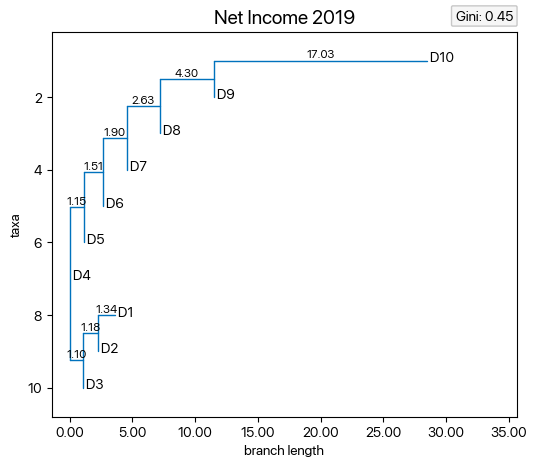

{'D1': 0.014993579440087461, 'D10': 0.33099627342759713, 'D2': 0.027589101816621307, 'D3': 0.03955787494911541, 'D4': 0.05085659866977472, 'D5': 0.06417236555711596, 'D6': 0.07897302482285543, 'D7': 0.09912608126310726, 'D8': 0.12456313716059011, 'D9': 0.16917196289313519}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/global/net_income/2021_Income.pdf


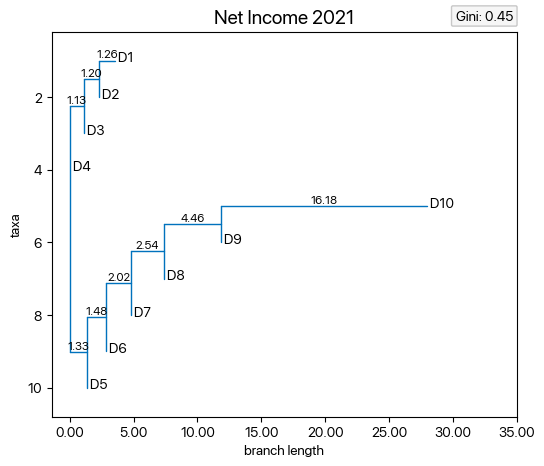

{'D1': 0.014962831499002328, 'D10': 0.3323726179423856, 'D2': 0.02823907753015143, 'D3': 0.0399393109162198, 'D4': 0.05015120101980914, 'D5': 0.06216368493328639, 'D6': 0.07849487102438207, 'D7': 0.09773975916288315, 'D8': 0.12478429392576701, 'D9': 0.171152352046113}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/global/net_income/2022_Income.pdf


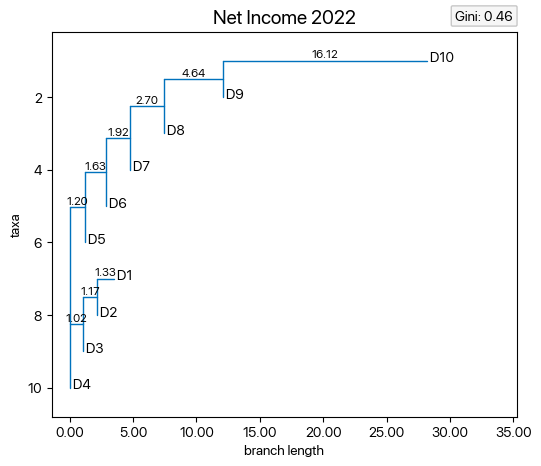

{'D1': 0.015680240354533553, 'D10': 0.3194082437411544, 'D2': 0.028992500200715674, 'D3': 0.042409596664337704, 'D4': 0.051471328843937424, 'D5': 0.0641292224108839, 'D6': 0.08135839061194726, 'D7': 0.09749075546726278, 'D8': 0.1264269889264664, 'D9': 0.1726327327787609}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/global/net_income/2023_Income.pdf


In [ ]:
# árboles de ingreso neto para cada año
os.makedirs("plots/global/net_income/", exist_ok=True)

for y in years:
    data = pd.read_csv(f'data/{y}/{y}_stand_in.csv')
    _, income_tree = compute_tree_for_income_by_deciles(data)
    plot_tree(income_tree, gini=Gini(data["ingreso"]).g, title =f"Net Income {y}", path="plots/global/net_income/", filename=f"{y}_Income.pdf")

{'D1': 0.017642090349299765, 'D10': 0.3532130401612991, 'D2': 0.02313906599095417, 'D3': 0.037681870197809386, 'D4': 0.04646204566508637, 'D5': 0.05097814832979127, 'D6': 0.06885183368753746, 'D7': 0.09335322325758814, 'D8': 0.12725123971445695, 'D9': 0.18142744264617733}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income/Chimborazo_net_income_2019.pdf


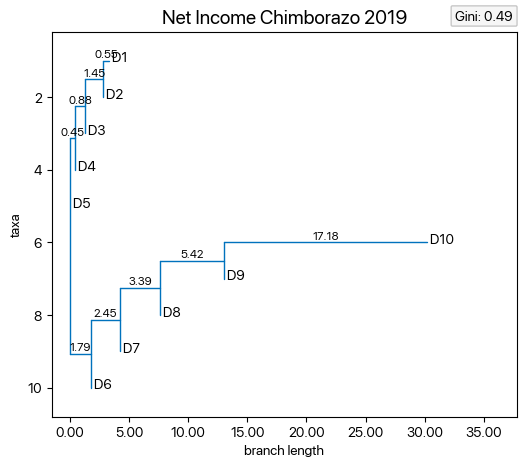

{'D1': 0.02751329347083174, 'D10': 0.30644835427475897, 'D2': 0.03858008107190295, 'D3': 0.052425924095033806, 'D4': 0.06351850339375756, 'D5': 0.0685994678313051, 'D6': 0.08242166846492115, 'D7': 0.09228484350887449, 'D8': 0.11523730511148463, 'D9': 0.15297055877712964}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income/Los Ríos_net_income_2019.pdf


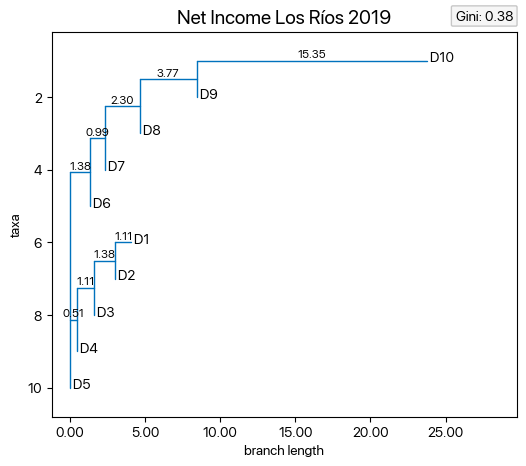

{'D1': 0.015212170325622514, 'D10': 0.3014955061146309, 'D2': 0.030879622808310005, 'D3': 0.0435958449977899, 'D4': 0.0571887431855017, 'D5': 0.0700876675998232, 'D6': 0.08414468837483423, 'D7': 0.1031368793281273, 'D8': 0.12704508619419477, 'D9': 0.16721379107116546}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income/Azuay_net_income_2019.pdf


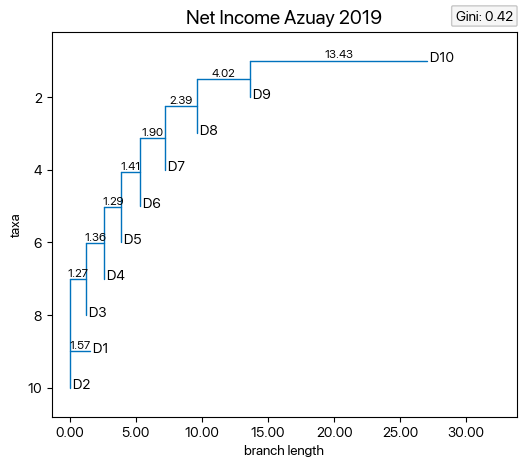

{'D1': 0.023889687333541042, 'D10': 0.3232997316555945, 'D2': 0.036436295842169265, 'D3': 0.0471637905908602, 'D4': 0.056176443984361654, 'D5': 0.06784113408174958, 'D6': 0.07388642096905496, 'D7': 0.09291048151237699, 'D8': 0.11891325540960211, 'D9': 0.15948275862068967}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income/Manabí_net_income_2019.pdf


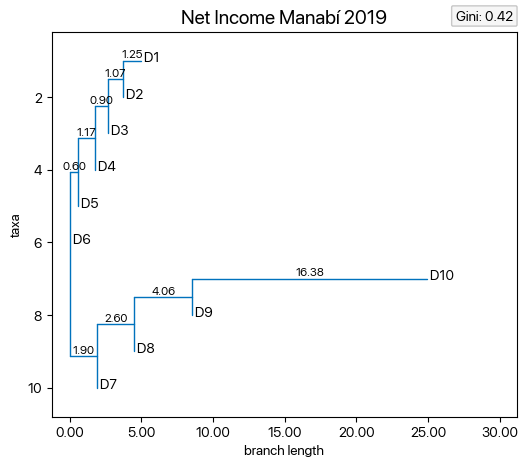

{'D1': 0.013486375865229062, 'D10': 0.34770716140039654, 'D2': 0.025715977970361945, 'D3': 0.040295584937573854, 'D4': 0.05005584024092338, 'D5': 0.06464134063725649, 'D6': 0.07726064574302881, 'D7': 0.09652994893343667, 'D8': 0.12202934338359446, 'D9': 0.1622777808881987}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income/Tungurahua_net_income_2019.pdf


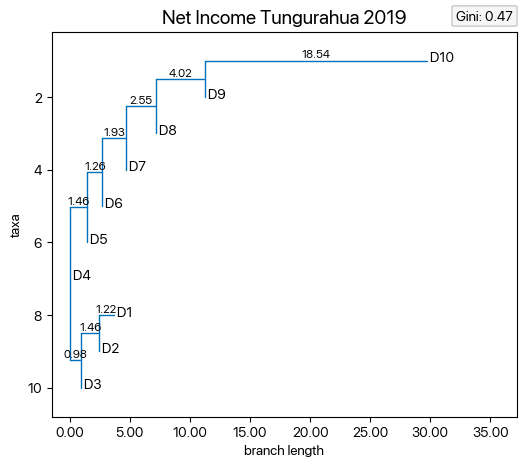

{'D1': 0.01410279217117141, 'D10': 0.36782701180531635, 'D2': 0.026112496830088983, 'D3': 0.03483684893812712, 'D4': 0.04587381672426127, 'D5': 0.0582809430627207, 'D6': 0.07456766198718409, 'D7': 0.0835531769132069, 'D8': 0.11837488597782764, 'D9': 0.17647036559009552}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income/Esmeraldas_net_income_2019.pdf


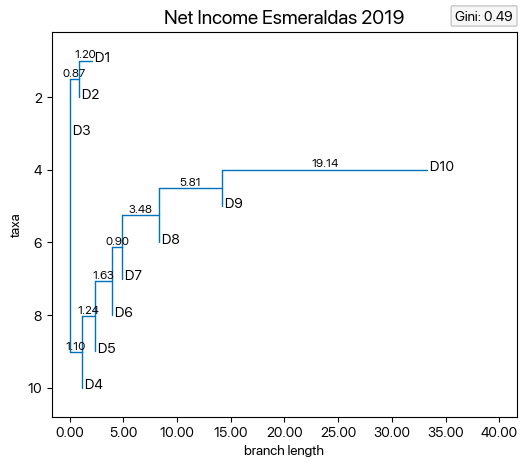

{'D1': 0.01770401414458936, 'D10': 0.30767113222498965, 'D2': 0.03567723698765587, 'D3': 0.046161195286621236, 'D4': 0.059226925727749034, 'D5': 0.06596726381744007, 'D6': 0.08231207765355268, 'D7': 0.10063345009164228, 'D8': 0.12181187574702883, 'D9': 0.16283482831873095}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income/El Oro_net_income_2019.pdf


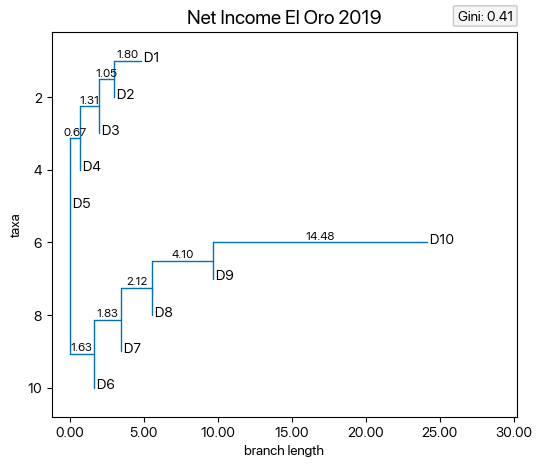

{'D1': 0.022070665085200888, 'D10': 0.304304044911773, 'D2': 0.03561124116077733, 'D3': 0.047828325165132156, 'D4': 0.05331751287839526, 'D5': 0.06739635544023068, 'D6': 0.08093301843149668, 'D7': 0.10092931404501612, 'D8': 0.12481999812171952, 'D9': 0.16278952476025838}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income/Guayas_net_income_2019.pdf


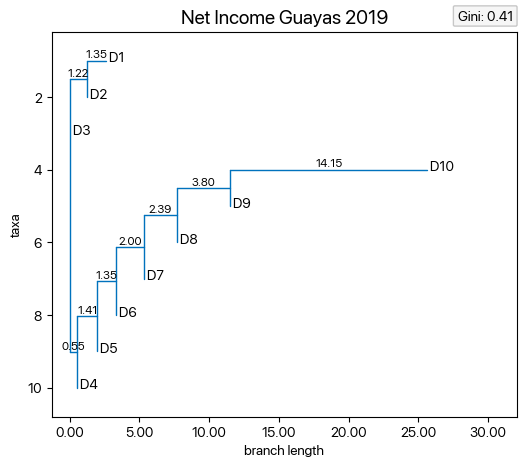

{'D1': 0.01602099459877328, 'D10': 0.3447679303435017, 'D2': 0.02931635320564331, 'D3': 0.04064367161355291, 'D4': 0.05079472286926183, 'D5': 0.06426422272177071, 'D6': 0.07709859527418092, 'D7': 0.09544323626043881, 'D8': 0.11928146392570516, 'D9': 0.16236880918717134}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income/Pichincha_net_income_2019.pdf


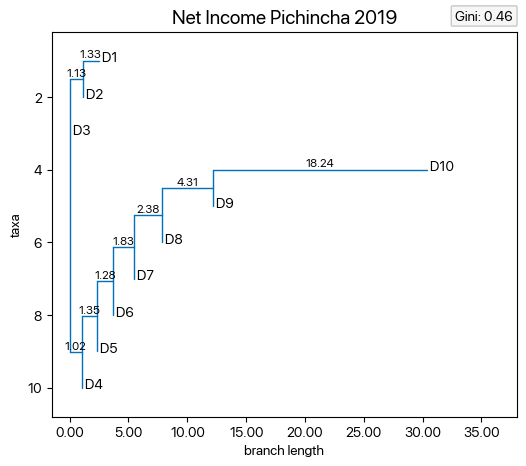

{'D1': 0.012047962948126613, 'D10': 0.34533551554828157, 'D2': 0.025648655763222044, 'D3': 0.03565174596271159, 'D4': 0.048771741079433384, 'D5': 0.06354747271277549, 'D6': 0.07618677013112364, 'D7': 0.10058027079303676, 'D8': 0.12319976804428523, 'D9': 0.16903009701700372}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income/Imbabura_net_income_2019.pdf


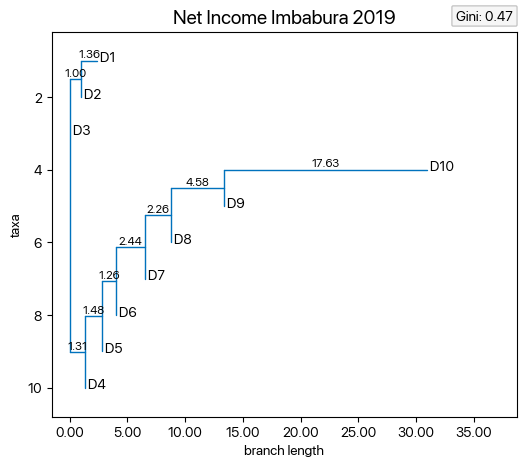

{'D1': 0.019703852912184454, 'D10': 0.3054900784296918, 'D2': 0.033889769853855056, 'D3': 0.04226846097801397, 'D4': 0.05135430506150088, 'D5': 0.06932241889169848, 'D6': 0.07891184159773712, 'D7': 0.10408005828654698, 'D8': 0.1327947542107744, 'D9': 0.1621844597779968}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income/Los Ríos_net_income_2021.pdf


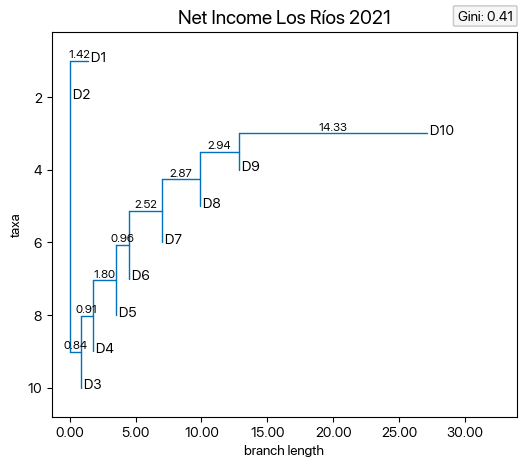

{'D1': 0.013006328191070544, 'D10': 0.35731304486954657, 'D2': 0.028562375912992693, 'D3': 0.038405790818960464, 'D4': 0.04977194394242599, 'D5': 0.06264980094847991, 'D6': 0.07615582687759061, 'D7': 0.09166064375886195, 'D8': 0.11584396504637967, 'D9': 0.16663027963369162}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income/Pichincha_net_income_2021.pdf


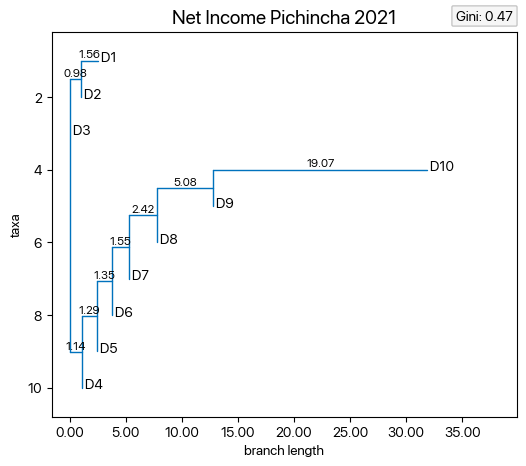

{'D1': 0.018487191880135333, 'D10': 0.308553585510417, 'D2': 0.034678588690188486, 'D3': 0.045329551525018455, 'D4': 0.05773193253796647, 'D5': 0.06744804253262446, 'D6': 0.08260028999516673, 'D7': 0.09909821678410623, 'D8': 0.123838111470072, 'D9': 0.16223448907430488}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income/El Oro_net_income_2021.pdf


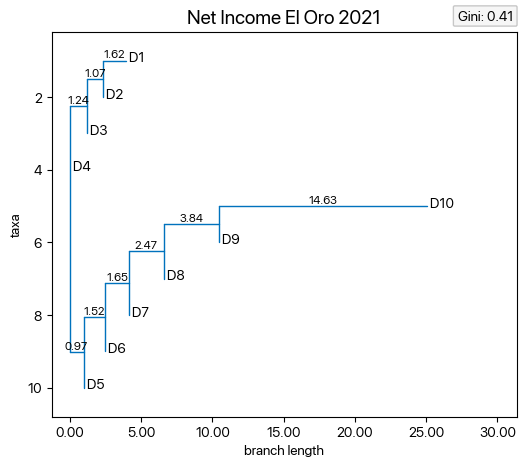

{'D1': 0.013685623093661801, 'D10': 0.317097718395952, 'D2': 0.026200127422646144, 'D3': 0.039013182395976634, 'D4': 0.05121220795129623, 'D5': 0.06606433304709405, 'D6': 0.08085797915070037, 'D7': 0.10415877969732502, 'D8': 0.1253174024247237, 'D9': 0.17639264642062397}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income/Tungurahua_net_income_2021.pdf


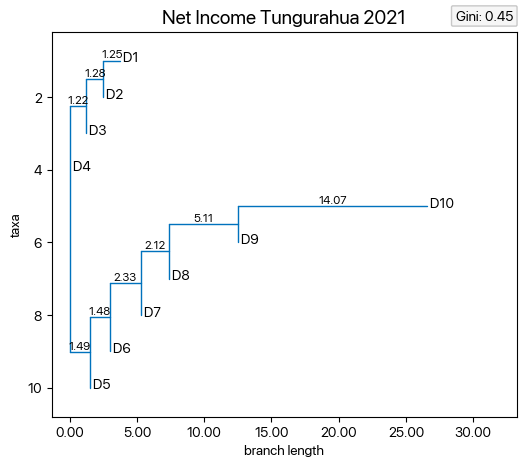

{'D1': 0.01944015112484973, 'D10': 0.3140033280629133, 'D2': 0.032350903373660936, 'D3': 0.04285621228540805, 'D4': 0.054526935398864204, 'D5': 0.06761415788756833, 'D6': 0.08055688796508496, 'D7': 0.09902230749643212, 'D8': 0.12403489136420973, 'D9': 0.16559422504100862}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income/Azuay_net_income_2021.pdf


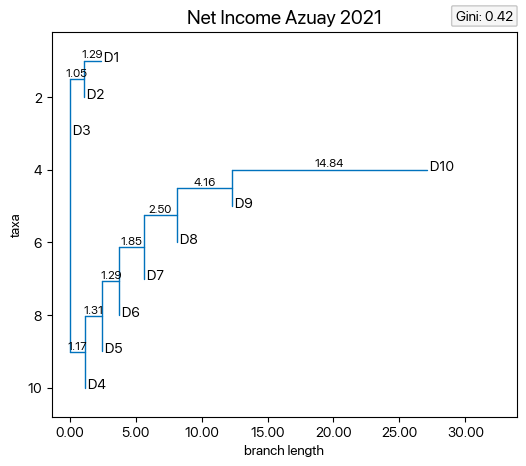

{'D1': 0.019573918142007336, 'D10': 0.30735263311317296, 'D2': 0.03442282988314393, 'D3': 0.045213977506619776, 'D4': 0.05543541992482995, 'D5': 0.06848100409988239, 'D6': 0.08162855885642209, 'D7': 0.10263560701867946, 'D8': 0.12182159360068096, 'D9': 0.16343445785456112}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income/Guayas_net_income_2021.pdf


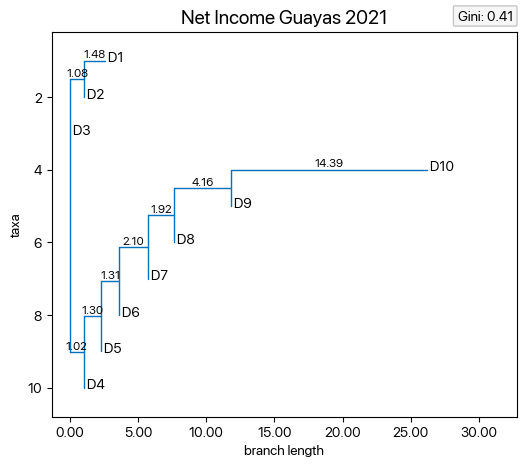

{'D1': 0.024697360920156935, 'D10': 0.34893196069883636, 'D2': 0.03463163542470071, 'D3': 0.04936957177827706, 'D4': 0.04541262868448409, 'D5': 0.06596861272257806, 'D6': 0.07248247879011437, 'D7': 0.08769826632239026, 'D8': 0.11392139767278087, 'D9': 0.15688608698568118}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income/Manabí_net_income_2021.pdf


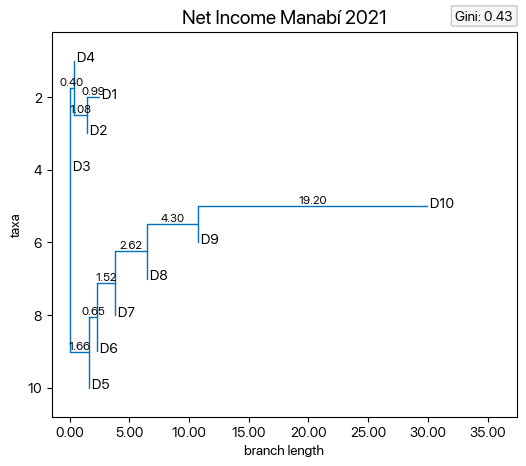

{'D1': 0.012893905191873589, 'D10': 0.34833408577878106, 'D2': 0.024036117381489842, 'D3': 0.0370293453724605, 'D4': 0.04911060948081264, 'D5': 0.061381489841986464, 'D6': 0.08288939051918733, 'D7': 0.09560270880361174, 'D8': 0.1259503386004515, 'D9': 0.16277200902934538}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income/Chimborazo_net_income_2021.pdf


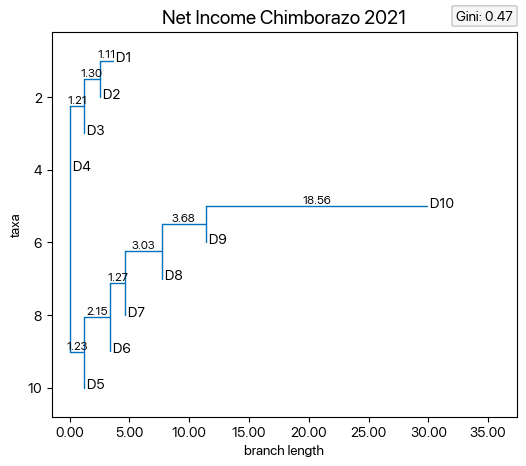

{'D1': 0.013861561177152324, 'D10': 0.35954611080736887, 'D2': 0.02553945175790394, 'D3': 0.035812852554763644, 'D4': 0.04611571817226443, 'D5': 0.05855642022072424, 'D6': 0.08107081705947637, 'D7': 0.08768730622788092, 'D8': 0.1193587145480915, 'D9': 0.1724510474743738}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income/Esmeraldas_net_income_2021.pdf


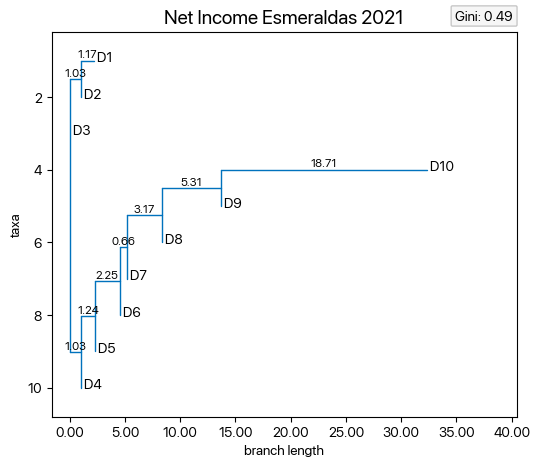

{'D1': 0.015333783018493603, 'D10': 0.3067946946770022, 'D2': 0.02977300518340301, 'D3': 0.044533259267542216, 'D4': 0.05982736418365912, 'D5': 0.06688645930649892, 'D6': 0.09027489710746636, 'D7': 0.09581540303934265, 'D8': 0.12867247890748149, 'D9': 0.1620886553091105}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income/Imbabura_net_income_2021.pdf


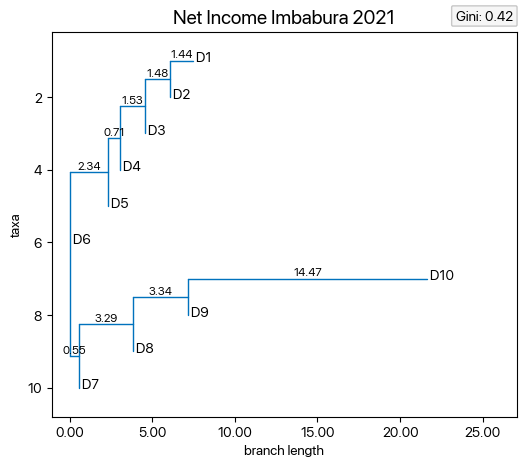

{'D1': 0.014035192128414482, 'D10': 0.3159455652748635, 'D2': 0.023190303318659754, 'D3': 0.03819754408839687, 'D4': 0.047441925054675, 'D5': 0.06719038267015612, 'D6': 0.08776210597282338, 'D7': 0.09151143644965626, 'D8': 0.13793171854155764, 'D9': 0.17679382650079695}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income/Chimborazo_net_income_2022.pdf


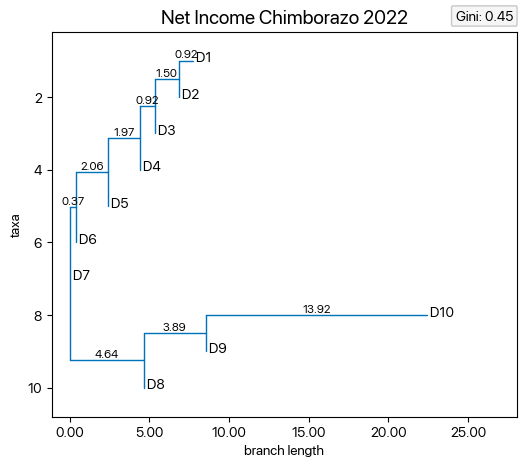

{'D1': 0.028516256082330025, 'D10': 0.27868115900699064, 'D2': 0.0413356658731417, 'D3': 0.05452789966292022, 'D4': 0.0626344317298792, 'D5': 0.0820117200606422, 'D6': 0.07750915330507996, 'D7': 0.10021317885074574, 'D8': 0.1255365319708518, 'D9': 0.14903400345741866}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income/Los Ríos_net_income_2022.pdf


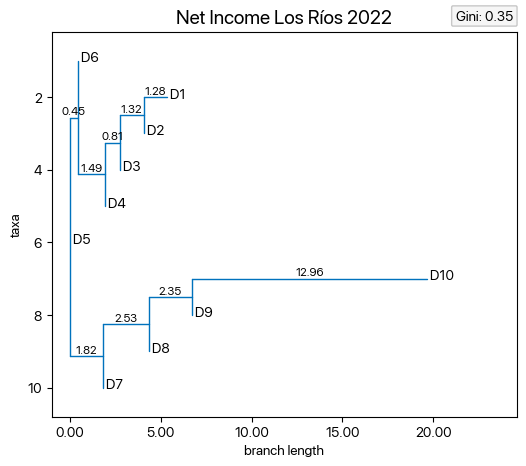

{'D1': 0.016231379720284746, 'D10': 0.2979209204065108, 'D2': 0.031028176766035327, 'D3': 0.04469222165018528, 'D4': 0.05772419792936202, 'D5': 0.07251034213353813, 'D6': 0.08512685759056517, 'D7': 0.10940113275329455, 'D8': 0.12303677005674042, 'D9': 0.16232800099348357}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income/Imbabura_net_income_2022.pdf


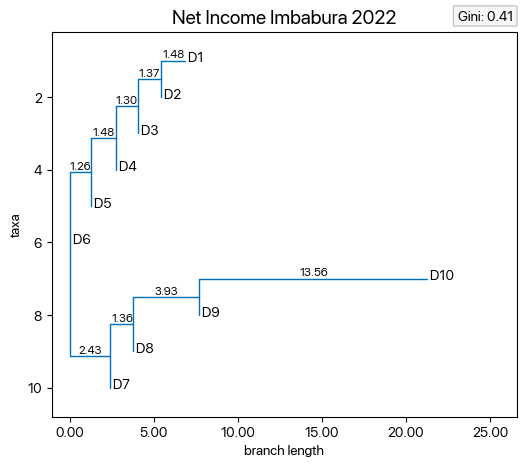

{'D1': 0.020307170837788505, 'D10': 0.2966332636705574, 'D2': 0.03441624171596833, 'D3': 0.043108257666210535, 'D4': 0.05617794558042229, 'D5': 0.07160484147415513, 'D6': 0.08407743704700715, 'D7': 0.10450523260010804, 'D8': 0.1268449298922276, 'D9': 0.16232467951555496}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income/Azuay_net_income_2022.pdf


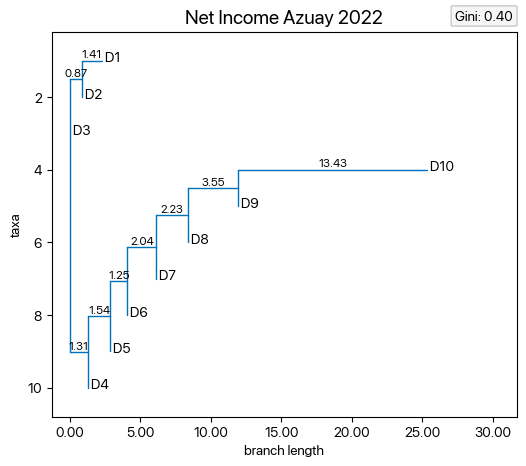

{'D1': 0.01631418818654002, 'D10': 0.33485455624532173, 'D2': 0.028335559513081112, 'D3': 0.03748886910069887, 'D4': 0.05280498664408956, 'D5': 0.06634387058543638, 'D6': 0.07846170970750344, 'D7': 0.09187815375552065, 'D8': 0.12619100623001325, 'D9': 0.16732710003179505}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income/Esmeraldas_net_income_2022.pdf


{'D1': 0.01331683761257429, 'D10': 0.3126016984519779, 'D2': 0.027381533167262936, 'D3': 0.04033028444908521, 'D4': 0.05409700535582494, 'D5': 0.06482117139037114, 'D6': 0.08765713050475335, 'D7': 0.09888814557584841, 'D8': 0.12913403308780202, 'D9': 0.17177216040449983}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income/Tungurahua_net_income_2022.pdf


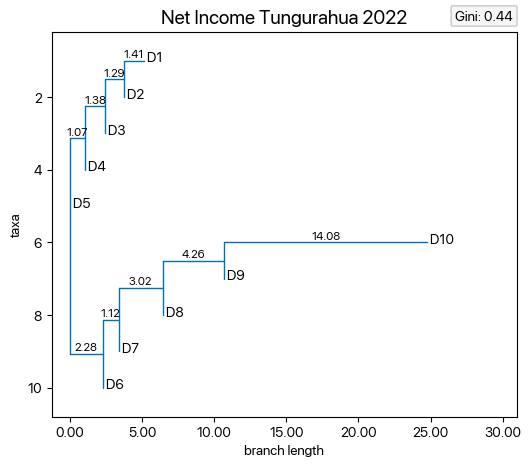

{'D1': 0.023788359315677993, 'D10': 0.2963248760448491, 'D2': 0.03633917005383156, 'D3': 0.04779559565778877, 'D4': 0.05953455130325449, 'D5': 0.07096082547930711, 'D6': 0.08487738419508183, 'D7': 0.09795193639178285, 'D8': 0.12342207531124902, 'D9': 0.15900522624717722}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income/El Oro_net_income_2022.pdf


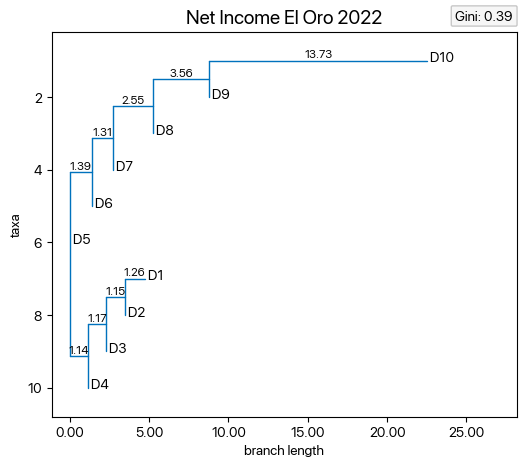

{'D1': 0.018567432949945183, 'D10': 0.3426056219021029, 'D2': 0.0322809093061699, 'D3': 0.04580403442334994, 'D4': 0.05229746781820933, 'D5': 0.061512105214527456, 'D6': 0.07601973512613024, 'D7': 0.09272663822474049, 'D8': 0.1175920363597868, 'D9': 0.16059401867503773}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income/Guayas_net_income_2022.pdf


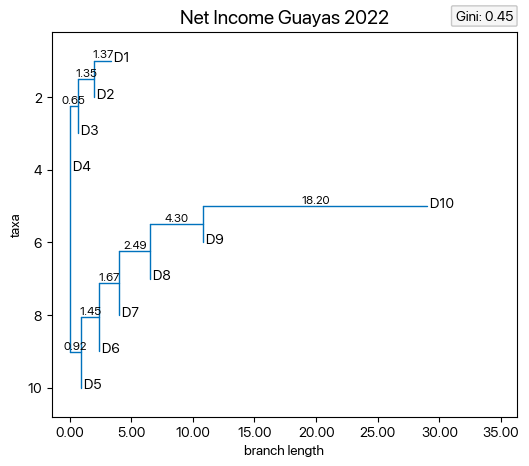

{'D1': 0.023830409356897404, 'D10': 0.3219704353426458, 'D2': 0.04057017543864609, 'D3': 0.046215074722393855, 'D4': 0.049155295646229266, 'D5': 0.06275990903229252, 'D6': 0.07288011696202779, 'D7': 0.09190220922581052, 'D8': 0.12977582846016486, 'D9': 0.16094054581289177}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income/Manabí_net_income_2022.pdf


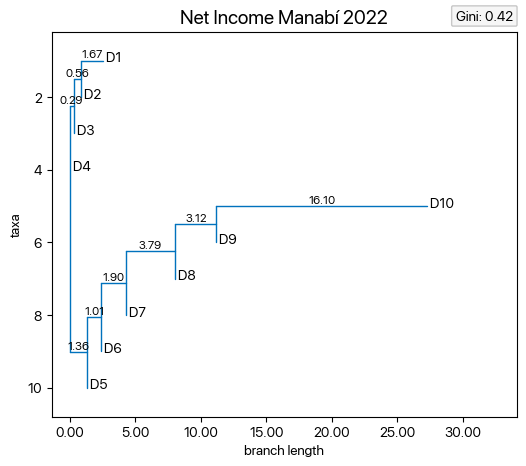

{'D1': 0.01592420538949672, 'D10': 0.3326081485127584, 'D2': 0.029182290133821585, 'D3': 0.037782839852827016, 'D4': 0.048977702700676626, 'D5': 0.06365629652454999, 'D6': 0.07896053999284418, 'D7': 0.09869267662913749, 'D8': 0.12641251071872117, 'D9': 0.16780278954516664}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income/Pichincha_net_income_2022.pdf


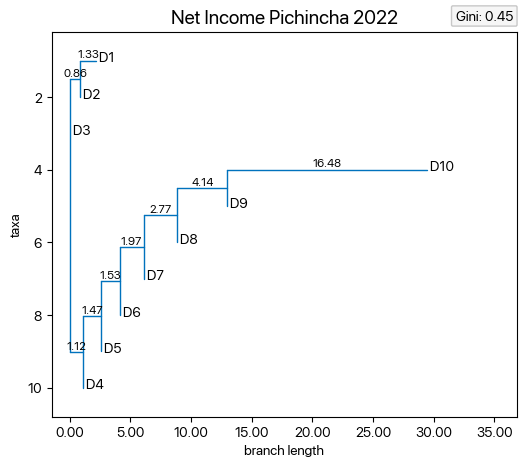

{'D1': 0.014322306657986481, 'D10': 0.3310162510115053, 'D2': 0.03368845028261306, 'D3': 0.03463150785779909, 'D4': 0.052622612695380246, 'D5': 0.06647947480819426, 'D6': 0.07980092358799944, 'D7': 0.1086219799341685, 'D8': 0.12139280477491343, 'D9': 0.15742368838944018}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income/Imbabura_net_income_2023.pdf


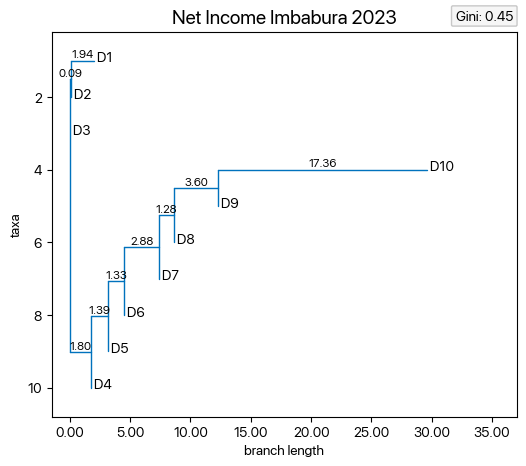

{'D1': 0.013927405971911302, 'D10': 0.3140390591065522, 'D2': 0.028883635715638116, 'D3': 0.040121342733357844, 'D4': 0.053642231057948256, 'D5': 0.06925278715181485, 'D6': 0.0827973425997082, 'D7': 0.09903855792041164, 'D8': 0.12644926325637343, 'D9': 0.1718483744862842}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income/Tungurahua_net_income_2023.pdf


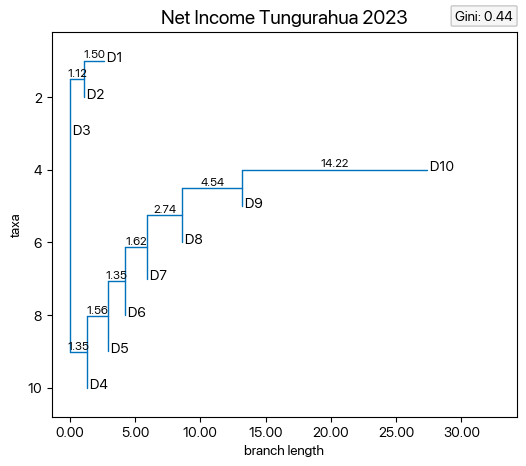

{'D1': 0.02664275920261576, 'D10': 0.2775234679886088, 'D2': 0.04237949583377281, 'D3': 0.0492458601413353, 'D4': 0.06340048518088809, 'D5': 0.08167914776922265, 'D6': 0.07585697711211893, 'D7': 0.10688745912878389, 'D8': 0.12095770488345109, 'D9': 0.1554266427592026}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income/Los Ríos_net_income_2023.pdf


{'D1': 0.01999196478479598, 'D10': 0.34369759642258235, 'D2': 0.027546813862493018, 'D3': 0.03539861654555617, 'D4': 0.04703221073225268, 'D5': 0.06329478759083289, 'D6': 0.07284097261039688, 'D7': 0.0960382895472331, 'D8': 0.12155883174958079, 'D9': 0.17259991615427617}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income/Manabí_net_income_2023.pdf


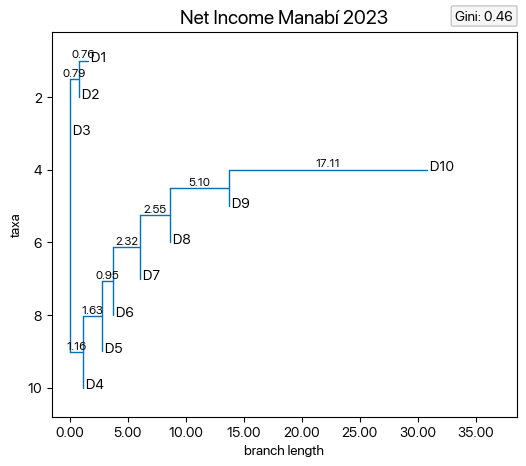

{'D1': 0.022613371362740147, 'D10': 0.28400887127265717, 'D2': 0.03914043052062901, 'D3': 0.049746118183825155, 'D4': 0.06115874655210477, 'D5': 0.07051595991686986, 'D6': 0.08205673452919579, 'D7': 0.10188260789025605, 'D8': 0.12327034289904867, 'D9': 0.16560681687267342}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income/El Oro_net_income_2023.pdf


{'D1': 0.017795469773150833, 'D10': 0.2916337756957778, 'D2': 0.032799382907205236, 'D3': 0.04368971943673392, 'D4': 0.05559465561605117, 'D5': 0.06949050431570829, 'D6': 0.08269493882560935, 'D7': 0.10507130912632946, 'D8': 0.13168737718670998, 'D9': 0.169542867116724}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income/Azuay_net_income_2023.pdf


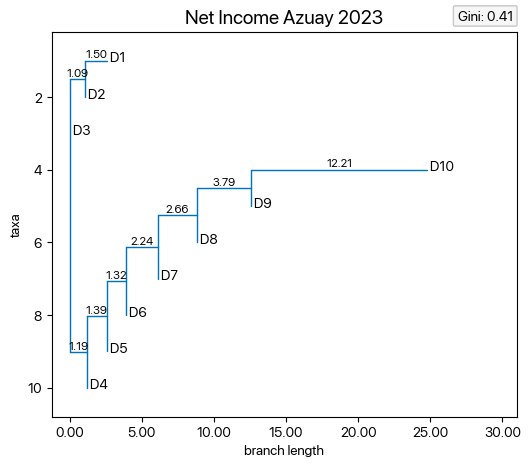

{'D1': 0.010909220337776514, 'D10': 0.33413713939954787, 'D2': 0.02402519976508694, 'D3': 0.03790642629602605, 'D4': 0.042640280471961715, 'D5': 0.05365627947536083, 'D6': 0.0665320069050204, 'D7': 0.09719528038297946, 'D8': 0.13644533822142338, 'D9': 0.1965528287448168}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income/Chimborazo_net_income_2023.pdf


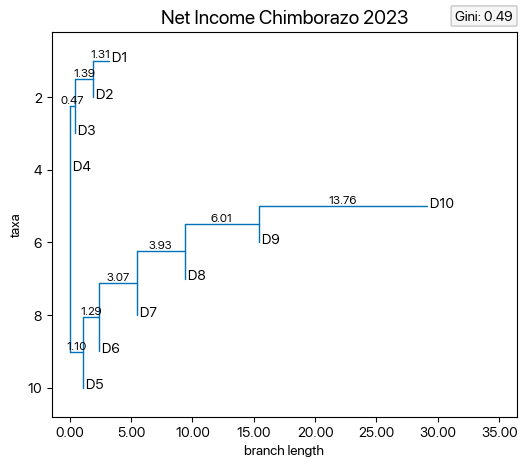

{'D1': 0.023131267959945988, 'D10': 0.3041796010919865, 'D2': 0.033640930560497204, 'D3': 0.04617440229626173, 'D4': 0.055363148611786615, 'D5': 0.06741678173000865, 'D6': 0.08273788733911533, 'D7': 0.09956270489707407, 'D8': 0.12468513990940734, 'D9': 0.16310813560391663}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income/Guayas_net_income_2023.pdf


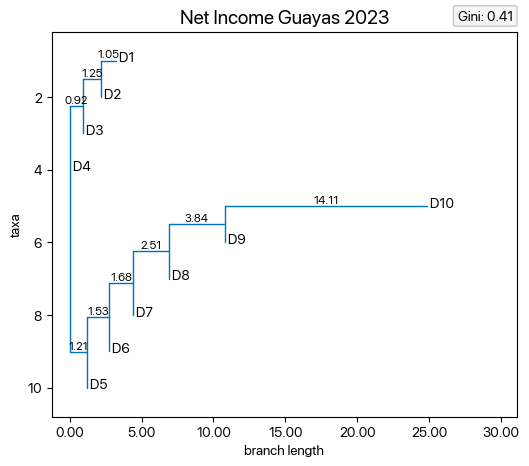

{'D1': 0.01800035706659292, 'D10': 0.3045147920087096, 'D2': 0.03142536082979476, 'D3': 0.04530194881345371, 'D4': 0.05224374345815495, 'D5': 0.07332817570476895, 'D6': 0.08033998340690539, 'D7': 0.09835434308498536, 'D8': 0.1252148525700043, 'D9': 0.17127644305663003}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income/Esmeraldas_net_income_2023.pdf


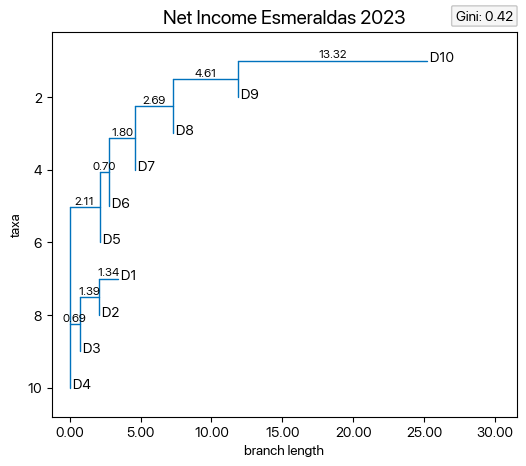

{'D1': 0.014703146473345296, 'D10': 0.32270480882908936, 'D2': 0.03129294669059179, 'D3': 0.04645744189256502, 'D4': 0.0473171258649351, 'D5': 0.07079189946648583, 'D6': 0.07224270993992714, 'D7': 0.09918997665500419, 'D8': 0.12649356962389952, 'D9': 0.16880637456415673}

Compute income: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income/Pichincha_net_income_2023.pdf


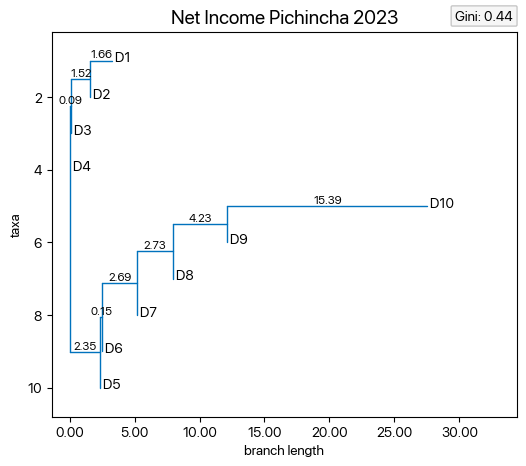

In [ ]:
# árboles de ingreso neto para cada año a nivel de provincia
os.makedirs("plots/provinces/net_income/", exist_ok=True)

for y in years:
    directory = f"data/{y}/{y}_prov"
    for file in os.listdir(directory):
        if file.endswith("in.csv"):
            data = pd.read_csv(join(directory, file))
            _, income_tree = compute_tree_for_income_by_deciles(data)
            code = file.split("_")[1][-2:]
            plot_tree(income_tree, gini=Gini(data["ingreso"]).g, title=f"Net Income {province_names[code]} {y}", path="plots/provinces/net_income/", filename=f"{province_names[code]}_net_income_{y}.pdf")

## Árboles de ingreso neto estandarizado

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/global/net_income_est/2019_Income_est.pdf


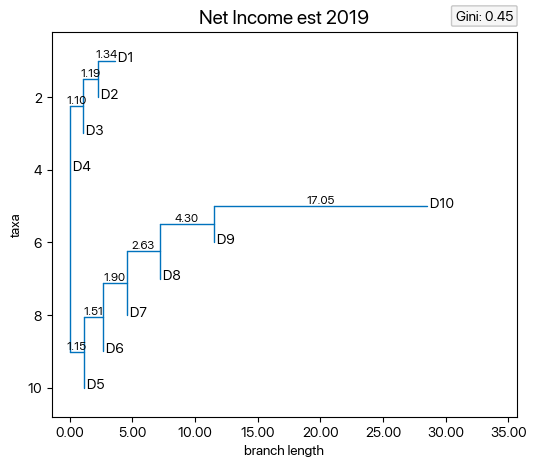

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/global/net_income_est/2021_Income_est.pdf


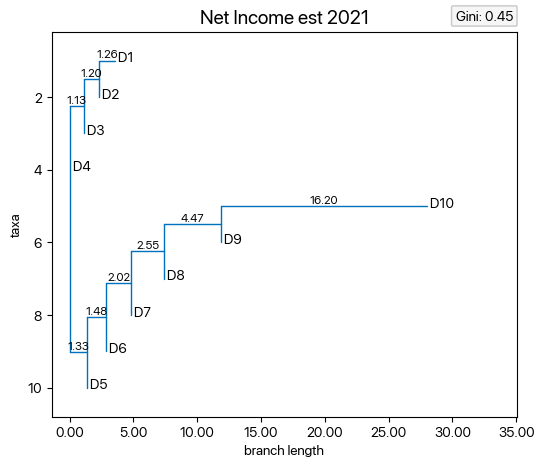

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/global/net_income_est/2022_Income_est.pdf


Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/global/net_income_est/2023_Income_est.pdf


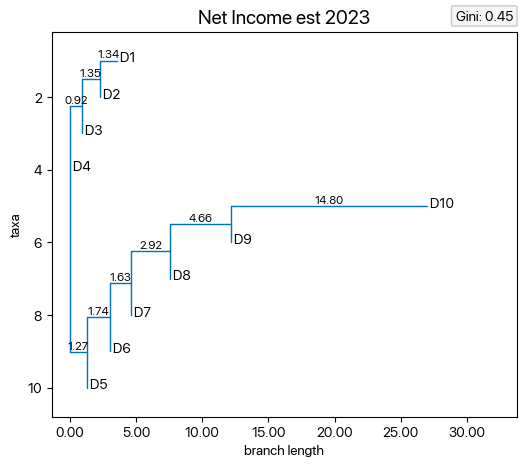

In [ ]:
# árboles ingreso neto est para cada año
os.makedirs("plots/global/net_income_est/", exist_ok=True)
for y in years:
    general_base = f"data/{y}/{y}_stand_in.csv"
    data = pd.read_csv(general_base)
    _, income_est_tree = compute_tree_for_ingreso_est_by_deciles(data)
    plot_tree(income_est_tree, gini=Gini(data["ingreso_est"]).g, title =f"Net Income est {y}", path="plots/global/net_income_est/", filename=f"{y}_Income_est.pdf")

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income_est/Chimborazo_net_icome_est_2019.pdf


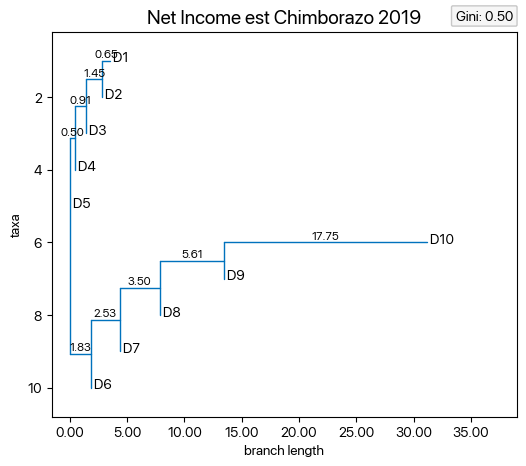

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income_est/Los Ríos_net_icome_est_2019.pdf


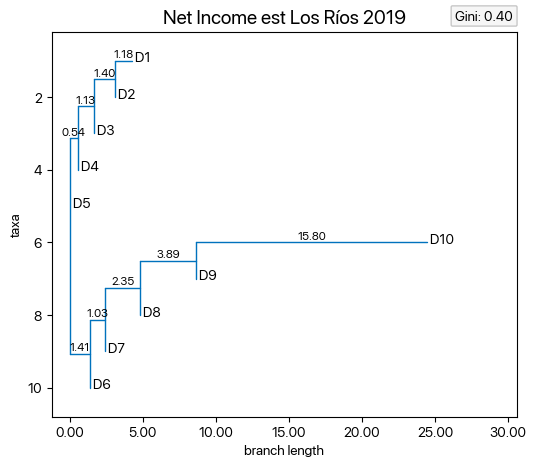

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income_est/Azuay_net_icome_est_2019.pdf


Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income_est/Manabí_net_icome_est_2019.pdf


Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income_est/Tungurahua_net_icome_est_2019.pdf


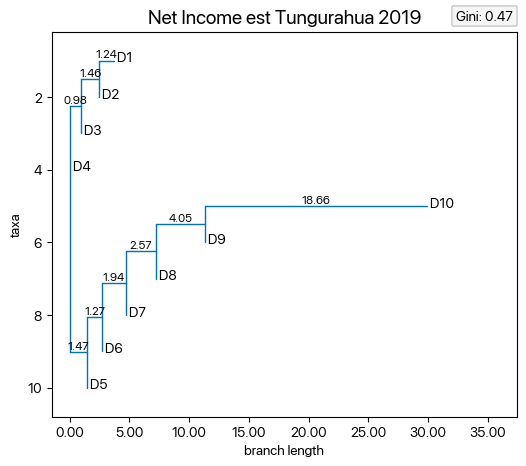

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income_est/Esmeraldas_net_icome_est_2019.pdf


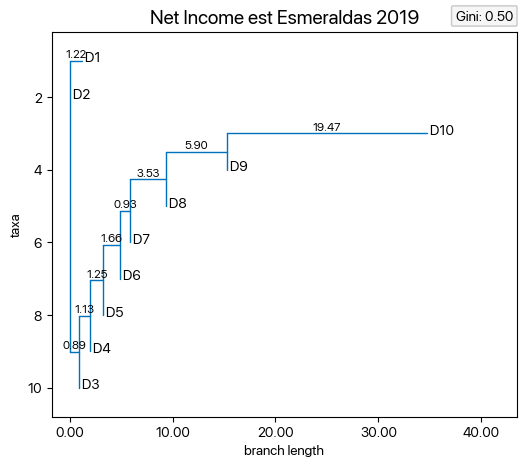

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income_est/El Oro_net_icome_est_2019.pdf


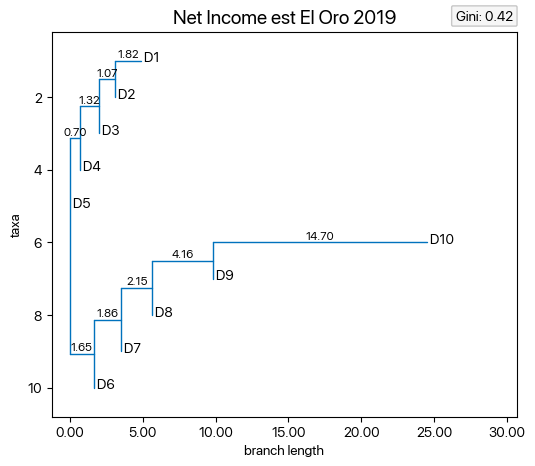

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income_est/Guayas_net_icome_est_2019.pdf


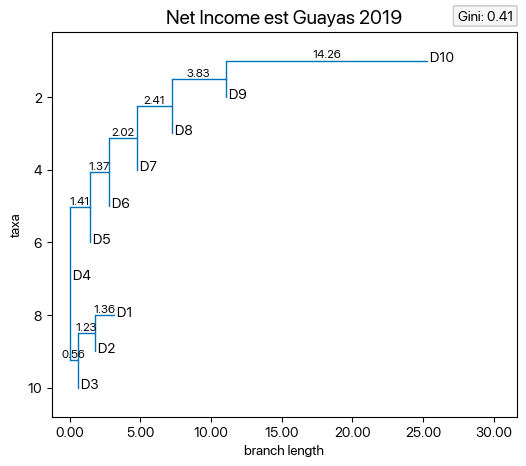

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income_est/Pichincha_net_icome_est_2019.pdf


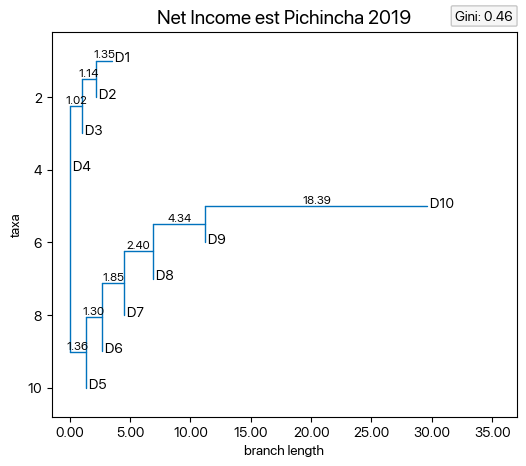

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income_est/Imbabura_net_icome_est_2019.pdf


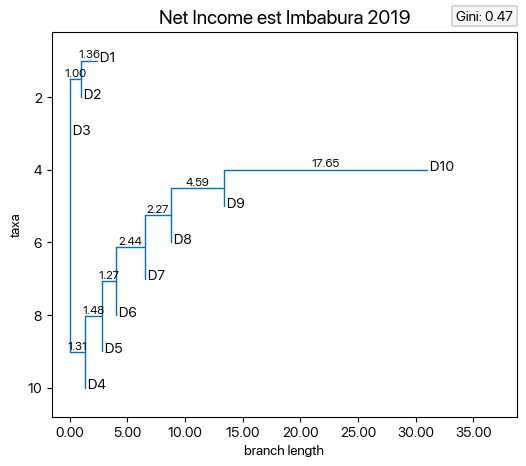

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income_est/Los Ríos_net_icome_est_2021.pdf


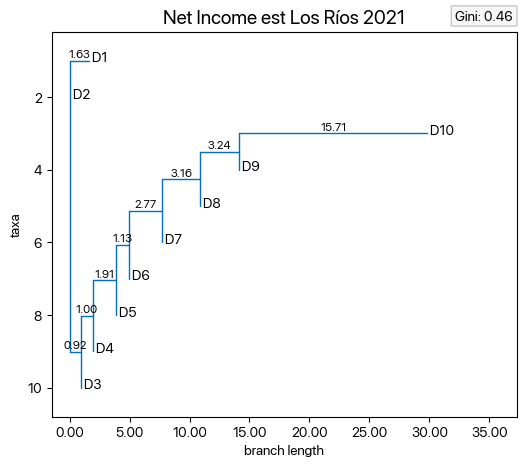

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income_est/Pichincha_net_icome_est_2021.pdf


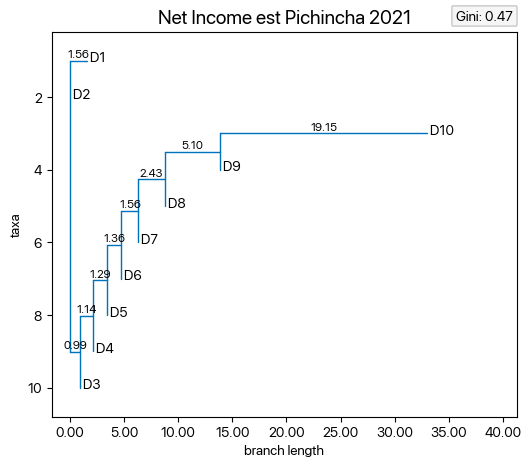

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income_est/El Oro_net_icome_est_2021.pdf


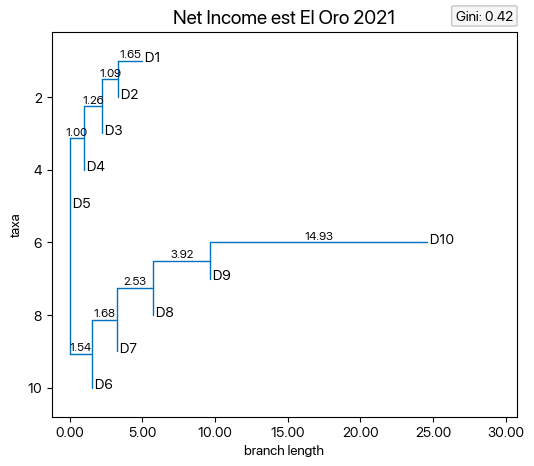

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income_est/Tungurahua_net_icome_est_2021.pdf


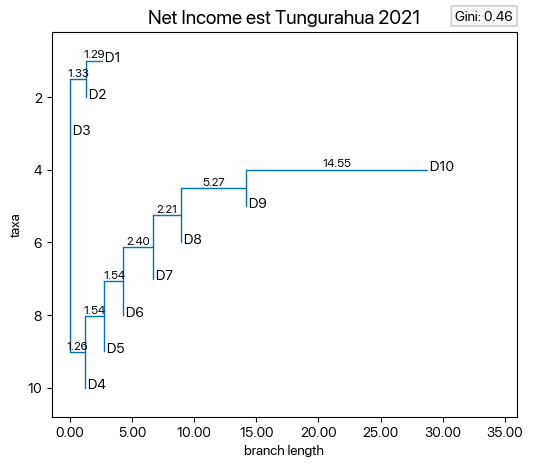

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income_est/Azuay_net_icome_est_2021.pdf


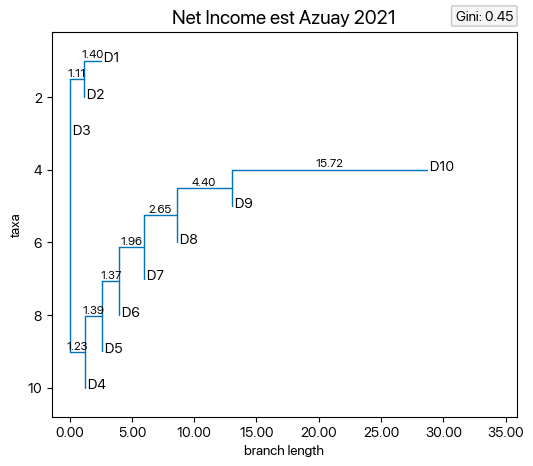

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income_est/Guayas_net_icome_est_2021.pdf


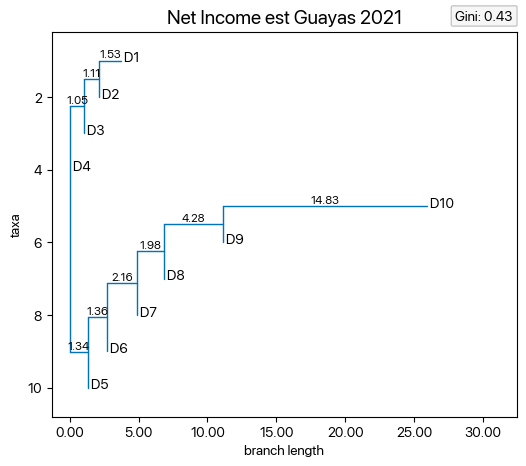

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income_est/Manabí_net_icome_est_2021.pdf


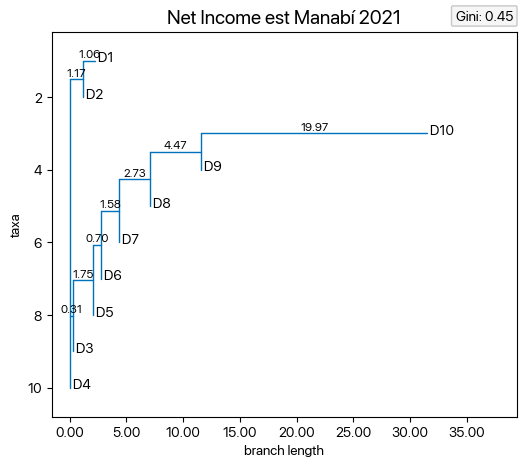

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income_est/Chimborazo_net_icome_est_2021.pdf


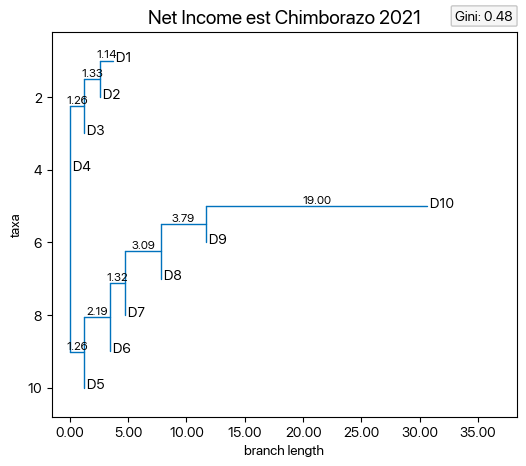

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income_est/Esmeraldas_net_icome_est_2021.pdf


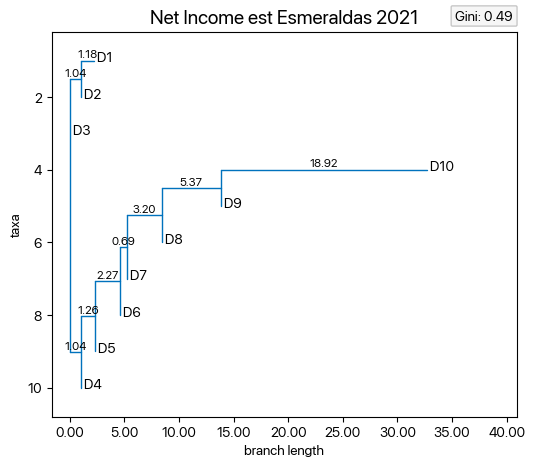

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income_est/Imbabura_net_icome_est_2021.pdf


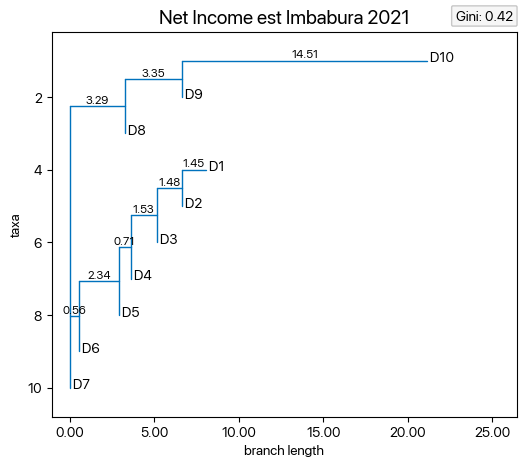

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income_est/Chimborazo_net_icome_est_2022.pdf


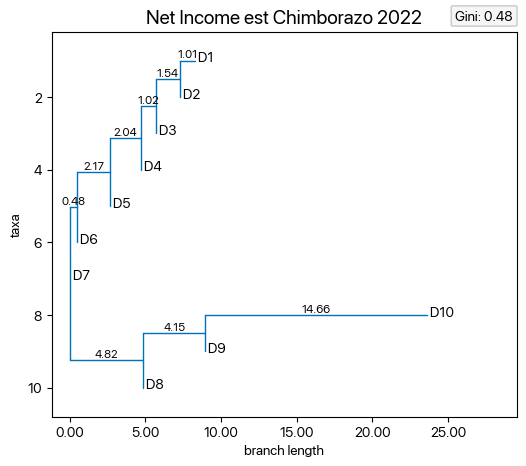

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income_est/Los Ríos_net_icome_est_2022.pdf


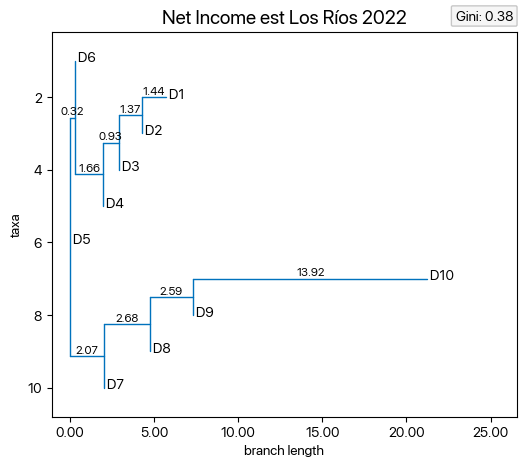

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income_est/Imbabura_net_icome_est_2022.pdf


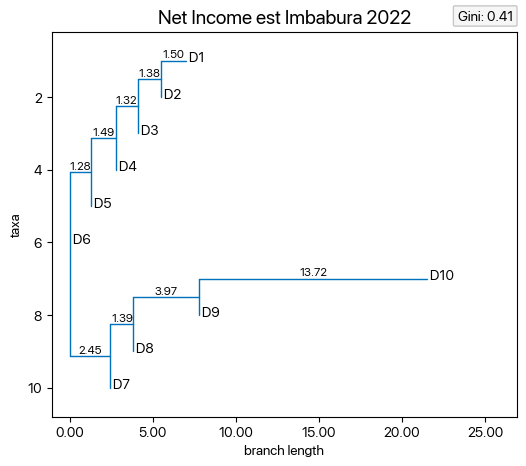

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income_est/Azuay_net_icome_est_2022.pdf


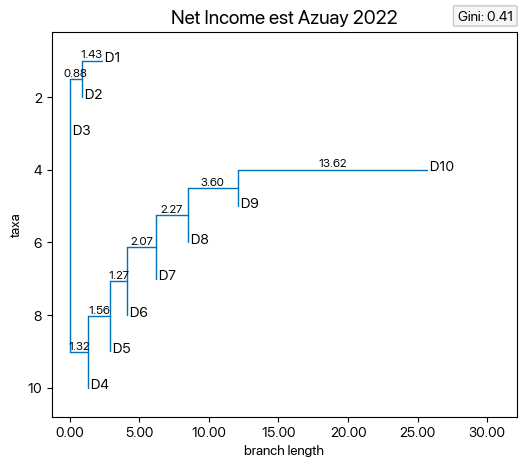

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income_est/Esmeraldas_net_icome_est_2022.pdf


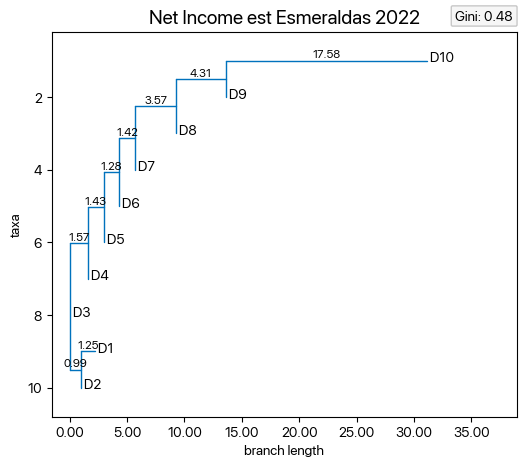

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income_est/Tungurahua_net_icome_est_2022.pdf


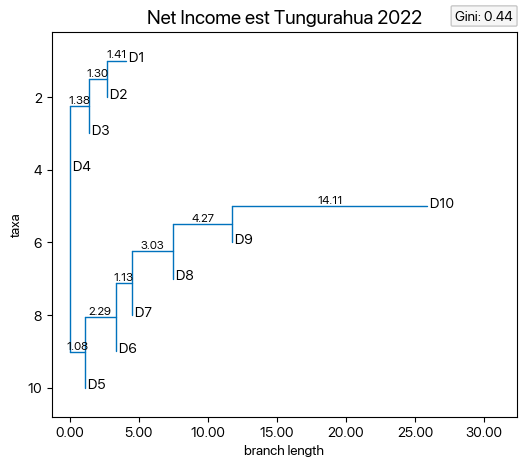

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income_est/El Oro_net_icome_est_2022.pdf


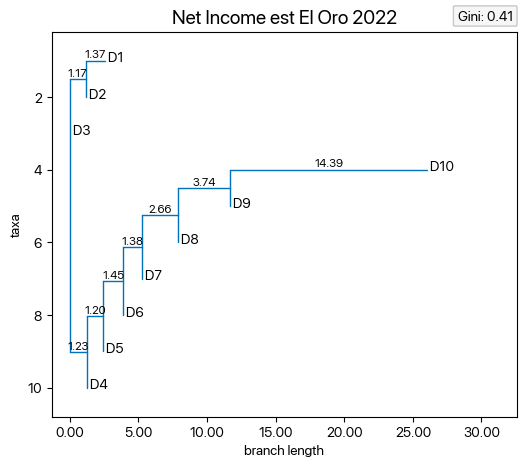

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income_est/Guayas_net_icome_est_2022.pdf


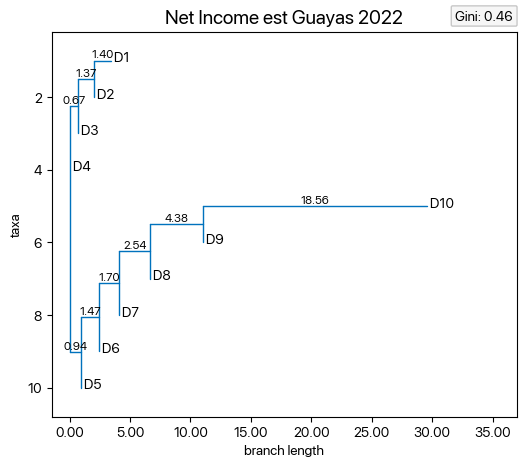

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income_est/Manabí_net_icome_est_2022.pdf


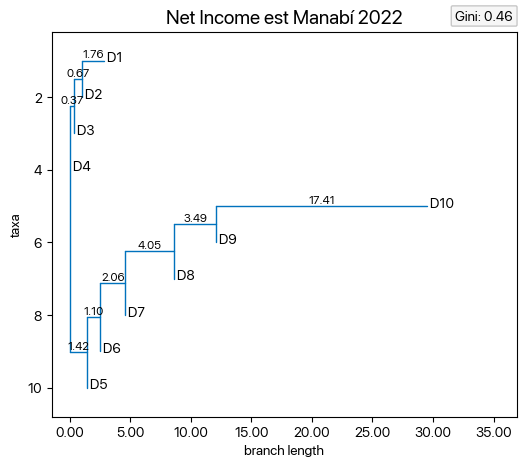

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income_est/Pichincha_net_icome_est_2022.pdf


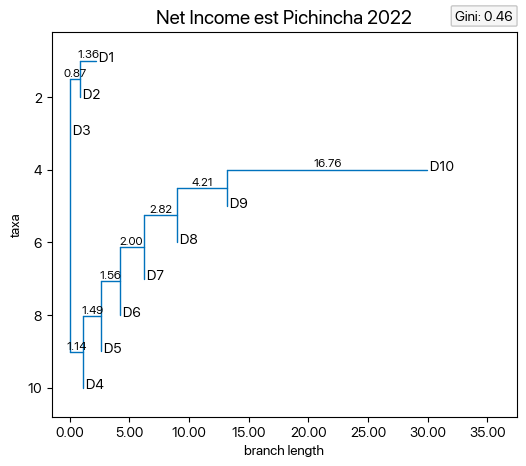

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income_est/Imbabura_net_icome_est_2023.pdf


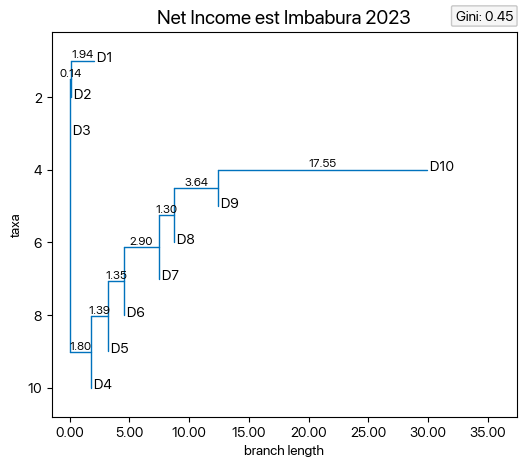

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income_est/Tungurahua_net_icome_est_2023.pdf


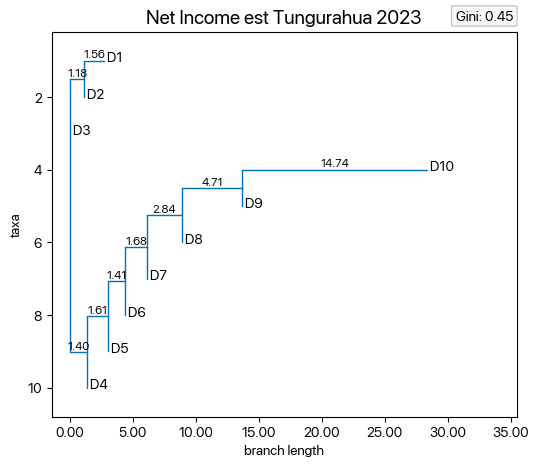

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income_est/Los Ríos_net_icome_est_2023.pdf


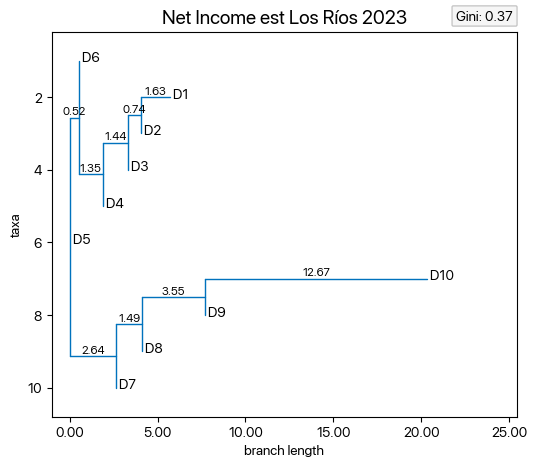

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income_est/Manabí_net_icome_est_2023.pdf


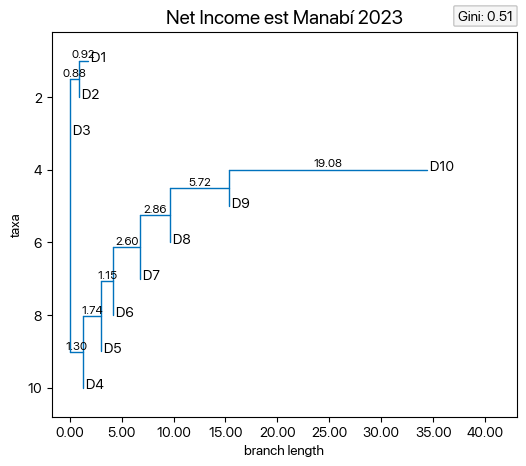

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income_est/El Oro_net_icome_est_2023.pdf


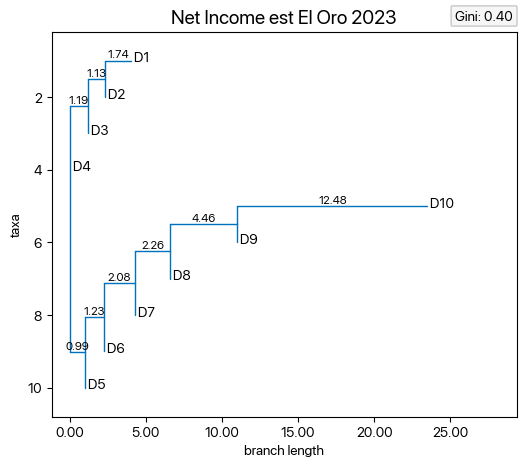

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income_est/Azuay_net_icome_est_2023.pdf


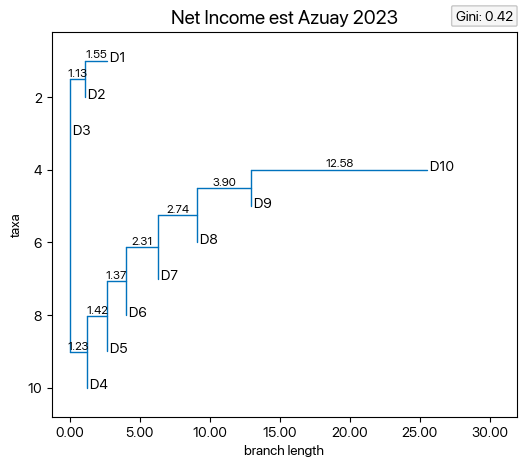

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income_est/Chimborazo_net_icome_est_2023.pdf


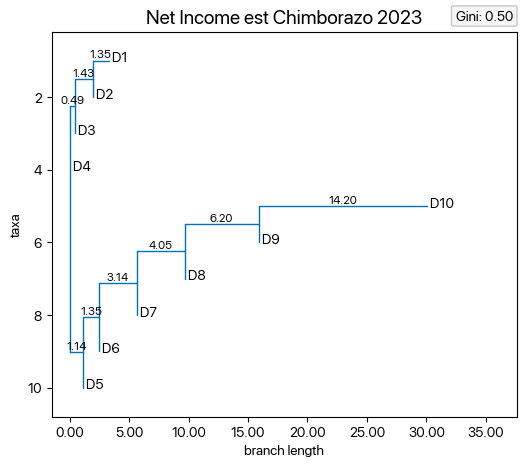

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income_est/Guayas_net_icome_est_2023.pdf


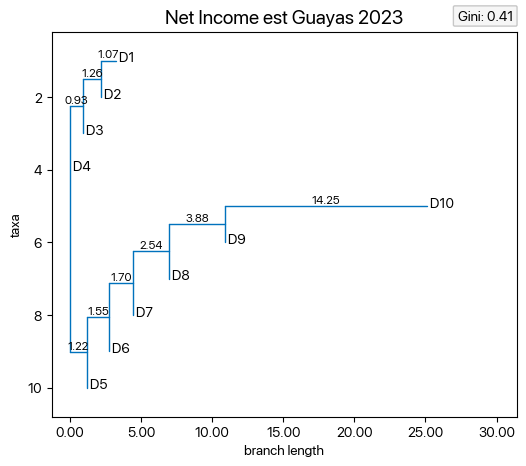

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income_est/Esmeraldas_net_icome_est_2023.pdf


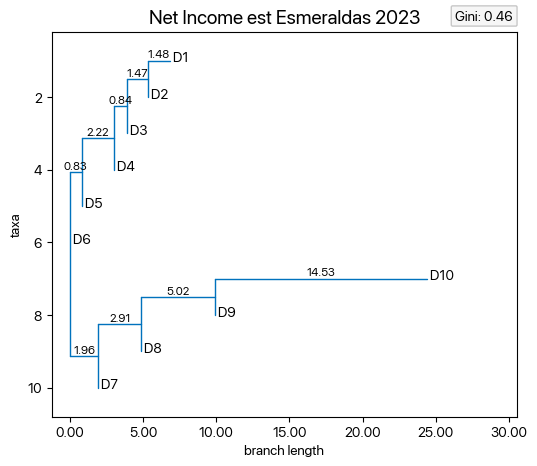

Compute income_est by deciles: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/net_income_est/Pichincha_net_icome_est_2023.pdf


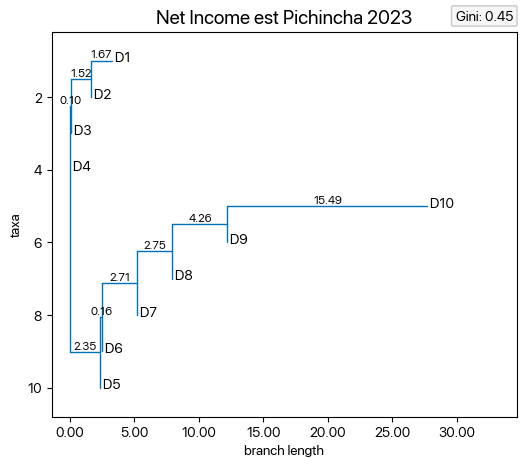

In [ ]:
# árboles ingreso neto est para cada año a nivel de provincia
os.makedirs("plots/provinces/net_income_est/", exist_ok=True)
for y in years:
    directory = f"data/{y}/{y}_prov"
    for file in os.listdir(directory):
        if file.endswith("in.csv"):
            data = pd.read_csv(join(directory, file))
            income_est_dict, income_est_tree = compute_tree_for_ingreso_est_by_deciles(data)
            code = file.split("_")[1][-2:]
            plot_tree(income_est_tree, gini=Gini(data["ingreso_est"]).g, title=f"Net Income est {province_names[code]} {y}", path="plots/provinces/net_income_est/", filename=f"{province_names[code]}_net_icome_est_{y}.pdf")

## Árboles de la variable adicional

{'D1': 0.06156026968445832, 'D10': 0.13070262722245393, 'D2': 0.07852648859841349, 'D3': 0.08696515347650603, 'D4': 0.09320190037817838, 'D5': 0.09874730005108699, 'D6': 0.1041726117017836, 'D7': 0.10962863940486306, 'D8': 0.1151238694405022, 'D9': 0.1213711400417541}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/global/ieesb/2019_ieesb.pdf


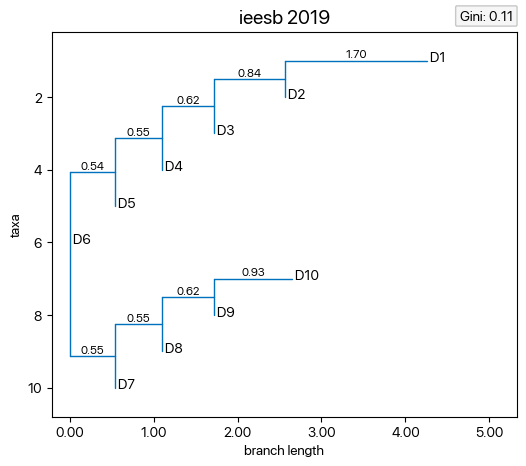

{'D1': 0.060525198009136534, 'D10': 0.13585405755357888, 'D2': 0.07695881968950812, 'D3': 0.08475259092566785, 'D4': 0.09187097244311773, 'D5': 0.09793253479532255, 'D6': 0.10386178387420407, 'D7': 0.10965794763138381, 'D8': 0.11564156941495457, 'D9': 0.12294452566312586}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/global/ieesb/2021_ieesb.pdf


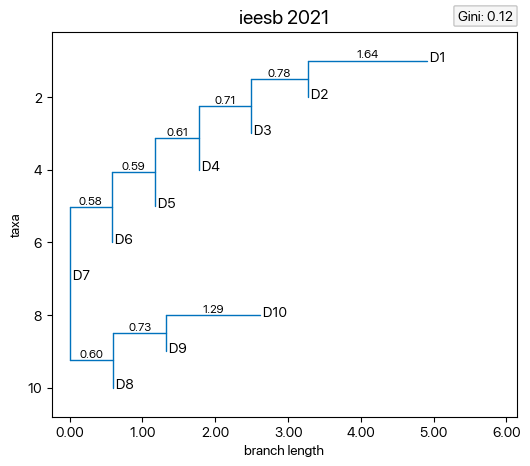

{'D1': 0.06012466863258911, 'D10': 0.13263475061651175, 'D2': 0.07734601702254229, 'D3': 0.08537882580050155, 'D4': 0.092257941040879, 'D5': 0.09847416949955742, 'D6': 0.10478061449186436, 'D7': 0.11046869651403347, 'D8': 0.1160280257149318, 'D9': 0.12250629066658925}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/global/ieesb/2022_ieesb.pdf


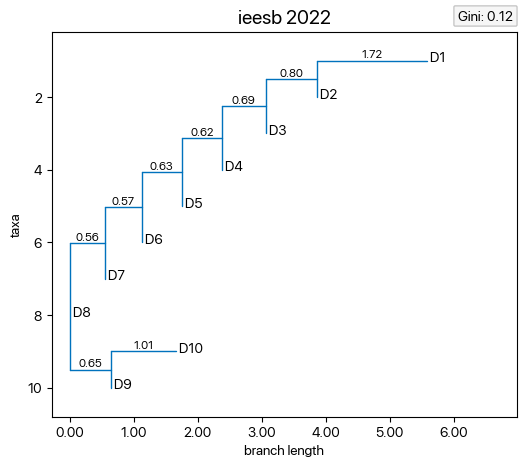

{'D1': 0.06343851775971882, 'D10': 0.13232687397048978, 'D2': 0.07841960093517175, 'D3': 0.08586264692595064, 'D4': 0.09242911622408155, 'D5': 0.09828164570353336, 'D6': 0.10378818917698969, 'D7': 0.10916179004245098, 'D8': 0.11484937708626436, 'D9': 0.12144224217534896}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/global/ieesb/2023_ieesb.pdf


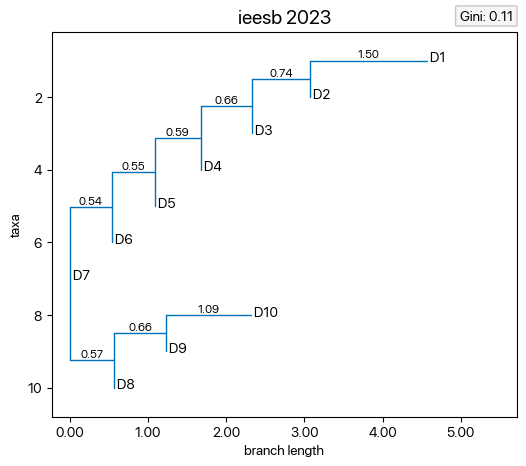

In [ ]:
# árboles de la variable adicional para cada año
os.makedirs("plots/global/ieesb/", exist_ok=True)

for y in years:
    general_base = f"data/{y}/{y}_stand_ieesb.csv"
    data = pd.read_csv(general_base)
    _, ieesb_tree = compute_tree_for_ieesb_by_deciles(data)
    plot_tree(ieesb_tree, gini=Gini(data["ieesb"]).g, title =f"ieesb {y}", path="plots/global/ieesb/", filename=f"{y}_ieesb.pdf")

{'D1': 0.045977923990164545, 'D10': 0.1721584379351025, 'D2': 0.05858855448327451, 'D3': 0.0706980985906939, 'D4': 0.0794584398471114, 'D5': 0.09041591120359248, 'D6': 0.09993477957849116, 'D7': 0.11229440178604966, 'D8': 0.12861195100260173, 'D9': 0.14186150158291833}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/ieesb/Chimborazo_ieesb_2019.pdf


{'D1': 0.062422936052174166, 'D10': 0.1308116022452338, 'D2': 0.07890073716596466, 'D3': 0.0878297865825124, 'D4': 0.09342224852983404, 'D5': 0.09988989986507778, 'D6': 0.10408160226086631, 'D7': 0.10866340095622817, 'D8': 0.11444090427514933, 'D9': 0.11953688206695942}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/ieesb/Pichincha_ieesb_2019.pdf


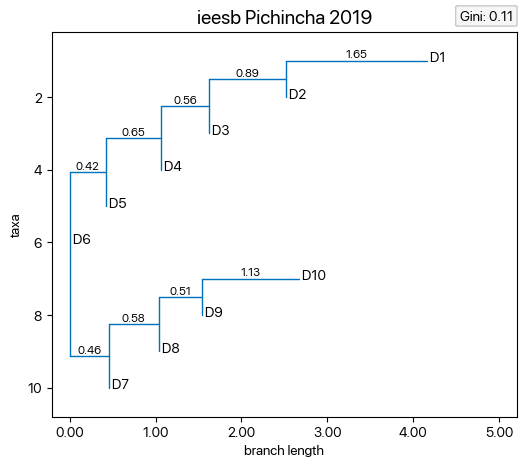

{'D1': 0.050631598555027545, 'D10': 0.15383207695036025, 'D2': 0.06758762454490641, 'D3': 0.07994856025956246, 'D4': 0.08575146377162148, 'D5': 0.0951723713705298, 'D6': 0.1040736201713495, 'D7': 0.11001605802438832, 'D8': 0.12148305452288086, 'D9': 0.13150357182937353}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/ieesb/Esmeraldas_ieesb_2019.pdf


{'D1': 0.05517567589632267, 'D10': 0.15437066238085068, 'D2': 0.06926803522322433, 'D3': 0.07955682427075818, 'D4': 0.08696218332863587, 'D5': 0.09766588539658788, 'D6': 0.10146221198226708, 'D7': 0.10983902026688848, 'D8': 0.11744328946502948, 'D9': 0.12825621178943547}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/ieesb/Imbabura_ieesb_2019.pdf


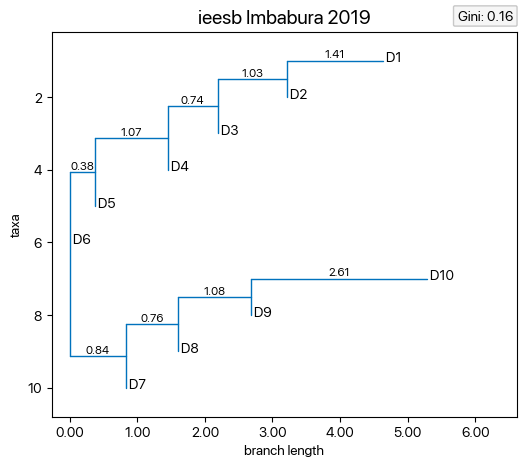

{'D1': 0.05803851058995871, 'D10': 0.14159276338080312, 'D2': 0.07436179880085136, 'D3': 0.08372127227717607, 'D4': 0.09092247642298687, 'D5': 0.0971477153636128, 'D6': 0.10318323463248595, 'D7': 0.10961954759967021, 'D8': 0.116401591669363, 'D9': 0.12501108926309198}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/ieesb/Guayas_ieesb_2019.pdf


{'D1': 0.05404943179553768, 'D10': 0.14261794147763324, 'D2': 0.07187277271875307, 'D3': 0.0820304106441299, 'D4': 0.09123340010063664, 'D5': 0.09772409239608235, 'D6': 0.10511949892629738, 'D7': 0.1118706545312258, 'D8': 0.11763117748936244, 'D9': 0.12585061992034152}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/ieesb/Azuay_ieesb_2019.pdf


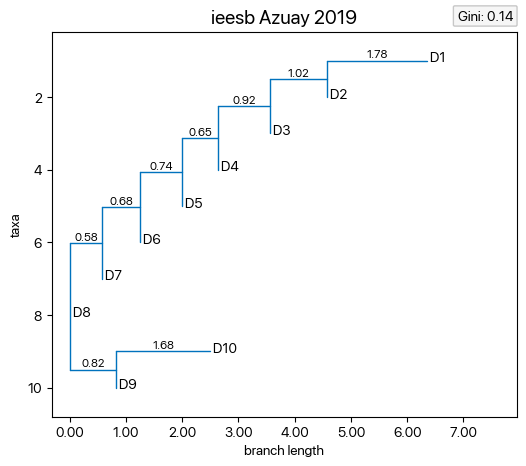

{'D1': 0.06213560289424259, 'D10': 0.1405329085784122, 'D2': 0.07665368665701489, 'D3': 0.0836748469086281, 'D4': 0.09063829005918984, 'D5': 0.09654757312103453, 'D6': 0.10219892549227164, 'D7': 0.10897515330129473, 'D8': 0.11457923007196354, 'D9': 0.1240637829159479}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/ieesb/El Oro_ieesb_2019.pdf


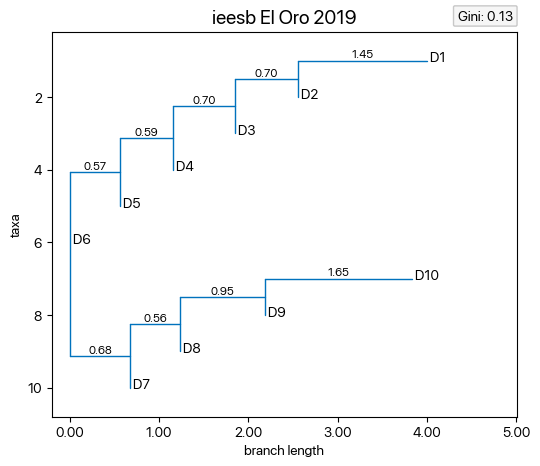

{'D1': 0.061360403815142316, 'D10': 0.1319795631296565, 'D2': 0.07823952168809954, 'D3': 0.0865047638765792, 'D4': 0.09293226807930743, 'D5': 0.09798510335620333, 'D6': 0.10432610787315129, 'D7': 0.11011524482815223, 'D8': 0.11513259359518252, 'D9': 0.12142442975852565}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/ieesb/Tungurahua_ieesb_2019.pdf


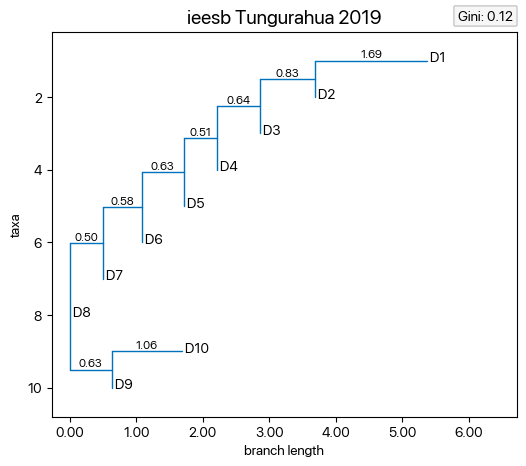

{'D1': 0.0480928381928776, 'D10': 0.15749229507504775, 'D2': 0.06656424621296385, 'D3': 0.07753290360605429, 'D4': 0.0860162188426712, 'D5': 0.09584568963083455, 'D6': 0.10279734310952851, 'D7': 0.1108426601048951, 'D8': 0.12214123825742325, 'D9': 0.1326745669677039}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/ieesb/Manabí_ieesb_2019.pdf


{'D1': 0.05518223212417855, 'D10': 0.15322186772780197, 'D2': 0.07228995362824121, 'D3': 0.08064523207334552, 'D4': 0.08741049163393766, 'D5': 0.09325063697527511, 'D6': 0.09962247457773689, 'D7': 0.10932262954567791, 'D8': 0.11834177913360759, 'D9': 0.1307127025801976}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/ieesb/Los Ríos_ieesb_2019.pdf


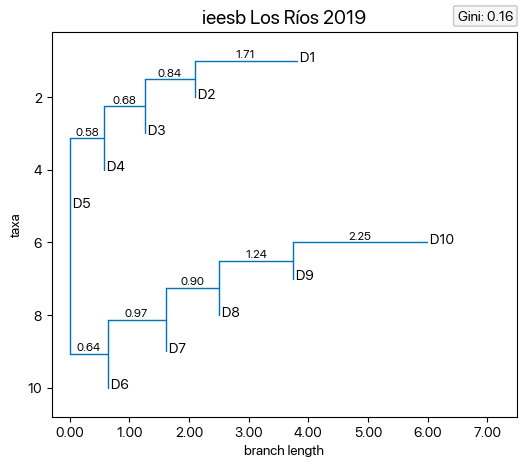

{'D1': 0.04924035240695932, 'D10': 0.17377186826946064, 'D2': 0.06361122402960082, 'D3': 0.07362008232320047, 'D4': 0.07958149825501935, 'D5': 0.09310442097507692, 'D6': 0.09485902222217231, 'D7': 0.10905927817230887, 'D8': 0.12458752697455742, 'D9': 0.13856472637164388}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/ieesb/Los Ríos_ieesb_2021.pdf


{'D1': 0.04380943185272874, 'D10': 0.16607768446661003, 'D2': 0.06898158549663637, 'D3': 0.07306659070399635, 'D4': 0.08767475199098516, 'D5': 0.09346226615823032, 'D6': 0.10790067615208013, 'D7': 0.10773208347455086, 'D8': 0.12408058281080192, 'D9': 0.12721434689338007}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/ieesb/Chimborazo_ieesb_2021.pdf


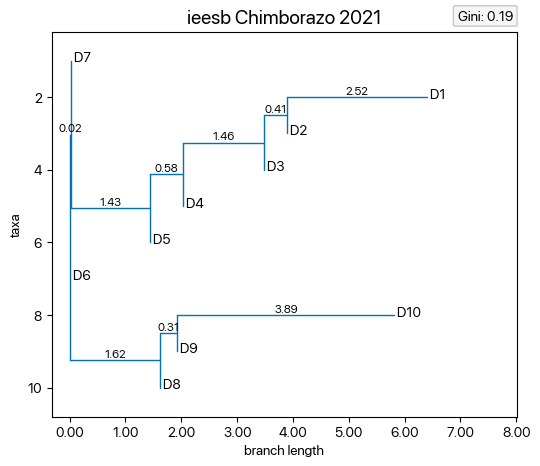

{'D1': 0.05927198057084637, 'D10': 0.13610239090484688, 'D2': 0.07635082907041506, 'D3': 0.08659579797976953, 'D4': 0.09323336973795754, 'D5': 0.09892079880495845, 'D6': 0.10377316283937404, 'D7': 0.1092255432657403, 'D8': 0.11495162564246585, 'D9': 0.12157450118362588}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/ieesb/Pichincha_ieesb_2021.pdf


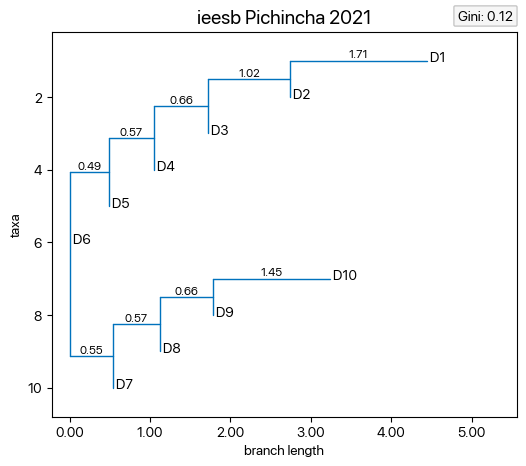

{'D1': 0.05333769731538738, 'D10': 0.14890172570893503, 'D2': 0.06942806908246611, 'D3': 0.07995519785073203, 'D4': 0.08846071224896382, 'D5': 0.09682068477071684, 'D6': 0.10312182465179916, 'D7': 0.11003888644742403, 'D8': 0.11932229996592089, 'D9': 0.13061290195765474}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/ieesb/Esmeraldas_ieesb_2021.pdf


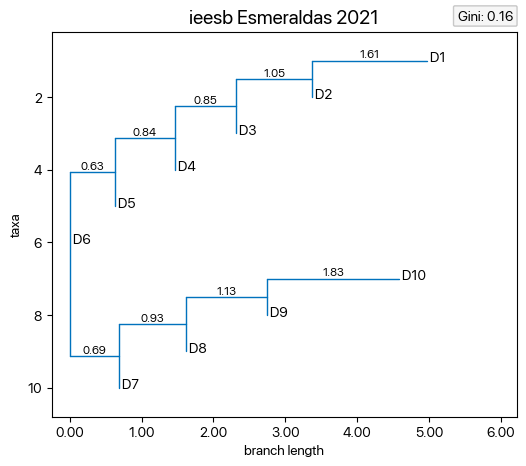

{'D1': 0.05589675875440971, 'D10': 0.14473956771276758, 'D2': 0.07262197637449302, 'D3': 0.08244985045608864, 'D4': 0.09112013249912827, 'D5': 0.09692999439835741, 'D6': 0.10405912456788934, 'D7': 0.1102098634329646, 'D8': 0.11659392909971042, 'D9': 0.125378802704191}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/ieesb/Guayas_ieesb_2021.pdf


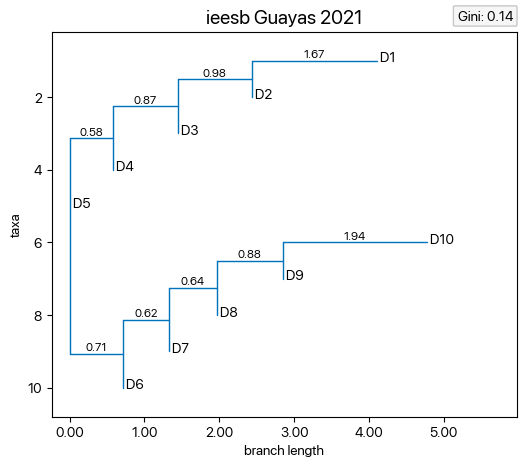

{'D1': 0.05500555306595544, 'D10': 0.14278570374776592, 'D2': 0.07461473966295526, 'D3': 0.08358745766518642, 'D4': 0.09139213035754669, 'D5': 0.09817389414893625, 'D6': 0.10379003505137108, 'D7': 0.10973182154372509, 'D8': 0.11645257687447867, 'D9': 0.12446608788207915}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/ieesb/Azuay_ieesb_2021.pdf


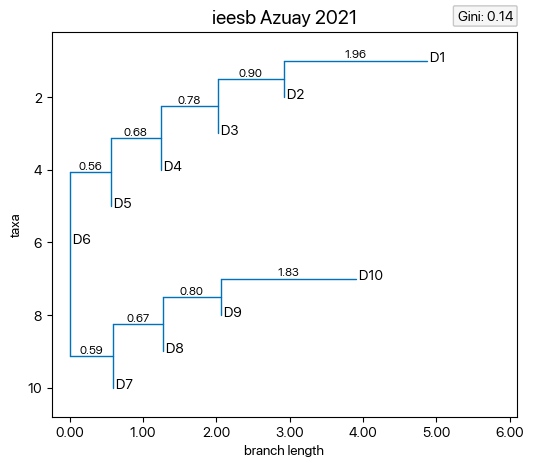

{'D1': 0.05581721413293498, 'D10': 0.16263979521173563, 'D2': 0.06787884094382052, 'D3': 0.07650451363292717, 'D4': 0.08357154614545524, 'D5': 0.09642181379833557, 'D6': 0.10027360179198655, 'D7': 0.10926784598112031, 'D8': 0.11911297382088723, 'D9': 0.12851185454079672}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/ieesb/Manabí_ieesb_2021.pdf


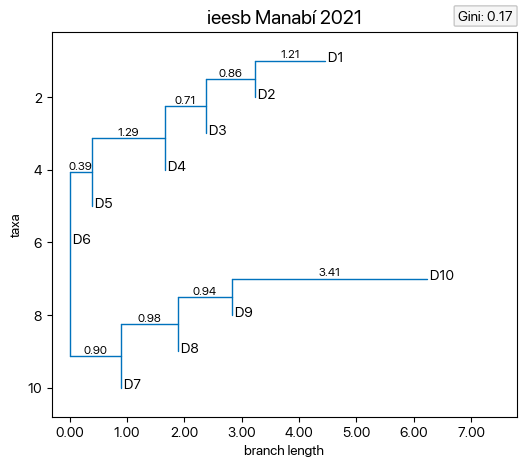

{'D1': 0.05929570963893101, 'D10': 0.14032084143458068, 'D2': 0.07498308360545129, 'D3': 0.08424341767650881, 'D4': 0.09106436407199554, 'D5': 0.09802547937970905, 'D6': 0.10402343970986302, 'D7': 0.10969513300517632, 'D8': 0.11525023029658824, 'D9': 0.12309830118119605}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/ieesb/El Oro_ieesb_2021.pdf


{'D1': 0.06732249890451135, 'D10': 0.13459735886619933, 'D2': 0.07761616559448645, 'D3': 0.08317778274295451, 'D4': 0.09132890499024356, 'D5': 0.09720570880637826, 'D6': 0.10195694377011157, 'D7': 0.1094182128705449, 'D8': 0.11442713329459492, 'D9': 0.12294929015997523}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/ieesb/Tungurahua_ieesb_2021.pdf


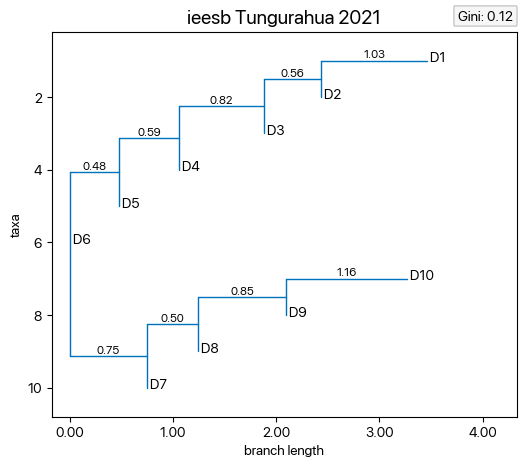

{'D1': 0.055344446641360893, 'D10': 0.1504613451518397, 'D2': 0.0707152555937089, 'D3': 0.08237272651364355, 'D4': 0.08695881869217527, 'D5': 0.0977462869895364, 'D6': 0.1014492369903592, 'D7': 0.10879028931646682, 'D8': 0.12020335995565938, 'D9': 0.12595823415524995}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/ieesb/Imbabura_ieesb_2021.pdf


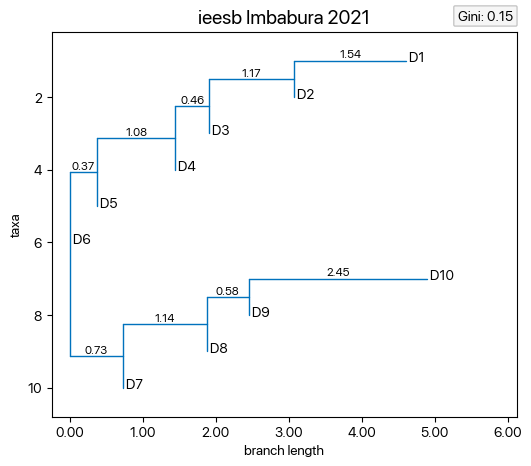

{'D1': 0.0363778797481021, 'D10': 0.1763147643616722, 'D2': 0.051886820872623945, 'D3': 0.07269174049282758, 'D4': 0.07988180618561098, 'D5': 0.0980253640925494, 'D6': 0.10276592926101305, 'D7': 0.11147318673603085, 'D8': 0.13233215199149284, 'D9': 0.1382503562580772}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/ieesb/Chimborazo_ieesb_2022.pdf


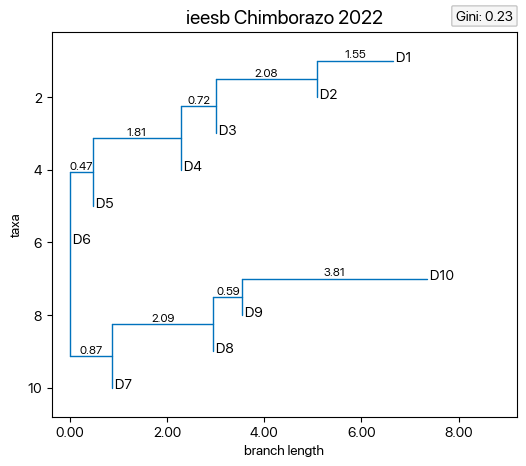

{'D1': 0.04755633467043755, 'D10': 0.16552302253015166, 'D2': 0.06727769478187479, 'D3': 0.07643649856844763, 'D4': 0.08676167240722416, 'D5': 0.09208652227740342, 'D6': 0.10180642100545893, 'D7': 0.10756411355416189, 'D8': 0.12295371964730148, 'D9': 0.13203400055753844}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/ieesb/Esmeraldas_ieesb_2022.pdf


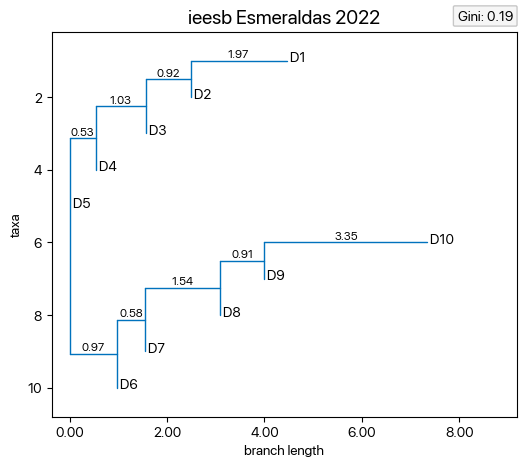

{'D1': 0.059497530557061466, 'D10': 0.13584399932979513, 'D2': 0.07635331111877354, 'D3': 0.08543588368139497, 'D4': 0.09308566899879417, 'D5': 0.09962398648600651, 'D6': 0.10425956894553869, 'D7': 0.10890710881745394, 'D8': 0.11499932443797255, 'D9': 0.12199361762720891}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/ieesb/Azuay_ieesb_2022.pdf


{'D1': 0.051855170255911215, 'D10': 0.15277380825014839, 'D2': 0.06890985157438606, 'D3': 0.07871380345982433, 'D4': 0.08795243283409955, 'D5': 0.09913834276549993, 'D6': 0.10376187071001491, 'D7': 0.11093947199449389, 'D8': 0.11918744430699628, 'D9': 0.12676780384862546}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/ieesb/Imbabura_ieesb_2022.pdf


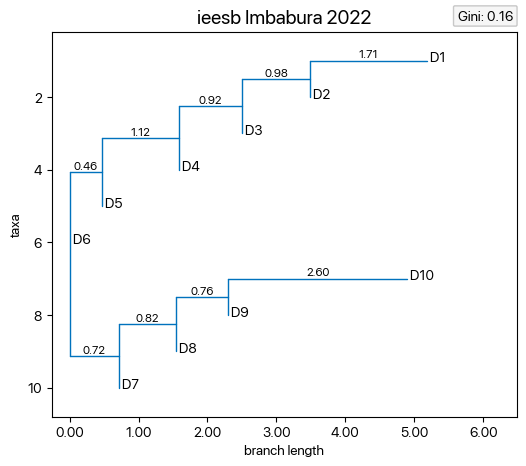

{'D1': 0.060205122224916814, 'D10': 0.13903508183748745, 'D2': 0.07416180333332033, 'D3': 0.08227064138555742, 'D4': 0.09041115272212837, 'D5': 0.09892667728246701, 'D6': 0.10328476910409701, 'D7': 0.1122942083169577, 'D8': 0.11487940917679916, 'D9': 0.12453113461626861}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/ieesb/Tungurahua_ieesb_2022.pdf


{'D1': 0.058347922364482545, 'D10': 0.14224910775713998, 'D2': 0.07490648967273346, 'D3': 0.08424972025216519, 'D4': 0.09001295538013218, 'D5': 0.09718768447376824, 'D6': 0.10331078941497064, 'D7': 0.1079464974224466, 'D8': 0.11641377378977485, 'D9': 0.1253750594723863}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/ieesb/El Oro_ieesb_2022.pdf


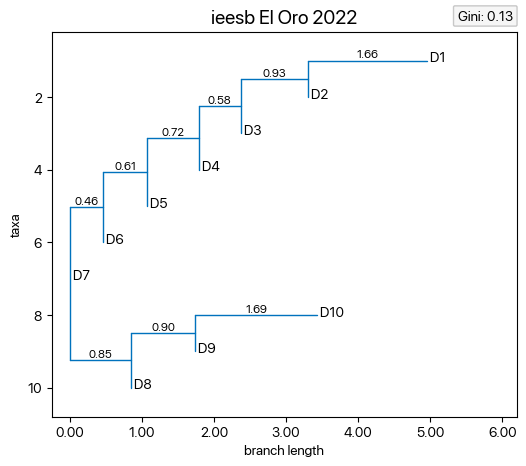

{'D1': 0.0592054732500153, 'D10': 0.13679612044052372, 'D2': 0.07613263562727522, 'D3': 0.08461229561859274, 'D4': 0.09090605468752562, 'D5': 0.09813641818085099, 'D6': 0.10420286065578278, 'D7': 0.10915366556496604, 'D8': 0.11648143147808086, 'D9': 0.1243730444963866}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/ieesb/Guayas_ieesb_2022.pdf


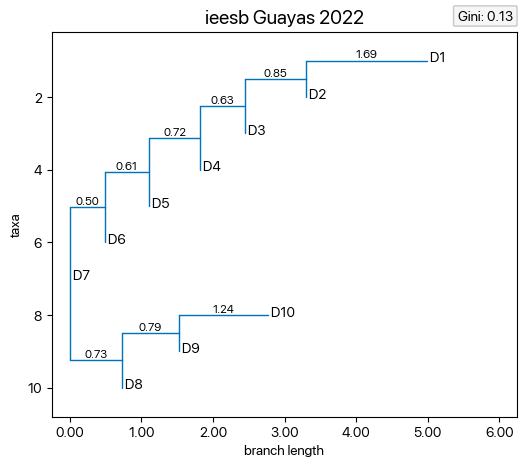

{'D1': 0.0563730178031818, 'D10': 0.16780827228666634, 'D2': 0.06580112011105473, 'D3': 0.07749323398880963, 'D4': 0.08333239088969252, 'D5': 0.09672168450190177, 'D6': 0.09670451198703606, 'D7': 0.1044422852650628, 'D8': 0.12302745607789735, 'D9': 0.12829602708869706}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/ieesb/Los Ríos_ieesb_2022.pdf


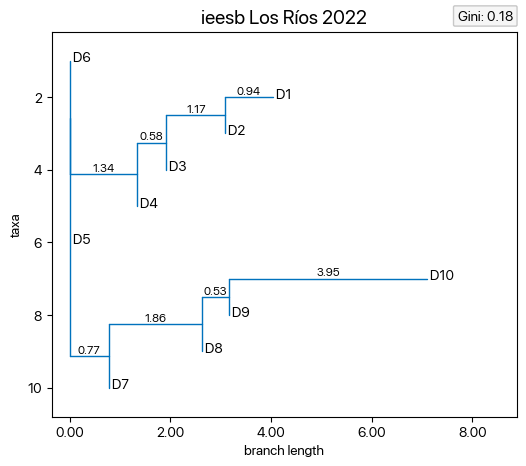

{'D1': 0.04674174668859473, 'D10': 0.15765929943787618, 'D2': 0.06652001977938689, 'D3': 0.07934067226966394, 'D4': 0.08651918851764707, 'D5': 0.09325318113880839, 'D6': 0.10165560889981543, 'D7': 0.1118498656267168, 'D8': 0.12310911512991589, 'D9': 0.13335130251157473}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/ieesb/Manabí_ieesb_2022.pdf


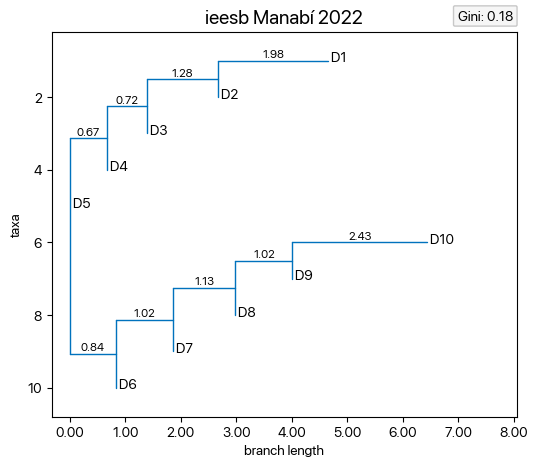

{'D1': 0.053958956107468925, 'D10': 0.1393312547478333, 'D2': 0.0745239476915759, 'D3': 0.0839492688854003, 'D4': 0.09286998470609976, 'D5': 0.09942028605948951, 'D6': 0.10506466174478893, 'D7': 0.11119566790175056, 'D8': 0.11591475397127506, 'D9': 0.12377121818431792}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/ieesb/Pichincha_ieesb_2022.pdf


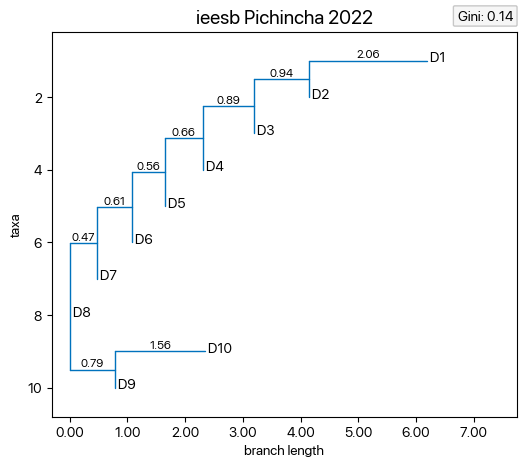

{'D1': 0.06324099920961349, 'D10': 0.13165988266485898, 'D2': 0.07773384092811353, 'D3': 0.08669289118982132, 'D4': 0.09322875991255083, 'D5': 0.09945000781810535, 'D6': 0.10404633085649337, 'D7': 0.10921258868791574, 'D8': 0.11447204771674684, 'D9': 0.12026265101578061}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/ieesb/Pichincha_ieesb_2023.pdf


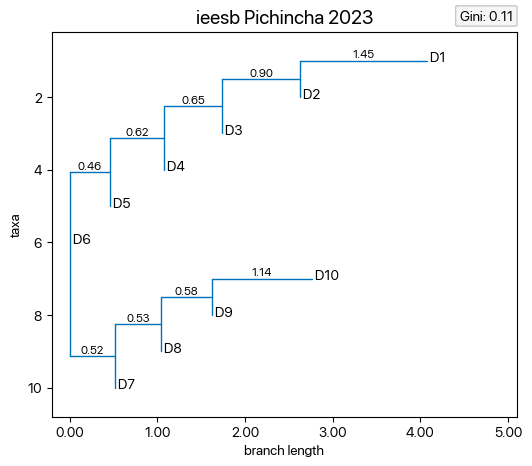

{'D1': 0.060433453531434235, 'D10': 0.1412721070666248, 'D2': 0.07428175472848161, 'D3': 0.08367372018674593, 'D4': 0.09004812274790089, 'D5': 0.09715748325784394, 'D6': 0.1032571054996454, 'D7': 0.10861579189762259, 'D8': 0.11649146475901506, 'D9': 0.12476899632468548}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/ieesb/Guayas_ieesb_2023.pdf


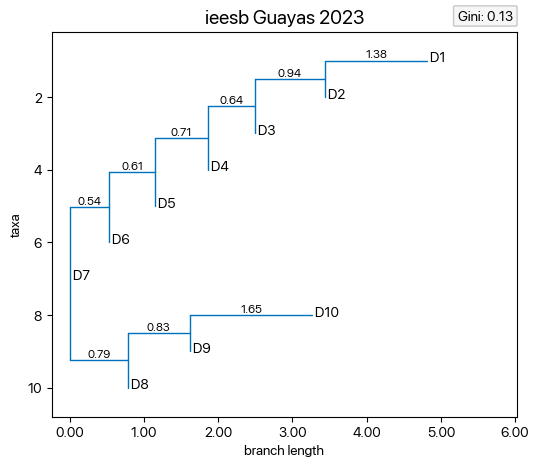

{'D1': 0.05115056384602907, 'D10': 0.1437483184962883, 'D2': 0.07023233150167668, 'D3': 0.0810646452305666, 'D4': 0.09229422899108401, 'D5': 0.09744636873771494, 'D6': 0.1050611213992412, 'D7': 0.1146213593155, 'D8': 0.11784274484353621, 'D9': 0.12653831763836285}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/ieesb/Imbabura_ieesb_2023.pdf


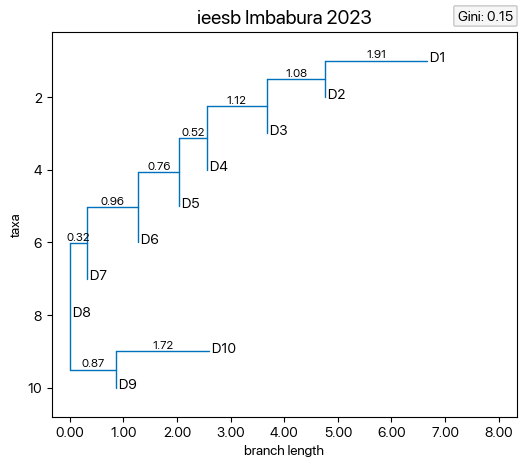

{'D1': 0.061041047200975036, 'D10': 0.14369337665208215, 'D2': 0.07428422491732144, 'D3': 0.08145349687976902, 'D4': 0.09020770842976791, 'D5': 0.09635594343195963, 'D6': 0.10091457128109607, 'D7': 0.10884132697101756, 'D8': 0.11636480254034427, 'D9': 0.12684350169566685}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/ieesb/El Oro_ieesb_2023.pdf


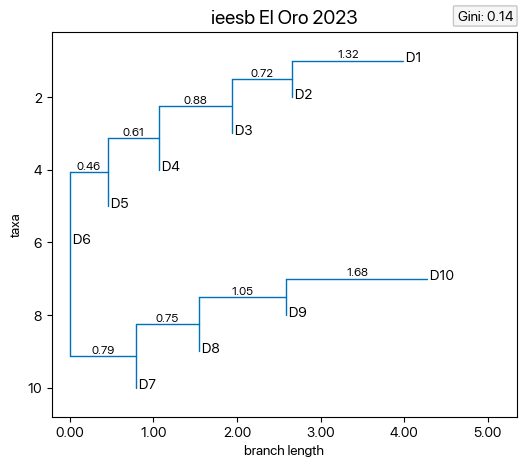

{'D1': 0.05121759458262268, 'D10': 0.15759408233250305, 'D2': 0.06621124866690226, 'D3': 0.07611919424578492, 'D4': 0.08586873661574597, 'D5': 0.09305159568792007, 'D6': 0.1005401078285857, 'D7': 0.11156959610486508, 'D8': 0.12263178821523678, 'D9': 0.1351960557198336}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/ieesb/Esmeraldas_ieesb_2023.pdf


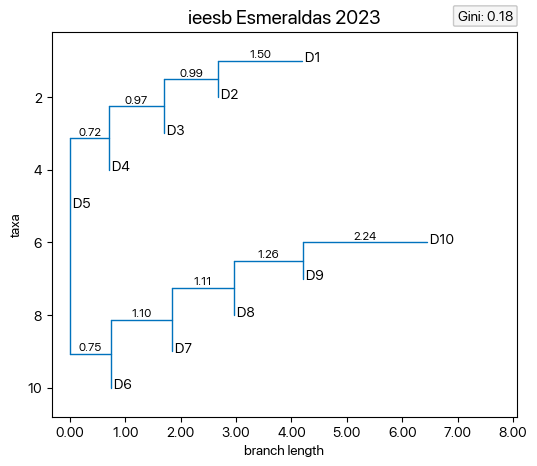

{'D1': 0.04930518742320399, 'D10': 0.17711596292350149, 'D2': 0.06369108075224404, 'D3': 0.07038239360406802, 'D4': 0.07865296447095296, 'D5': 0.09194966233144586, 'D6': 0.094133413048704, 'D7': 0.10940996827409025, 'D8': 0.12567664087938515, 'D9': 0.13968272629240414}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/ieesb/Manabí_ieesb_2023.pdf


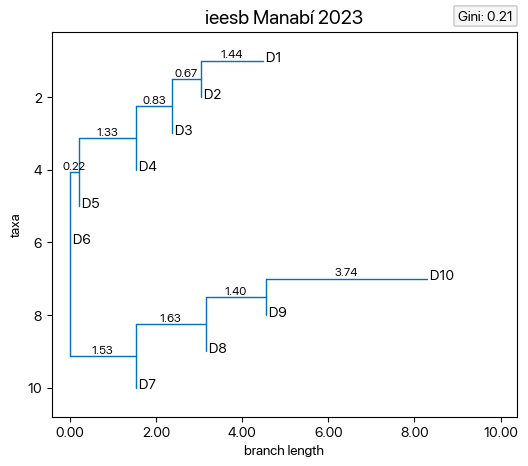

{'D1': 0.055727923455891816, 'D10': 0.15377768481480664, 'D2': 0.07373368939682041, 'D3': 0.07571887757814835, 'D4': 0.08758855648993574, 'D5': 0.09443292564496066, 'D6': 0.09776841891526959, 'D7': 0.11411047020465719, 'D8': 0.11449390739092537, 'D9': 0.1326475461085842}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/ieesb/Los Ríos_ieesb_2023.pdf


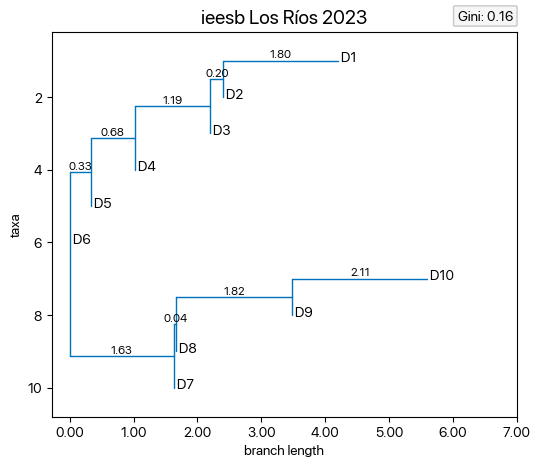

{'D1': 0.059004021031829654, 'D10': 0.13855360160655797, 'D2': 0.07461536712109185, 'D3': 0.08404884212306517, 'D4': 0.0908669585431409, 'D5': 0.0992515573708117, 'D6': 0.10352260436752822, 'D7': 0.10987626394342184, 'D8': 0.11665878185749061, 'D9': 0.12360200203506193}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/ieesb/Azuay_ieesb_2023.pdf


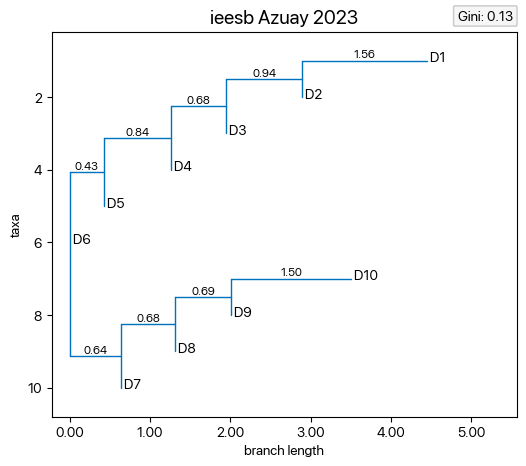

{'D1': 0.050518738366865774, 'D10': 0.14749526226859788, 'D2': 0.0683944384871934, 'D3': 0.08184477184709348, 'D4': 0.0904153872885174, 'D5': 0.09920388215951224, 'D6': 0.10393231770603999, 'D7': 0.11093279077677765, 'D8': 0.11998389217021331, 'D9': 0.1272785189291887}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/ieesb/Tungurahua_ieesb_2023.pdf


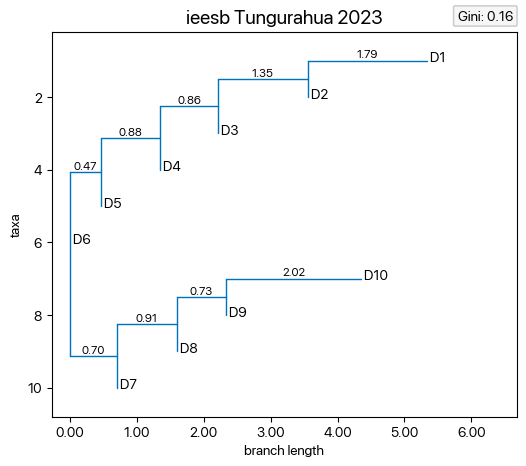

{'D1': 0.04606966210591963, 'D10': 0.17115233660221624, 'D2': 0.058263922658377904, 'D3': 0.07039120172047612, 'D4': 0.08125849152034816, 'D5': 0.09231694564575503, 'D6': 0.09548011295118355, 'D7': 0.11257617300683281, 'D8': 0.1253646167104737, 'D9': 0.1471265370784168}
Compute SB: done


/usr/local/lib/python3.11/dist-packages/inequality/gini.py:43: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  x = x.ravel()  # ensure shape is (n,)
<ipython-input-124-734b34059712>:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x * 100:.2f}" for x in xticks])  # Multiply tick labels by 100


Plot saved as plots/provinces/ieesb/Chimborazo_ieesb_2023.pdf


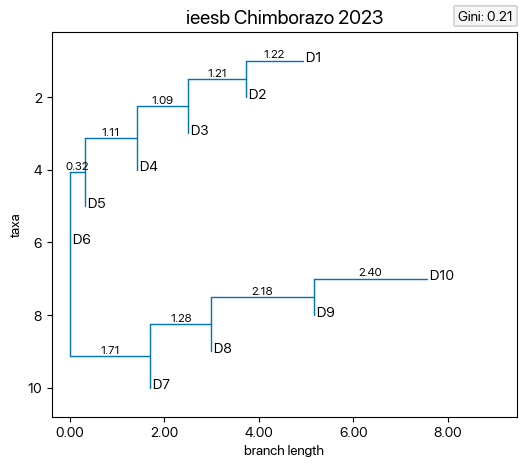

In [ ]:
# árboles de la variable adicional para cada año a nivel de provincia
os.makedirs("plots/provinces/ieesb/", exist_ok=True)
for y in years:
    directory = f"data/{y}/{y}_prov"
    for file in os.listdir(directory):
        if file.endswith("ieesb.csv"):
            data = pd.read_csv(join(directory, file))
            ieesb_dict, ieesb_tree = compute_tree_for_ieesb_by_deciles(data)
            code = file.split("_")[1][-2:]
            plot_tree(ieesb_tree, gini=Gini(data["ieesb"]).g, title=f"ieesb {province_names[code]} {y}", path="plots/provinces/ieesb/", filename=f"{province_names[code]}_ieesb_{y}.pdf")

## Persistence diagrams for each province for each year

In [ ]:
# first compute persistence barcodes
# correr por partes, primero 2019 y 2021, luego 2022 y 2023
import time
import json
from tqdm import tqdm

os.makedirs("dictionaries", exist_ok=True)

years = [2019,2021]

Barcodes = {}
for year in years:
    Barcodes[year] = {}
    directory = f"DMs/{year}/prov"
    files = [dm for dm in os.listdir(directory) if dm.endswith(".txt")]
    total_files = len(files)
    start_time = time.time()
    for i, dm in enumerate(tqdm(files, desc=f"Processing year {year}", unit="file")):
        distance_mat = os.path.join(directory, dm)
        prov_code = os.path.splitext(os.path.basename(dm))[0]
        print(province_names[prov_code])
        persistence = compute_persistence(distance_mat)
        Barcodes[year][prov_code] = persistence
        with open(f'dictionaries/{year}_{prov_code}.json', 'w') as file:
            json.dump(persistence, file)
        elapsed_time = time.time() - start_time
        files_processed = i + 1
        avg_time_per_file = elapsed_time / files_processed
        remaining_time = avg_time_per_file * (total_files - files_processed)
        print(
            f"Processed {files_processed}/{total_files} files "
            f"({elapsed_time:.2f} seconds elapsed). "
            f"Estimated remaining time: {remaining_time:.2f} seconds."
        )


Processing year 2019:   0%|          | 0/10 [00:00<?, ?file/s]

Imbabura


Processing year 2019:   0%|          | 0/10 [00:09<?, ?file/s]


KeyboardInterrupt: 

In [ ]:
# descargar plots
from google.colab import files
shutil.make_archive("barcodes_data_19_21", 'zip', "dictionaries")
files.download("barcodes_data_19_21.zip")

In [ ]:
!unzip -q barcodes_data_19_21.zip -d barcodes_data_19_21

In [ ]:
!unzip -q barcodes_data_22_23.zip -d barcodes_data_22_23

In [ ]:
import json
import os

Barcodes = {}

data_19_21 = {}
for file in os.listdir("barcodes_data_19_21"):
    if file.endswith(".json"):
        year = int(file.split("_")[0])
        code = file.split("_")[1].split(".")[0]
        if year not in data_19_21:
            data_19_21[year] = {}  # Initialize only if the year is not in data
        with open(os.path.join("barcodes_data_19_21", file), "r") as f:
            data_19_21[year][code] = json.load(f)

Barcodes.update(data_19_21)

data_22_23 = {}
for file in os.listdir("barcodes_data_22_23"):
    if file.endswith(".json"):
        year = int(file.split("_")[0])
        code = file.split("_")[1].split(".")[0]
        if year not in data_22_23:
            data_22_23[year] = {}  # Initialize only if the year is not in data
        with open(os.path.join("barcodes_data_22_23", file), "r") as f:
            data_22_23[year][code] = json.load(f)

Barcodes.update(data_22_23)

In [ ]:
Barcodes[2019].keys()

In [ ]:
Barcodes[2022].keys()

In [ ]:
# now plot persistence diagrams
dir = "plots/provinces/pds/"
os.makedirs(dir, exist_ok=True)

for year, year_barcodes in Barcodes.items():
    for prov_code, barcode in year_barcodes.items():
        h0_values = [interval for dim, interval in barcode if dim == 0]
        h1_values = [interval for dim, interval in barcode if dim == 1]
        lifespans_h0 = [death - birth for birth, death in h0_values if not math.isinf(death)]
        lifespans_h1 = [death - birth for birth, death in h1_values if not math.isinf(death)]
        save_barcode_to_txt(barcode, f"{dir}{province_names[prov_code]}_barcode_{year}.txt")
        plot_pd(barcode, avg=[np.mean(lifespans_h0), np.mean(lifespans_h1)], title=f"{province_names[prov_code]} {year}", path=f"{dir}{province_names[prov_code]}_pd_{year}.pdf", show=True)

## plotear códigos de barras

In [ ]:
# now plot persistence diagrams
dir = "plots/provinces/pds/"
os.makedirs(dir, exist_ok=True)

for year, year_barcodes in Barcodes.items():
    for prov_code, barcode in year_barcodes.items():
            fig = gd.plot_persistence_barcode(
                barcode,
                legend=False,  # Disable the default legend
                colormap=['#1f66a9', '#9e0100', '#20716f'],
                alpha=0.7,
            )
            fig.set_title(f"{province_names[prov_code]} {year}", fontsize=14)

agregar la barra del promedio

In [ ]:
for year, year_barcodes in Barcodes.items():
    for prov_code, barcode in year_barcodes.items():
        # Filter H0 bars (bars where dimension == 0)
        h0_bars = [
            bar[1] for bar in barcode
            if len(bar) == 2 and bar[0] == 0 and isinstance(bar[1], list) and len(bar[1]) == 2 and
            isinstance(bar[1][0], (int, float)) and isinstance(bar[1][1], (int, float)) and bar[1][1] < float("inf")
        ]

        # Calculate lengths of H0 bars
        h0_lengths = [death - birth for birth, death in h0_bars]

        # Calculate the mean length of H0 bars
        h0_mean_length = sum(h0_lengths) / len(h0_lengths) if h0_lengths else 0

        # Plot the barcode
        fig = gd.plot_persistence_barcode(
            barcode,
            legend=False,
            colormap=['#1f66a9', '#9e0100', '#20716f'],
            alpha=0.7,
        )

        # Add the mean bar for H0 to the plot
        ax = plt.gca()  # Get the current axis

        # Place the mean bar slightly above the top-most bar
        y_position = len(h0_bars) + 0.5  # Slightly above the last bar

        ax.hlines(
            y=y_position,  # Position the mean line slightly above
            xmin=0,
            xmax=h0_mean_length,
            colors="red",
            linestyles="solid",  # Solid line
            linewidth=2,
            label="Mean H0 Length"
        )

        # Customize the plot
        ax.set_title(f"{province_names[prov_code]} {year}", fontsize=14)
        ax.legend()

        # Show the plot
        plt.show()


## descargar plots


In [ ]:
# descargar plots
nombre_archivo = "arboles_sin_raiz_19_21_22_23" # 2025-01-27
shutil.make_archive(nombre_archivo, 'zip', "plots")
files.download(f"{nombre_archivo}.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>